Environment versions:
Matplotlib 3.7.1
Numpy 1.26.4
Pandas 2.2.1
Python 3.11.3
Seaborn 0.12.2
Scipy 1.10.1
Pandas profiling 3.6.6
Sklearn 1.4.1
Folium 0.16.0
Mlxtend 0.23.1
Imblearn 0.12.0

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from ydata_profiling import ProfileReport
import folium
import warnings
from scipy import stats
from folium.plugins import HeatMap
from scipy.stats import skew, kurtosis, ttest_ind, chi2_contingency
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, classification_report, confusion_matrix, roc_curve, auc, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
%matplotlib inline

C:\Users\873958\AppData\Roaming\Python\Python311\site-packages\sklearn_extra\cluster\_commonnn.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.23.0"):
C:\Users\873958\AppData\Roaming\Python\Python311\site-packages\sklearn_extra\cluster\_commonnn.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.23.0"):


In [2]:
#Suppress some warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

Colours for plots chosen based on:
Choosing Colormaps in Matplotlib — Matplotlib 3.8.1 documentation - colour guide 
https://matplotlib.org/stable/users/explain/colors/colormaps.html.

Using 'viridis' palette/colours throughout as colour blind friendly.

**Data retrieval from database and conversion to Pandas dataframe**

In [3]:
#Connect to database accident_data using SQLite3
#Call sqlite3.connect() to create a connection to the database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
#In order to execute SQL statements and fetch results from SQL queries, create a database cursor.
cur = con.cursor()
#Print all table names
res = cur.execute("SELECT name FROM sqlite_master")
res.fetchall()

[('accident',),
 ('sqlite_autoindex_accident_1',),
 ('casualty',),
 ('sqlite_autoindex_casualty_1',),
 ('vehicle',),
 ('sqlite_autoindex_vehicle_1',),
 ('lsoa',),
 ('sqlite_autoindex_lsoa_1',)]

In [4]:
#Retrieve column names for the vehicle table
vehicle_col_info = cur.execute("PRAGMA table_info(vehicle)").fetchall()

#Retrieve column names for the accident table
accident_col_info = cur.execute("PRAGMA table_info(accident)").fetchall()

#Retrieve column names for the casualty table
casualty_col_info = cur.execute("PRAGMA table_info(casualty)").fetchall()

#Retrieve column names for the lsoa table
lsoa_col_info = cur.execute("PRAGMA table_info(lsoa)").fetchall()

#Extract column names from the column information and store them in separate lists
vehicle_columns = [column[1] for column in vehicle_col_info]
accident_columns = [column[1] for column in accident_col_info]
casualty_columns = [column[1] for column in casualty_col_info]
lsoa_columns = [column[1] for column in lsoa_col_info]

#Print the column names for each table
print("Columns in 'vehicle' table:", vehicle_columns)
print("Columns in 'accident' table:", accident_columns)
print("Columns in 'casualty' table:", casualty_columns)
print("Columns in 'lsoa' table:", lsoa_columns)

Columns in 'vehicle' table: ['vehicle_index', 'accident_index', 'accident_year', 'accident_reference', 'vehicle_reference', 'vehicle_type', 'towing_and_articulation', 'vehicle_manoeuvre', 'vehicle_direction_from', 'vehicle_direction_to', 'vehicle_location_restricted_lane', 'junction_location', 'skidding_and_overturning', 'hit_object_in_carriageway', 'vehicle_leaving_carriageway', 'hit_object_off_carriageway', 'first_point_of_impact', 'vehicle_left_hand_drive', 'journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver', 'age_band_of_driver', 'engine_capacity_cc', 'propulsion_code', 'age_of_vehicle', 'generic_make_model', 'driver_imd_decile', 'driver_home_area_type']
Columns in 'accident' table: ['accident_index', 'accident_year', 'accident_reference', 'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude', 'police_force', 'accident_severity', 'number_of_vehicles', 'number_of_casualties', 'date', 'day_of_week', 'time', 'local_authority_district', 'local_authority_o

In [5]:
#Display first 5 rows of lsoa table 
cur.execute("SELECT * FROM lsoa LIMIT 5")

#Fetch the first five rows
rows = cur.fetchmany(5)

#Display the result
for row in rows:
    print(row)

(1, 'E01000001', 'City of London 001A', 'City of London 001A', 129865.232551575, 2635.77200095126, '68cc6127-1008-4fbe-a16c-78fb089a7c43')
(2, 'E01000002', 'City of London 001B', 'City of London 001B', 228418.896621704, 2707.98620166511, '937edbc3-c1bf-4d35-b274-b0a1480a7c09')
(3, 'E01000003', 'City of London 001C', 'City of London 001C', 59054.7690048218, 1224.77447915666, '2686dcaf-10b9-4736-92af-4788d4feaa69')
(4, 'E01000004', 'City of London 001D', 'City of London 001D', 2544551.14173126, 10718.4662400471, '3c493140-0b3f-4b9a-b358-22011dc5fb89')
(5, 'E01000005', 'City of London 001E', 'City of London 001E', 189578.164024353, 2275.8093576013, 'b569093d-788d-41be-816c-d6d7658b2311')


In [6]:
#Require only 2020 data from tables in this assignment
#lsoa table does not contain any dated data so remains as it is (location inforamtion)
#Need 2020 data from accident, vehicle and casualty tables
#Execute SQL command to fetch data from accident table for accident_year 2020
cur.execute('''SELECT * 
    FROM accident 
    WHERE accident_year = 2020''')
accident_rows = cur.fetchall()

#Execute SQL command to fetch data from vehicle table for accident_year 2020
cur.execute('''SELECT * 
    FROM vehicle 
    WHERE accident_year = 2020''')
vehicle_rows = cur.fetchall()

#Execute SQL command to fetch data from casualty table for accident_year 2020
cur.execute('''SELECT * 
    FROM casualty 
    WHERE accident_year = 2020''')
casualty_rows = cur.fetchall()

#Execute SQL command to fetch all data from lsoa table
cur.execute("SELECT * FROM lsoa")
lsoa_rows = cur.fetchall()

In [7]:
#Close the cursor and connection
cur.close()
con.close()

In [8]:
#Create dataframes for each table containg only 2020 data using the retrieved rows and column names
accident_df = pd.DataFrame(accident_rows, columns=accident_columns)
vehicle_df = pd.DataFrame(vehicle_rows, columns=vehicle_columns)
casualty_df = pd.DataFrame(casualty_rows, columns=casualty_columns)
lsoa_df = pd.DataFrame(lsoa_rows, columns=lsoa_columns)

In [9]:
#Print df info
accident_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 36 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   accident_index                               91199 non-null  object 
 1   accident_year                                91199 non-null  int64  
 2   accident_reference                           91199 non-null  object 
 3   location_easting_osgr                        91185 non-null  float64
 4   location_northing_osgr                       91185 non-null  float64
 5   longitude                                    91185 non-null  float64
 6   latitude                                     91185 non-null  float64
 7   police_force                                 91199 non-null  int64  
 8   accident_severity                            91199 non-null  int64  
 9   number_of_vehicles                           91199 non-null  int64  
 10

In [10]:
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167375 entries, 0 to 167374
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   vehicle_index                     167375 non-null  int64 
 1   accident_index                    167375 non-null  object
 2   accident_year                     167375 non-null  int64 
 3   accident_reference                167375 non-null  object
 4   vehicle_reference                 167375 non-null  int64 
 5   vehicle_type                      167375 non-null  int64 
 6   towing_and_articulation           167375 non-null  int64 
 7   vehicle_manoeuvre                 167375 non-null  int64 
 8   vehicle_direction_from            167375 non-null  int64 
 9   vehicle_direction_to              167375 non-null  int64 
 10  vehicle_location_restricted_lane  167375 non-null  int64 
 11  junction_location                 167375 non-null  int64 
 12  sk

In [11]:
casualty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115584 entries, 0 to 115583
Data columns (total 19 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   casualty_index                      115584 non-null  int64 
 1   accident_index                      115584 non-null  object
 2   accident_year                       115584 non-null  int64 
 3   accident_reference                  115584 non-null  object
 4   vehicle_reference                   115584 non-null  int64 
 5   casualty_reference                  115584 non-null  int64 
 6   casualty_class                      115584 non-null  int64 
 7   sex_of_casualty                     115584 non-null  int64 
 8   age_of_casualty                     115584 non-null  int64 
 9   age_band_of_casualty                115584 non-null  int64 
 10  casualty_severity                   115584 non-null  int64 
 11  pedestrian_location                 115

In [12]:
lsoa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34378 entries, 0 to 34377
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   objectid       34378 non-null  int64  
 1   lsoa01cd       34378 non-null  object 
 2   lsoa01nm       34378 non-null  object 
 3   lsoa01nmw      34378 non-null  object 
 4   shape__area    34378 non-null  float64
 5   shape__length  34378 non-null  float64
 6   globalid       34378 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.8+ MB


In [13]:
#Print first rew rows of accident_df
accident_df.head() 

accident_index  accident_year accident_reference  location_easting_osgr  \
0  2020010219808           2020          010219808               521389.0   
1  2020010220496           2020          010220496               529337.0   
2  2020010228005           2020          010228005               526432.0   
3  2020010228006           2020          010228006               538676.0   
4  2020010228011           2020          010228011               529324.0   

   location_northing_osgr  longitude   latitude  police_force  \
0                175144.0  -0.254001  51.462262             1   
1                176237.0  -0.139253  51.470327             1   
2                182761.0  -0.178719  51.529614             1   
3                184371.0  -0.001683  51.541210             1   
4                181286.0  -0.137592  51.515704             1   

   accident_severity  number_of_vehicles  ...  \
0                  3                   1  ...   
1                  3                   1  ...   
2                  3                   1  ...   
3                  2                   1  ...   
4                  3                   1  ...   

   pedestrian_crossing_physical_facilities light_conditions  \
0                                        9                1   
1                                        4                1   
2                                        0                4   
3                                        4                4   
4                                        0                4   

   weather_conditions road_surface_conditions  special_conditions_at_site  \
0                   9                       9                           0   
1                   1                       1                           0   
2                   1                       2                           0   
3                   1                       1                           0   
4                   1                       1                           0   

  carriageway_hazards urban_or_rural_area  \
0                   0                   1   
1                   0                   1   
2                   0                   1   
3                   0                   1   
4                   0                   1   

   did_police_officer_attend_scene_of_accident  trunk_road_flag  \
0                                            3                2   
1                                            1                2   
2                                            1                2   
3                                            1                2   
4                                            1                2   

   lsoa_of_accident_location  
0                  E01004576  
1                  E01003034  
2                  E01004726  
3                  E01003617  
4                  E01004763  

[5 rows x 36 columns]

In [14]:
#Print first rew rows of vehicle_df
vehicle_df.head()
#Appears to be some -1 values in some columns not corresponding to categorisation in the data guidance
#https://www.gov.uk/government/publications/road-accidents-and-safety-statistics-notes-and-definitions/reported-road-casualties-in-great-britain-notes-definitions-symbols-and-conventions
#This could be across all databases so need to check and deal with and negative missing values

vehicle_index accident_index  accident_year accident_reference  \
0         681716  2020010219808           2020          010219808   
1         681717  2020010220496           2020          010220496   
2         681718  2020010228005           2020          010228005   
3         681719  2020010228006           2020          010228006   
4         681720  2020010228011           2020          010228011   

   vehicle_reference  vehicle_type  towing_and_articulation  \
0                  1             9                        9   
1                  1             9                        0   
2                  1             9                        0   
3                  1             8                        0   
4                  1             9                        0   

   vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
0                  5                       1                     5  ...   
1                  4                       2                     6  ...   
2                 18                      -1                    -1  ...   
3                 18                       1                     5  ...   
4                 18                       3                     7  ...   

   journey_purpose_of_driver  sex_of_driver  age_of_driver  \
0                          6              2             32   
1                          2              1             45   
2                          6              3             -1   
3                          1              1             44   
4                          6              1             20   

   age_band_of_driver  engine_capacity_cc  propulsion_code  age_of_vehicle  \
0                   6                1968                2               6   
1                   7                1395                1               2   
2                  -1                  -1               -1              -1   
3                   7                1798                8               8   
4                   4                2993                2               4   

   generic_make_model  driver_imd_decile  driver_home_area_type  
0             AUDI Q5                  4                      1  
1             AUDI A1                  7                      1  
2                  -1                 -1                     -1  
3        TOYOTA PRIUS                  2                      1  
4        BMW 4 SERIES                 -1                     -1  

[5 rows x 28 columns]

In [15]:
#Print first rew rows of casualty_df
casualty_df.head() 

casualty_index accident_index  accident_year accident_reference  \
0          484748  2020010219808           2020          010219808   
1          484749  2020010220496           2020          010220496   
2          484750  2020010220496           2020          010220496   
3          484751  2020010228005           2020          010228005   
4          484752  2020010228006           2020          010228006   

   vehicle_reference  casualty_reference  casualty_class  sex_of_casualty  \
0                  1                   1               3                1   
1                  1                   1               3                2   
2                  1                   2               3                2   
3                  1                   1               3                1   
4                  1                   1               3                1   

   age_of_casualty  age_band_of_casualty  casualty_severity  \
0               31                     6                  3   
1                2                     1                  3   
2                4                     1                  3   
3               23                     5                  3   
4               47                     8                  2   

   pedestrian_location  pedestrian_movement  car_passenger  \
0                    9                    5              0   
1                    1                    1              0   
2                    1                    1              0   
3                    5                    9              0   
4                    4                    1              0   

   bus_or_coach_passenger  pedestrian_road_maintenance_worker  casualty_type  \
0                       0                                   0              0   
1                       0                                   0              0   
2                       0                                   0              0   
3                       0                                   0              0   
4                       0                                   0              0   

   casualty_home_area_type  casualty_imd_decile  
0                        1                    4  
1                        1                    2  
2                        1                    2  
3                        1                    3  
4                        1                    3

In [16]:
#Print first rew rows of lsoa_df
lsoa_df.head()

objectid   lsoa01cd             lsoa01nm            lsoa01nmw  \
0         1  E01000001  City of London 001A  City of London 001A   
1         2  E01000002  City of London 001B  City of London 001B   
2         3  E01000003  City of London 001C  City of London 001C   
3         4  E01000004  City of London 001D  City of London 001D   
4         5  E01000005  City of London 001E  City of London 001E   

    shape__area  shape__length                              globalid  
0  1.298652e+05    2635.772001  68cc6127-1008-4fbe-a16c-78fb089a7c43  
1  2.284189e+05    2707.986202  937edbc3-c1bf-4d35-b274-b0a1480a7c09  
2  5.905477e+04    1224.774479  2686dcaf-10b9-4736-92af-4788d4feaa69  
3  2.544551e+06   10718.466240  3c493140-0b3f-4b9a-b358-22011dc5fb89  
4  1.895782e+05    2275.809358  b569093d-788d-41be-816c-d6d7658b2311

**Data cleaning**

Performed on 09/03/2024 at 9am.

EDA, Pandas profiling

Pandas profiling Pandas-profiling 3.6.6 (2024). Available online: https://pypi.org/project/pandas-profiling/ [Accessed 09/03/2024].

In [17]:
#Run EDA Pandas profiling
#For accident_df
#accident_profile = ProfileReport(accident_df)
#accident_profile
#accident_profile.to_file(output_file ='accident_profile.html')

In [18]:
#vehicle_profile = ProfileReport(vehicle_df)
#vehicle_profile
#vehicle_profile.to_file(output_file ='vehicle_profile.html')

In [19]:
#casualty_profile = ProfileReport(casualty_df)
#casualty_profile
#casualty_profile.to_file(output_file ='casualty_profile.html')

*NaN*

No missing values in vehicle_df and casualty_df. 56 missing values total in accident_df, 14 rows of data missing from 'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude', all real number (numerical attributes/columns) and related location data.

In [20]:
#Filter rows with missing values in columns 'location_easting_osgr', 'location_northing_osgr', 'longitude' and 'latitude' in accident_df
missing_values_rows = accident_df[
    accident_df['location_easting_osgr'].isnull() |
    accident_df['location_northing_osgr'].isnull() |
    accident_df['longitude'].isnull() |
    accident_df['latitude'].isnull()
]

#Display the rows with missing values - there should be 14 rows
display(missing_values_rows)

accident_index  accident_year accident_reference  location_easting_osgr  \
25520  2020052002442           2020          052002442                    NaN   
29452  2020070769852           2020          070769852                    NaN   
32689  2020122001194           2020          122001194                    NaN   
33578  2020137330369           2020          137330369                    NaN   
81252  2020522005114           2020          522005114                    NaN   
86437  2020622001016           2020          622001016                    NaN   
86642  202063A017520           2020          63A017520                    NaN   
86651  202063A018920           2020          63A018920                    NaN   
86668  202063A025020           2020          63A025020                    NaN   
86705  202063A035620           2020          63A035620                    NaN   
86785  202063A059120           2020          63A059120                    NaN   
87018  202063C020320           2020          63C020320                    NaN   
87030  202063C024520           2020          63C024520                    NaN   
87296  202063D061520           2020          63D061520                    NaN   

       location_northing_osgr  longitude  latitude  police_force  \
25520                     NaN        NaN       NaN             5   
29452                     NaN        NaN       NaN             7   
32689                     NaN        NaN       NaN            12   
33578                     NaN        NaN       NaN            13   
81252                     NaN        NaN       NaN            52   
86437                     NaN        NaN       NaN            62   
86642                     NaN        NaN       NaN            63   
86651                     NaN        NaN       NaN            63   
86668                     NaN        NaN       NaN            63   
86705                     NaN        NaN       NaN            63   
86785                     NaN        NaN       NaN            63   
87018                     NaN        NaN       NaN            63   
87030                     NaN        NaN       NaN            63   
87296                     NaN        NaN       NaN            63   

       accident_severity  number_of_vehicles  ...  \
25520                  2                   2  ...   
29452                  3                   2  ...   
32689                  3                   2  ...   
33578                  3                   2  ...   
81252                  3                   3  ...   
86437                  3                   2  ...   
86642                  3                   2  ...   
86651                  3                   2  ...   
86668                  3                   2  ...   
86705                  3                   1  ...   
86785                  3                   2  ...   
87018                  3                   2  ...   
87030                  2                   2  ...   
87296                  3                   1  ...   

       pedestrian_crossing_physical_facilities light_conditions  \
25520                                        0                1   
29452                                        0                1   
32689                                        0                1   
33578                                        0                1   
81252                                        0                7   
86437                                        5                4   
86642                                        0                1   
86651                                        0                1   
86668                                        0                1   
86705                                        0                1   
86785                                        0                1   
87018                                        0                7   
87030                                        0                1   
87296                              

**Imputation**

*NaNs*

The lsoa_of_accident_location column for the rows with null values is -1 (missing value) so cannot cross-reference the lsoa table.

Therfore, NaNs are imputed using location data corresponding to the police stations in the police_force column for missing rows because this information is available.

I am using the mean of the location_easting_osgr, location_northing_osgr, longitude and latitude columns for each police force. Location data is continuous data so using the mean preserves the continuity of the data, important for maintaining the overall distribution and characteristics of the dataset. Using mean also preserves the central tendency ensuring the imputed data is not introducing outliers, representing plausible locations.

In [21]:
def replace_nans_with_means_police_force(df, police_force_code):
    """
    Replace NaN values in specified columns with mean values for a given police force code.

    Parameters:
    df: DataFrame containing the data to be processed
    police_force_code (int): The code of the police force for which NaN values will be replaced

    Returns:
    DataFrame with NaN values replaced by mean values for the specified police force code
    """
    #Filter rows where police_force matches the provided code
    police_force_filtered_df = df[df['police_force'] == police_force_code]
    
    #Calculate means for location_easting_osgr, location_northing_osgr, longitude, and latitude columns
    mean_location_easting_osgr = police_force_filtered_df['location_easting_osgr'].mean()
    mean_location_northing_osgr = police_force_filtered_df['location_northing_osgr'].mean()
    mean_longitude = police_force_filtered_df['longitude'].mean()
    mean_latitude = police_force_filtered_df['latitude'].mean()
    
    #Replace NaN values with mean values
    df.loc[(df['police_force'] == police_force_code) & (df[['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']].isnull().any(axis=1)), 'location_easting_osgr'] = round(mean_location_easting_osgr, 0)
    df.loc[(df['police_force'] == police_force_code) & (df[['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']].isnull().any(axis=1)), 'location_northing_osgr'] = round(mean_location_northing_osgr, 0)
    df.loc[(df['police_force'] == police_force_code) & (df[['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']].isnull().any(axis=1)), 'longitude'] = round(mean_longitude, 6)
    df.loc[(df['police_force'] == police_force_code) & (df[['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']].isnull().any(axis=1)), 'latitude'] = round(mean_latitude, 6)
    
    return df

In [22]:
#Apply the replace_nans_with_means_police_force function for police force 5
accident_df = replace_nans_with_means_police_force(accident_df, 5)

In [23]:
#Display row 25520 of accident_df where there were missing values and police_force is 5
row_25520 = accident_df.iloc[25520]
row_25520

accident_index                                 2020052002442
accident_year                                           2020
accident_reference                                 052002442
location_easting_osgr                               337857.0
location_northing_osgr                              393147.0
longitude                                          -2.936763
latitude                                           53.431395
police_force                                               5
accident_severity                                          2
number_of_vehicles                                         2
number_of_casualties                                       1
date                                              26/11/2020
day_of_week                                                5
time                                                   16:00
local_authority_district                                  92
local_authority_ons_district                       E08000013
local_authority_highway 

Need to do the same mean calculations and imputation where police_force is: 7, 12, 13, 52, 62 and 63.

In [24]:
#Apply the replace_nans_with_means_police_force function for police force 7
accident_df = replace_nans_with_means_police_force(accident_df, 7)

In [25]:
#Display row 29452 of accident_df where there were missing values and police_force is 7
row_29452 = accident_df.iloc[29452]
row_29452

accident_index                                 2020070769852
accident_year                                           2020
accident_reference                                 070769852
location_easting_osgr                               362385.0
location_northing_osgr                              374051.0
longitude                                          -2.565411
latitude                                           53.261902
police_force                                               7
accident_severity                                          3
number_of_vehicles                                         2
number_of_casualties                                       1
date                                              19/12/2020
day_of_week                                                7
time                                                   11:10
local_authority_district                                 130
local_authority_ons_district                       E06000050
local_authority_highway 

In [26]:
#Apply the replace_nans_with_means_police_force function for police force 12
accident_df = replace_nans_with_means_police_force(accident_df, 12)

In [27]:
#Apply the replace_nans_with_means_police_force function for police force 13
accident_df = replace_nans_with_means_police_force(accident_df, 13)

In [28]:
#Apply the replace_nans_with_means_police_force function for police force 52
accident_df = replace_nans_with_means_police_force(accident_df, 52)

In [29]:
#Apply the replace_nans_with_means_police_force function for police force 62
accident_df = replace_nans_with_means_police_force(accident_df, 62)

In [30]:
#Apply the replace_nans_with_means_police_force function for police force 63
accident_df = replace_nans_with_means_police_force(accident_df, 63)

In [31]:
#Check for null values in the location columns after imputation
null_values_location = accident_df[['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']].isnull().any()

#Display if there are any null values in the location columns
if null_values_location.any():
    print("There are still null values in the following location columns:")
    print(null_values_location)
else:
    print("There are no null values in the location columns.")

There are no null values in the location columns.


*Negative values*

According to the guidance for data entry into data collection forms for the accident databse there should be no negative values as inputs. Need to identify where the negative values exist in what columns of each df- accident, vehicle and casualty.

https://www.gov.uk/government/publications/road-accidents-and-safety-statistics-notes-and-definitions/reported-road-casualties-in-great-britain-notes-definitions-symbols-and-conventions

*Numerical values*

age_of_vehicle, age_of_driver, age_of_casualty, engine_capacity_cc

Impute mean or median for replacing negative values as less influenced by outliers- need to determine distribution of data.
Need to consider age of driver column in vehicle_df- determine if any under 17 years of age and correct (readjust range, and use median of new range for imputation).

*Categorical values*

Replace negative values with mode.

In [32]:
#First determine the columns with negative values, the count and percentage in each column for each df
def count_negative_values(df, exclude_columns=[]):
    """
    Count the number and percentage of negative values in each column of a DataFrame.

    Parameters:
    df: DataFrame 
    exclude_columns: List of columns to exclude from the analysis

    Returns:
    DataFrame containing the count and percentage of negative values for each column
    """
    #Initialize lists to store column names, negative counts, and percentages
    columns = []
    negative_counts = []
    percentages = []

    #Iterate over all columns (all data types)
    for column in df.columns:
        #Skip the column if it's in the exclusion list
        if column in exclude_columns:
            continue
        
        #Count negative values in each column
        try:
            #Count values if numerical, for int and float data type columns
            negative_count = ((df[column] < 0) | (df[column] == -1)).sum()
        except TypeError:
            #Treat as object type and count occurrences of '-1' for object data type columns
            negative_count = (df[column] == '-1').sum()

        #Calculate percentage of negative values
        percentage = (negative_count / len(df[column])) * 100

        #Append column name, negative count, and percentage to lists
        columns.append(column)
        negative_counts.append(negative_count)
        percentages.append(percentage)

    #Create df to store the results
    result_df = pd.DataFrame({
        'Column': columns,
        'Negative Count': negative_counts,
        'Percentage': percentages
    })

    return result_df

In [33]:
#Specify columns to exclude from accident_df for missing value calculation
exclude_columns_accident_df = ['accident_index', 'accident_year', 'accident_reference', 'location_easting_osgr',
                   'location_northing_osgr', 'longitude', 'latitude', 'date', 'time']

#Apply count_negatuve_values function on accident_df excluding columns
negative_values_accident_df = count_negative_values(accident_df, exclude_columns=exclude_columns_accident_df)
negative_values_accident_df

Column  Negative Count  Percentage
0                                  police_force               0    0.000000
1                             accident_severity               0    0.000000
2                            number_of_vehicles               0    0.000000
3                          number_of_casualties               0    0.000000
4                                   day_of_week               0    0.000000
5                      local_authority_district             991    1.086635
6                  local_authority_ons_district               0    0.000000
7                       local_authority_highway               0    0.000000
8                              first_road_class               0    0.000000
9                             first_road_number               0    0.000000
10                                    road_type               0    0.000000
11                                  speed_limit              12    0.013158
12                              junction_detail               2    0.002193
13                             junction_control           38298   41.993882
14                            second_road_class             110    0.120615
15                           second_road_number           38045   41.716466
16            pedestrian_crossing_human_control             143    0.156800
17      pedestrian_crossing_physical_facilities             135    0.148028
18                             light_conditions               1    0.001097
19                           weather_conditions               1    0.001097
20                      road_surface_conditions             316    0.346495
21                   special_conditions_at_site             218    0.239038
22                          carriageway_hazards             208    0.228073
23                          urban_or_rural_area               0    0.000000
24  did_police_officer_attend_scene_of_accident               1    0.001097
25                              trunk_road_flag            6710    7.357537
26                    lsoa_of_accident_location            3851    4.222634

In [34]:
#Specify columns to exclude from vehicle_df for missing value calculation
exclude_columns_vehicle_df = ['vehicle_index', 'accident_index', 'accident_year', 'accident_reference']

#Apply count_negatuve_values function on vehicle_df excluding columns
negative_values_vehicle_df = count_negative_values(vehicle_df, exclude_columns=exclude_columns_vehicle_df)
negative_values_vehicle_df

Column  Negative Count  Percentage
0                  vehicle_reference               0    0.000000
1                       vehicle_type               0    0.000000
2            towing_and_articulation             689    0.411650
3                  vehicle_manoeuvre             679    0.405676
4             vehicle_direction_from            1640    0.979836
5               vehicle_direction_to            1653    0.987603
6   vehicle_location_restricted_lane             640    0.382375
7                  junction_location             284    0.169679
8           skidding_and_overturning             662    0.395519
9          hit_object_in_carriageway             636    0.379985
10       vehicle_leaving_carriageway             644    0.384765
11        hit_object_off_carriageway               4    0.002390
12             first_point_of_impact             939    0.561016
13           vehicle_left_hand_drive             877    0.523973
14         journey_purpose_of_driver             184    0.109933
15                     sex_of_driver              13    0.007767
16                     age_of_driver           23344   13.947125
17                age_band_of_driver           23344   13.947125
18                engine_capacity_cc           43603   26.051083
19                   propulsion_code           43015   25.699776
20                    age_of_vehicle           43072   25.733831
21                generic_make_model           47637   28.461240
22                 driver_imd_decile           31406   18.763854
23             driver_home_area_type           31215   18.649739

In [35]:
#Specify columns to exclude from casualty_df for missing value calculation
exclude_columns_casualty_df = ['casualty_index', 'accident_index', 'accident_year', 'accident_reference']

#Apply count_negatuve_values function on casualty_df excluding columns
negative_values_casualty_df = count_negative_values(casualty_df, exclude_columns=exclude_columns_casualty_df)
negative_values_casualty_df

Column  Negative Count  Percentage
0                    vehicle_reference               0    0.000000
1                   casualty_reference               0    0.000000
2                       casualty_class               0    0.000000
3                      sex_of_casualty             756    0.654070
4                      age_of_casualty            2481    2.146491
5                 age_band_of_casualty            2481    2.146491
6                    casualty_severity               0    0.000000
7                  pedestrian_location               2    0.001730
8                  pedestrian_movement               2    0.001730
9                        car_passenger             311    0.269068
10              bus_or_coach_passenger              22    0.019034
11  pedestrian_road_maintenance_worker              94    0.081326
12                       casualty_type               0    0.000000
13             casualty_home_area_type           10762    9.310977
14                 casualty_imd_decile           10910    9.439023

In [36]:
#All missing values have been dealt with
#Convert all -1 values to NaN in all three dataframes

#Convert -1 and '-1' to NaN in accident_df
accident_df = accident_df.replace([-1, '-1'], np.nan)

#Convert -1 and '-1' to NaN in casualty_df
casualty_df = casualty_df.replace([-1, '-1'], np.nan)

#Convert -1 and '-1' to NaN in vehicle_df
vehicle_df = vehicle_df.replace([-1, '-1'], np.nan)

*Numerical columns excluding age_of_driver (vehicle_df) and age_of_casualty (casualty_df)*

age_of_vehicle and engine_capacity_cc (vehicle_df)

Determine if normal distribution to inform mean or median imputation for each column.

Use skewness and kurtosis.

National Institute of Standards and Technology Measures of skewness and kurtosis (2024). Available online: https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm [Accessed 09/03/2024].

Scipy scipy.stats.skew (2024). Available online: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html [Accessed 09/03/2024].

Scipy scipy.stats.kurtosis (2024). Available online: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html [Accessed 09/03/2024].

In [37]:
def calculate_skewness_and_kurtosis(df, column):
    """
    Calculate skewness and kurtosis for a specified column in a DataFrame.

    Parameters:
    df:  DataFrame containing the data.
    column (str): The name of the column for which to calculate skewness and kurtosis.

    Returns:
    A tuple containing the skewness and kurtosis values.
    """
    skewness = df[column].skew()
    kurtosis = df[column].kurtosis()
    return skewness, kurtosis

Skewness close to 0 suggest normal distribution (symmetric).
Kurtosis close to 0 suggests a normal distribution.
Negative kurtosis (excess kurtosis < 0) indicates light tails and a flatter distribution (platykurtic).
Positive kurtosis (excess kurtosis > 0) indicates heavy tails and a peaked distribution (leptokurtic).

In [38]:
#Check skewness and kurtosis age_of_vehicle in vehicle_df
skewness, kurtosis = calculate_skewness_and_kurtosis(vehicle_df, 'age_of_vehicle')
print(f"Skewness: {skewness:.4f}, Kurtosis: {kurtosis:.4f}")

Skewness: 1.1233, Kurtosis: 5.8503


age_of_vehicle has moderately skewed distribution and is leptokurtic (has more values clustered around the mean and has heavier tails than a normal distribution). Impute median.

In [39]:
#Check skewness and kurtosis engine_capacity_cc in vehicle_df
skewness_2, kurtosis_2 = calculate_skewness_and_kurtosis(vehicle_df, 'engine_capacity_cc')
print(f"Skewness: {skewness_2:.4f}, Kurtosis: {kurtosis_2:.4f}")

Skewness: 4.8689, Kurtosis: 29.9341


engine_capacity_cc also not normally distrubuted- will go with median

Going to impute median for all these numerical columns where negative values.

In [40]:
#Function to impute median for specific columns in df
#Going to use on age_of_vehicle, engine_capacity_cc, speed_limit and age_of_casualty
def impute_median_for_nan(df, columns):
    """
    Impute the median of specified columns where there are NaN.

    Parameters:
    df: DataFrame containing the data to be processed.
    columns (list): A list of column names to consider for imputation.

    Returns:
    DataFrame with median imputation for NaN values in the specified columns.
    """
    #Calculate median for specified columns
    median_values = df[columns].median()
    
    #Impute median for each specified column where there are NaN values
    df[columns] = df[columns].fillna(median_values)

    
    return df

In [41]:
#Run for vehicle_df on age_of_vehicle, engine_capacity_cc columns
columns_to_impute_vehicle_df = ['age_of_vehicle', 'engine_capacity_cc']
impute_median_for_nan(vehicle_df, columns_to_impute_vehicle_df)

vehicle_index accident_index  accident_year accident_reference  \
0              681716  2020010219808           2020          010219808   
1              681717  2020010220496           2020          010220496   
2              681718  2020010228005           2020          010228005   
3              681719  2020010228006           2020          010228006   
4              681720  2020010228011           2020          010228011   
...               ...            ...            ...                ...   
167370         849086  2020991030297           2020          991030297   
167371         849087  2020991030297           2020          991030297   
167372         849088  2020991030900           2020          991030900   
167373         849089  2020991030900           2020          991030900   
167374         849090  2020991032575           2020          991032575   

        vehicle_reference  vehicle_type  towing_and_articulation  \
0                       1             9                      9.0   
1                       1             9                      0.0   
2                       1             9                      0.0   
3                       1             8                      0.0   
4                       1             9                      0.0   
...                   ...           ...                      ...   
167370                  1             9                      0.0   
167371                  2             5                      0.0   
167372                  1             9                      0.0   
167373                  2             1                      0.0   
167374                  1             9                      0.0   

        vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
0                     5.0                     1.0                   5.0  ...   
1                     4.0                     2.0                   6.0  ...   
2                    18.0                     NaN                   NaN  ...   
3                    18.0                     1.0                   5.0  ...   
4                    18.0                     3.0                   7.0  ...   
...                   ...                     ...                   ...  ...   
167370                7.0                     8.0                   2.0  ...   
167371               16.0                     6.0                   2.0  ...   
167372                7.0                     8.0                   2.0  ...   
167373               18.0                     6.0                   2.0  ...   
167374                1.0                     8.0                   4.0  ...   

        journey_purpose_of_driver  sex_of_driver  age_of_driver  \
0                             6.0            2.0           32.0   
1                             2.0            1.0           45.0   
2                             6.0            3.0            NaN   
3                             1.0            1.0           44.0   
4                             6.0            1.0           20.0   
...                           ...            ...            ...   
167370                        1.0            1.0           57.0   
167371                        5.0            1.0           38.0   
167372                        6.0            2.0           68.0   
167373                        6.0            1.0           76.0   
167374                        6.0            1.0           39.0   

        age_band_of_driver  engine_capacity_cc  propulsion_code  \
0                      6.0              1968.0              2.0   
1                      7.0              1395.0              1.0   
2                      NaN              1596.0              NaN   
3                      7.0              1798.0              8.0   
4                      4.0              2993.0              2.0   
...                    ...                 ...              ...   
167370                 9.0              1968.0              2.0   


In [42]:
#Check for NaN values in age_of_vehicle and engine_capacity_cc columns
nan_in_age_of_vehicle = vehicle_df['age_of_vehicle'].isna().any()
nan_in_engine_capacity_cc = vehicle_df['engine_capacity_cc'].isna().any()

if nan_in_age_of_vehicle or nan_in_engine_capacity_cc:
    print("There are NaN values in 'age_of_vehicle' or 'engine_capacity_cc' columns.")
else:
    print("There are no NaN values in 'age_of_vehicle' or 'engine_capacity_cc' columns.")

There are no NaN values in 'age_of_vehicle' or 'engine_capacity_cc' columns.


*Numerical columns age_of_driver (vehicle_df) and age_of_casualty (casualty_df)*

Need to determine if there are any under 17 year olds in the age_of_driver column as not legal age to drive.

GOV.UK Driving lessons and learning to drive (2024). Available online: https://www.gov.uk/driving-lessons-learning-to-drive [Accessed 09/03/2024].

Need to determine if any under 17s in age_of_casualty column where casualty class is 1 (driver/rider).

In [43]:
#Generate summary statistics for age_of_driver in vehicle_df
vehicle_df['age_of_driver'].describe()

count    144031.000000
mean         40.264929
std          16.283385
min           3.000000
25%          27.000000
50%          38.000000
75%          52.000000
max         100.000000
Name: age_of_driver, dtype: float64

Minimum age of driver is 3 (impossible), maximum age of driver is 100, with a mean of 40 years of age.

There is no upper age limit for driving a car.

In [44]:
#Median age before removing under 17 data
median_age_of_driver = vehicle_df['age_of_driver'].median()
print(median_age_of_driver)

38.0


In [45]:
#Filter rows where age_of_driver is under 17 years old
under_17_driver = vehicle_df[vehicle_df['age_of_driver'] < 17]
display(under_17_driver)

vehicle_index accident_index  accident_year accident_reference  \
123            681839  2020010228288           2020          010228288   
132            681848  2020010228300           2020          010228300   
263            681979  2020010228540           2020          010228540   
994            682710  2020010229954           2020          010229954   
1559           683275  2020010231061           2020          010231061   
...               ...            ...            ...                ...   
166679         848395  2020991002377           2020          991002377   
166683         848399  2020991002390           2020          991002390   
167003         848719  2020991007258           2020          991007258   
167023         848739  2020991007892           2020          991007892   
167368         849084  2020991027064           2020          991027064   

        vehicle_reference  vehicle_type  towing_and_articulation  \
123                     1             2                      0.0   
132                     2             2                      0.0   
263                     2             2                      0.0   
994                     2             1                      0.0   
1559                    2             1                      0.0   
...                   ...           ...                      ...   
166679                  2             1                      0.0   
166683                  1             2                      0.0   
167003                  1             2                      0.0   
167023                  1             1                      0.0   
167368                  2             1                      0.0   

        vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
123                  13.0                     6.0                   2.0  ...   
132                  18.0                     2.0                   6.0  ...   
263                  99.0                     9.0                   9.0  ...   
994                   5.0                     7.0                   3.0  ...   
1559                  7.0                     2.0                   4.0  ...   
...                   ...                     ...                   ...  ...   
166679               18.0                     4.0                   7.0  ...   
166683               16.0                     5.0                   8.0  ...   
167003               17.0                     7.0                   4.0  ...   
167023               18.0                     8.0                   5.0  ...   
167368                5.0                     1.0                   5.0  ...   

        journey_purpose_of_driver  sex_of_driver  age_of_driver  \
123                           6.0            1.0           16.0   
132                           6.0            1.0           16.0   
263                           6.0            1.0           16.0   
994                           6.0            1.0           14.0   
1559                          4.0            1.0           11.0   
...                           ...            ...            ...   
166679                        6.0            1.0           13.0   
166683                        6.0            1.0           16.0   
167003                        5.0            1.0           16.0   
167023                        5.0            1.0           15.0   
167368                        5.0            1.0           11.0   

        age_band_of_driver  engine_capacity_cc  propulsion_code  \
123                    4.0                49.0              1.0   
132                    4.0                48.0              1.0   
263                    4.0                49.0              1.0   
994                    3.0              1596.0              NaN   
1559                   3.0              1596.0              NaN   
...                    ...                 ...              ...   
166679                 3.0              1596.0              NaN   


There are 2537 instances where the driver is under 17 years old.

The mean or median age between 17 years old and 100 years old (the oldest driver) will be imputed to remove these disrepancies.

In [46]:
#Convert all instances of age_of_driver < 17 to NaN
vehicle_df.loc[vehicle_df['age_of_driver'] < 17, 'age_of_driver'] = np.nan

In [47]:
#Filter rows where age_of_driver is under 17 years old
under_17_driver = vehicle_df[vehicle_df['age_of_driver'] < 17]
display(under_17_driver)

Empty DataFrame
Columns: [vehicle_index, accident_index, accident_year, accident_reference, vehicle_reference, vehicle_type, towing_and_articulation, vehicle_manoeuvre, vehicle_direction_from, vehicle_direction_to, vehicle_location_restricted_lane, junction_location, skidding_and_overturning, hit_object_in_carriageway, vehicle_leaving_carriageway, hit_object_off_carriageway, first_point_of_impact, vehicle_left_hand_drive, journey_purpose_of_driver, sex_of_driver, age_of_driver, age_band_of_driver, engine_capacity_cc, propulsion_code, age_of_vehicle, generic_make_model, driver_imd_decile, driver_home_area_type]
Index: []

[0 rows x 28 columns]

In [48]:
#Check skewness and kurtosis of age_of_driver in vehicle_df
skewness_3, kurtosis_3 = calculate_skewness_and_kurtosis(vehicle_df, 'age_of_driver')
print(f"Skewness: {skewness_3:.4f}, Kurtosis: {kurtosis_3:.4f}")

Skewness: 0.6490, Kurtosis: -0.2221


After removal of under 17s, the data is reasonably normally distributed, slightly skewed.

In [49]:
#Calculate median of age_of_driver column after removing <17
median_age_of_driver_no_under17 = vehicle_df['age_of_driver'].median()
print(median_age_of_driver_no_under17)

38.0


In [50]:
#Calculate mean of age_of_driver column after removing <17
mean_age_of_driver_no_under17 = vehicle_df['age_of_driver'].mean()
print(f"{mean_age_of_driver_no_under17:.2f}")

40.75


The median has not changed after removing data points <17, mean has only slightly increased from 40.3 to 40.7. Fine to use either mean or median. Will use median.

In [51]:
#Impute median for all instances of NaN in age_of_driver column
vehicle_df['age_of_driver'] = vehicle_df['age_of_driver'].fillna(median_age_of_driver_no_under17)

In [52]:
#Check for NaN values in age_of_driver
nan_in_age_of_driver = vehicle_df['age_of_driver'].isna().any()

if nan_in_age_of_driver:
    print("There are NaN values in age_of_driver.")
else:
    print("There are no NaN values in age_of_driver.")

There are no NaN values in age_of_driver.


In [53]:
#Filter casualty_df for casualty class 1 (driver or rider)
casualty_class_driver_rider = casualty_df[casualty_df['casualty_class'] == 1]

#Generate summary statistics for age_of_casualty where casualty class 1 (driver or rider)
summary_statistics_age_driver_rider = casualty_class_driver_rider['age_of_casualty'].describe()
display(summary_statistics_age_driver_rider)

count    78384.000000
mean        38.954021
std         16.443529
min          3.000000
25%         26.000000
50%         36.000000
75%         50.000000
max         99.000000
Name: age_of_casualty, dtype: float64

The minimum age of driver/rider casualties is 3 so there are some underage entries for this category. 

Convert any under 17s in this category to NaN and impute with median.

In [54]:
#Filter casualty_df where casualty_class is 1 and age_of_casualty is less than 17
driver_rider_casualty_under_17 = (casualty_df['casualty_class'] == 1) & (casualty_df['age_of_casualty'] < 17)

#Set age_of_casualty to NaN for the filtered rows in driver_rider_casualty_under_17
casualty_df.loc[driver_rider_casualty_under_17, 'age_of_casualty'] = np.nan

In [55]:
#Calculate the median of the age_of_casualty column
new_age_of_casualty_median = casualty_df['age_of_casualty'].median()
print("Median age of casualty:", new_age_of_casualty_median)

Median age of casualty: 35.0


In [56]:
#Impute median for all instances of NaN in age_of_casualty column
casualty_df['age_of_casualty'] = casualty_df['age_of_casualty'].fillna(new_age_of_casualty_median)

In [57]:
#Check for NaN values in age_of_casualty
nan_in_age_of_casualty = casualty_df['age_of_casualty'].isna().any()

if nan_in_age_of_casualty:
    print("There are NaN values in age_of_casualty.")
else:
    print("There are no NaN values in age_of_casualty.")

There are no NaN values in age_of_casualty.


*Categorical columns*

Replace all categorical column negative values with the mode of the column, if applicable.

In [58]:
def impute_mode_for_nan(df, exclude_columns):
    """
    Impute the mode for NaN values in the DataFrame, excluding specified columns.

    Parameters:
    df: DataFrame containing the data to be processed.
    exclude_columns (list): A list of column names to exclude from mode imputation.

    Returns:
    DataFrame with NaN values replaced by the mode of each column.
    """
    #Iterate over columns in df
    for column in df.columns:
        #Check if the column is not in the exclusion list and has NaN values
        if column not in exclude_columns and df[column].isna().any():
            #Calculate the mode of the column
            mode_value = df[column].mode()[0]
            #Replace NaN values with the mode value
            df[column] = df[column].fillna(mode_value)
    return df

In [59]:
#For accident_df
#Define list of columns to exclude from accident_df even if have NaN values, not appropriate to impute mode
exclude_columns_accident_df_2 = ['accident_index', 'accident_year', 'accident_reference', 'location_easting_osgr',
                   'location_northing_osgr', 'longitude', 'latitude', 'date', 'time', 'lsoa_of_accident_location', 'local_authority_district']

#Impute mode for NaN values in columns not in exclude_columns_accident_df_2
accident_df = impute_mode_for_nan(accident_df, exclude_columns_accident_df_2)

In [60]:
#Check for NaN values in accident_df- should just be local_authority_district and lsoa_of_accident_location
nan_columns_accident_df = accident_df.columns[accident_df.isna().any()].tolist()
print(nan_columns_accident_df)

['local_authority_district', 'lsoa_of_accident_location']


In [61]:
#For vehicle_df
#Define list of columns to exclude even if have NaN values, not appropriate to impute mode
exclude_columns_vehicle_df_2 = ['vehicle_index', 'accident_index', 'accident_year', 'accident_reference', 'age_band_of_driver', 'generic_make_model']

#Impute mode for NaN values in columns not in exclude_columns_vehicle_df_2
vehicle_df = impute_mode_for_nan(vehicle_df, exclude_columns_vehicle_df_2)

In [62]:
#Check for NaN values in vehicle_df- should just be age_band_of_driver and generic_make_model
nan_columns_vehicle_df = vehicle_df.columns[vehicle_df.isna().any()].tolist()
print(nan_columns_vehicle_df)

['age_band_of_driver', 'generic_make_model']


In [63]:
#For casualty_df
#Use already defined exclude_columns_casualty_df
#Impute mode for NaN values in columns not in exclude_columns_casualty_df
casualty_df = impute_mode_for_nan(casualty_df, exclude_columns_casualty_df)

In [64]:
#Check for NaN values in casualty_df- there shouldn't be any
nan_columns_casualty_df = casualty_df.columns[casualty_df.isna().any()].tolist()
print(nan_columns_casualty_df)

[]


The only negative values remaining in any of the dfs is in the longitude column in accident_df (because they should be there).

NaNs still exist in 'age_band_of_driver', 'generic_make_model' in vehicle_df and 'local_authority_district', 'lsoa_of_accident_location' in accident_df as imputing the mode would be inappropriate in these cases.

Might create a separate new age band column if doing any demographic analysis using age.

These can be further updated if deemed important for subsequent analysis.

*Datetime conversions*

Python datetime - basic date and time types (2024). Available online: https://docs.python.org/3/library/datetime.html [Accessed 09/03/2024].

accident_df

time column- create new converted_time and decimal_time columns in accident_df for subsequent data analysis.

date column- convert to datetime in format dd-mm-yy.

In [65]:
#Convert time column to datetime object
accident_df['converted_time'] = pd.to_datetime(accident_df['time'], format='%H:%M')

#Extract hour and minute components
hour = accident_df['converted_time'].dt.hour
minute = accident_df['converted_time'].dt.minute

#Extract time component in correct format and remove date from converted_time
accident_df['converted_time'] = accident_df['converted_time'].dt.strftime('%H:%M')

#Calculate decimal representation of time
accident_df['decimal_time'] = hour + minute / 60.0

In [66]:
#Visualise new columns
accident_df['converted_time'].head()

0    09:00
1    13:55
2    01:25
3    01:50
4    02:25
Name: converted_time, dtype: object

In [67]:
accident_df['decimal_time'].head()

0     9.000000
1    13.916667
2     1.416667
3     1.833333
4     2.416667
Name: decimal_time, dtype: float64

In [68]:
accident_df['date'].head()

0    04/02/2020
1    27/04/2020
2    01/01/2020
3    01/01/2020
4    01/01/2020
Name: date, dtype: object

In [69]:
#Convert the date column to datetime object
accident_df['date'] = pd.to_datetime(accident_df['date'], format='%d/%m/%Y')

print(accident_df['date'].head())

0   2020-02-04
1   2020-04-27
2   2020-01-01
3   2020-01-01
4   2020-01-01
Name: date, dtype: datetime64[ns]


*Strip whitespaces*

From string columns in dataframes

In [70]:
#For accident_df columns- local_authority_ons_district, local_authority_highway, and lsoa_of_accident_location
accident_df['local_authority_ons_district'] = accident_df['local_authority_ons_district'].str.strip()
accident_df['local_authority_highway'] = accident_df['local_authority_highway'].str.strip()
accident_df['lsoa_of_accident_location'] = accident_df['lsoa_of_accident_location'].str.strip()

In [71]:
#For vehicle_df - generic_make_model 
vehicle_df['generic_make_model'] = vehicle_df['generic_make_model'].str.strip()

*Save cleaned dataframes to csv*

In [72]:
#Save accident_df to cleaned_accident_data csv
#accident_df.to_csv('cleaned_accident_data.csv')

In [73]:
#Save vehicle_df to cleaned_vehicle_data csv
#vehicle_df.to_csv('cleaned_vehicle_data.csv')

In [74]:
#Save casualty_df to cleaned_casualty_table csv
#casualty_df.to_csv('cleaned_casualty_data.csv')

**Merge dataframes for later analysis**

In [75]:
#Merge accident_df, vehicle_df and casualty_df on accident_index (PK and FK in sql tables)
#accident_index is the common key between all dfs
merged_df = pd.merge(accident_df, pd.merge(vehicle_df, casualty_df, on='accident_index', how='inner'), on='accident_index', how='inner')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220435 entries, 0 to 220434
Data columns (total 83 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   accident_index                               220435 non-null  object        
 1   accident_year                                220435 non-null  int64         
 2   accident_reference                           220435 non-null  object        
 3   location_easting_osgr                        220435 non-null  float64       
 4   location_northing_osgr                       220435 non-null  float64       
 5   longitude                                    220435 non-null  float64       
 6   latitude                                     220435 non-null  float64       
 7   police_force                                 220435 non-null  int64         
 8   accident_severity                            220435 non-null  in

In [76]:
#Identify columns to drop in merged_df (duplicates)
columns_to_drop = []

for column in merged_df.columns:
    if column.endswith('_x') or column.endswith('_y'):
        columns_to_drop.append(column)

#Drop duplicate columns
merged_df = merged_df.drop(columns=columns_to_drop)

**Data Analysis**

In [77]:
#To upload saved data as pandas dfs
#accident_df = pd.read_csv('cleaned_accident_data.csv')
#vehicle_df = pd.read_csv('cleaned_vehicle_data.csv')
#casualty_df = pd.read_csv('cleaned_casualty_data.csv')

**Demographics**

Analysis undertaken in this section:

1. Age and gender of driver
2. Age and gender of casualties
3. Casualty severity alone and by gender/age, casualty class (driver/rider, passenger, pedestrian) and vehicle_type
4. Casualty variation during the year
5. Age of vehicle accident count and severity
6. Accident geography
7. Percentage of accidents in cities (urban areas)

*Age of driver*

sex_of_driver key for vehicle_df:
male = 1
female = 2
unknown = 3

In [78]:
#Function to give stats of count, mean, std, min, 25, 50, 75, max using .describe() plus IQR
def summary_stats_with_iqr(data, column):
    """
    Generate a summary statistics table for a specified column in a DataFrame.

    Parameters:
    dataframe (pd.DataFrame): Input DataFrame.
    column(str): Name of the series for which statistics are calculated.

    Returns:
    pd.DataFrame: Summary statistics table.
    """
    summary_stats = data[column].describe().round(1)

    #Calculate IQR
    q1 = summary_stats['25%']
    q3 = summary_stats['75%']
    iqr = q3 - q1

    #Add IQR to the .describe() output
    summary_stats['IQR'] = iqr
    
    return summary_stats

In [79]:
#Use summary stats function on age_of_driver
age_of_driver_stats = summary_stats_with_iqr(vehicle_df, 'age_of_driver')
age_of_driver_stats

count    167375.0
mean         40.3
std          14.8
min          17.0
25%          30.0
50%          38.0
75%          49.0
max         100.0
IQR          19.0
Name: age_of_driver, dtype: float64

In [80]:
#Define the number of bins
num_bins = 20

#Generate evenly spaced age bins up to age 100
age_bins = np.linspace(17, 100, num=num_bins+1, endpoint=True)

#Convert the bins to integers
age_bins = np.round(age_bins).astype(int)

#Define the age labels
age_labels = [f'{age_bins[i]}-{age_bins[i+1]-1}' for i in range(len(age_bins)-1)]

In [81]:
#Create a new column in vehicle_df to store age groups
vehicle_df['Age Group'] = pd.cut(vehicle_df['age_of_driver'], bins=age_bins, labels=age_labels, right=False, include_lowest=True)

#Set a fixed width for the bins
bin_width = age_bins[1] - age_bins[0]

In [82]:
#Create a function for printing histogram of age groups with defined bin_width, bins, series and color
def plot_series_distribution(data, column, bins, bin_width, xlabel=None, ylabel=None, color_index=0):
    """
    Plot the distribution of a specified series using a histogram.

    Parameters:
    dataframe : Input DataFrame.
    column (str): Column name for the x-axis.
    bins (int or sequence): Specification for the number of bins or bin edges.
    bin_width (float): Width of each bin.
    color_index (int, optional): Index of the colour to use from the Viridis colormap. Default is 0.

    Returns:
    fig (matplotlib.figure.Figure): The generated matplotlib figure.
    """
    
    #Create a histogram using sns with a specific colour from the viridis colourmap
    fig, ax = plt.subplots()
    sns.histplot(data, x=column, bins=bins, binwidth=bin_width, color=sns.color_palette('viridis')[color_index], ax=ax)

    #Set the x-axis limits to start from 0 without any gap
    ax.set_xlim(left=0)
    
    plt.xlabel(xlabel if xlabel else f'{column}')
    plt.ylabel(ylabel if ylabel else 'Count')
    plt.tight_layout()
    
    return fig

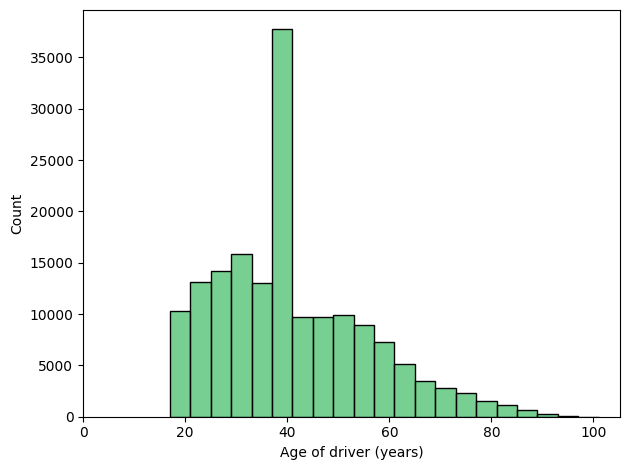

In [83]:
#Use histogram to plot age_of_driver
age_of_driver_distribution = plot_series_distribution(vehicle_df, 'age_of_driver', bins=age_bins, bin_width=bin_width, xlabel='Age of driver (years)', color_index=4)

Largest number of drivers involved in accidents, by some margin are those in their late 30s to early 40s.

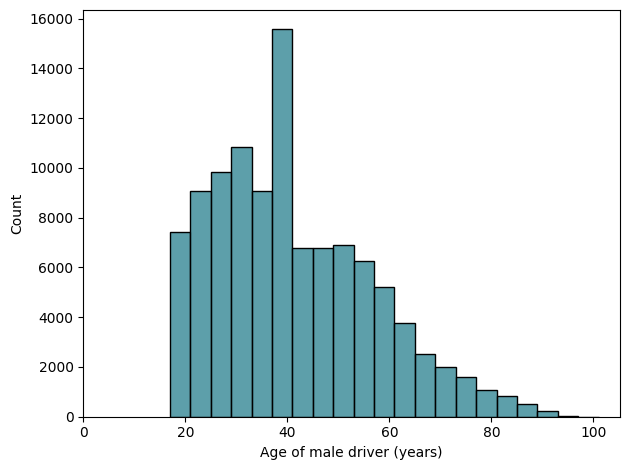

In [84]:
#Histogram of male driver ages
#Pull out only male records, classed as 1 in dataframe column sex_of_driver
male_driver_age = vehicle_df[(vehicle_df['sex_of_driver'] == 1)]

male_age_driver = plot_series_distribution(male_driver_age, 'age_of_driver', bins=age_bins, bin_width=bin_width, xlabel='Age of male driver (years)', color_index=2)

In [85]:
#Total count of drivers
total_count_vehicle_df = len(vehicle_df)

#Count of male drivers
male_count_drivers = len(male_driver_age)

#Percentage of male drivers
male_percentage_drivers = (male_count_drivers / total_count_vehicle_df) * 100

print(f"Count of male drivers: {male_count_drivers}")
print(f"Percentage of male drivers: {male_percentage_drivers:.2f}%")

Count of male drivers: 106253
Percentage of male drivers: 63.48%


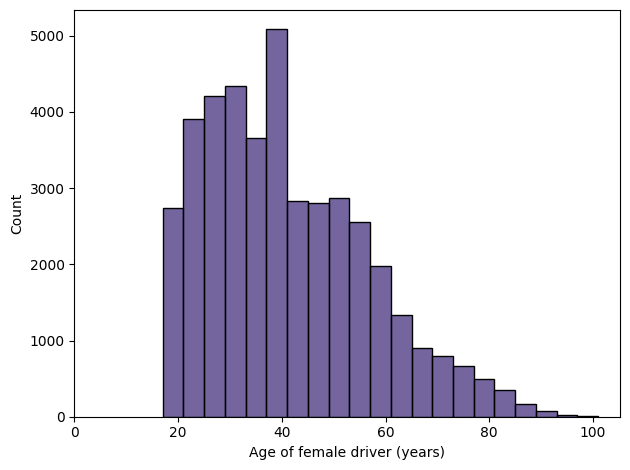

In [86]:
#Histogram of female driver ages
#Pull out only female records, classed as 2 in dataframe column sex_of_driver
female_driver_age = vehicle_df[(vehicle_df['sex_of_driver'] == 2)]
female_age_driver = plot_series_distribution(female_driver_age, 'age_of_driver', bins=age_bins, bin_width=bin_width, xlabel='Age of female driver (years)', color_index=0)

In [87]:
#Count of female drivers
female_count_drivers = len(female_driver_age)

#Percentage of female drivers
female_percentage_drivers = (female_count_drivers / total_count_vehicle_df) * 100

print(f"Count of female drivers: {female_count_drivers}")
print(f"Percentage of female drivers: {female_percentage_drivers:.2f}%")

Count of female drivers: 41820
Percentage of female drivers: 24.99%


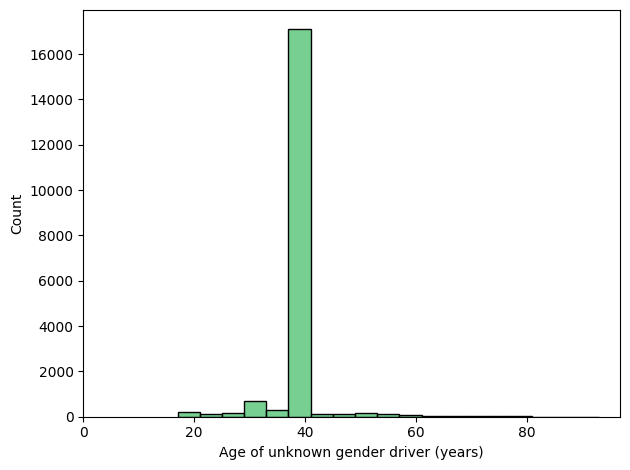

In [88]:
#Histogram of unknown gender driver ages
#Pull out only unknown records, classed as 3 in dataframe column sex_of_driver
unknown_gender_driver_age = vehicle_df[(vehicle_df['sex_of_driver'] == 3)]
unknown_gender_age_driver = plot_series_distribution(unknown_gender_driver_age, 'age_of_driver', bins=age_bins, bin_width=bin_width, xlabel='Age of unknown gender driver (years)', color_index=4)

In [89]:
#Count of unknown gender drivers
unknown_gender_count_drivers = len(unknown_gender_driver_age)

#Percentage of unknown_gender drivers
unknown_gender_percentage_drivers = (unknown_gender_count_drivers / total_count_vehicle_df) * 100

print(f"Count of unknown gender drivers: {unknown_gender_count_drivers}")
print(f"Percentage of unknown gender drivers: {unknown_gender_percentage_drivers:.2f}%")

Count of unknown gender drivers: 19302
Percentage of unknown gender drivers: 11.53%


In [90]:
def plot_percentage_barplot(labels, values, xlabel=None, ylabel=None, palette='viridis', rotation=0):
    """
    Plot a bar plot showing the percentage of drivers for each gender category.

    Parameters:
    labels (list): List of labels for the x-axis.
    values (list): List of percentages corresponding to each label.
    xlabel (str, optional): Label for the x-axis. Default is None (uses variable name).
    ylabel (str, optional): Label for the y-axis. Default is None (uses variable name).
    palette (str or list, optional): Color palette for the plot. Default is 'viridis'.
    
    Returns:
    fig (matplotlib.figure.Figure): The generated matplotlib figure.
    """
    #Plot a bar plot
    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(x=labels, y=values, palette=palette, ax=ax)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)

    #Display the percentages on top of the bars
    for i, percentage in enumerate(values):
        plt.text(i, percentage, f'{percentage:.2f}%', ha='center', va='bottom')

    plt.tight_layout()
    
    return fig

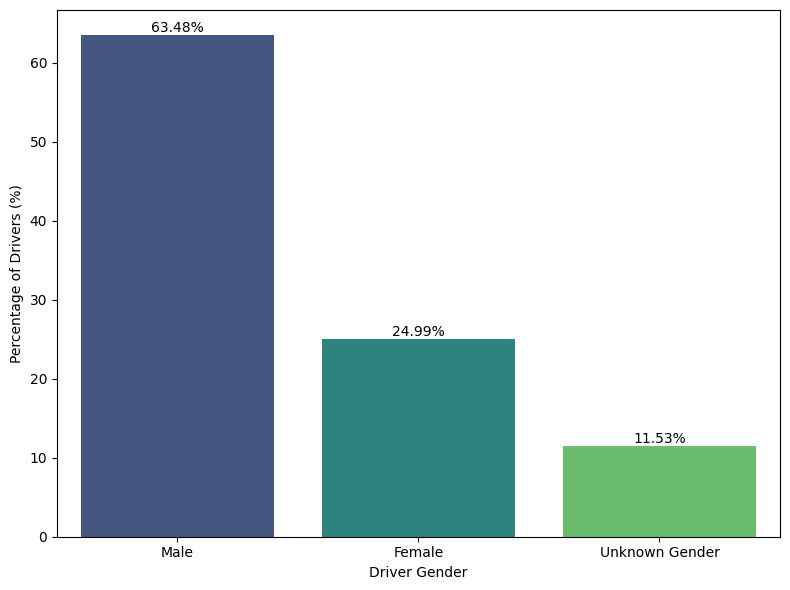

In [91]:
#Define the driver labels and percentages
driver_gender_labels = ['Male', 'Female', 'Unknown Gender']
driver_percentages = [male_percentage_drivers, female_percentage_drivers, unknown_gender_percentage_drivers]

#Plot the percentage bar plot for driver gender
percentage_gender_drivers = plot_percentage_barplot(driver_gender_labels, driver_percentages, xlabel='Driver Gender', ylabel='Percentage of Drivers (%)')

Majority of drivers involved in accidents are male, a quarter are female, and 12% are of unknown gender.

In [92]:
def plot_age_pyramid_gender_driver(male_df, female_df):
    """
    Plot an age pyramid colored by gender for drivers.

    Parameters:
    male_df (pd.DataFrame): DataFrame containing male population data.
    female_df (pd.DataFrame): DataFrame containing female population data.

    Returns:
    fig (matplotlib.figure.Figure): The generated matplotlib figure.
    """
    #Define age bins and labels
    age_bins = [17, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, float('inf')]
    age_labels = ['17-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+']

    #Make copy of dfs and then group individuals aged 85 and over into one group
    male_df = male_df.copy()
    female_df = female_df.copy()
    male_df.loc[male_df['age_of_driver'] >= 85, 'age_of_driver'] = 85
    female_df.loc[female_df['age_of_driver'] >= 85, 'age_of_driver'] = 85

    #Assign age groups based on bins and labels
    male_df['Age Group'] = pd.cut(male_df['age_of_driver'], bins=age_bins, labels=age_labels, right=False)
    female_df['Age Group'] = pd.cut(female_df['age_of_driver'], bins=age_bins, labels=age_labels, right=False)

    #Count people in each age group for males and females
    count_by_agegroup_m = male_df.groupby('Age Group').size().reset_index(name='Count of Males')
    count_by_agegroup_f = female_df.groupby('Age Group').size().reset_index(name='Count of Females')
    
    #Rename columns
    count_by_agegroup_m.columns = ['Age Group', 'Count of Males']
    count_by_agegroup_f.columns = ['Age Group', 'Count of Females']

    #Create df with negative male counts for pyramid plotting
    count_by_agegroup_m_minus1 = count_by_agegroup_m.copy()
    count_by_agegroup_m_minus1['Count of Males'] *= -1

    #Merge dfs on Age Group
    count_by_agegroup = pd.merge(count_by_agegroup_m_minus1, count_by_agegroup_f, on='Age Group')
    
    #Plot the age pyramid
    fig, ax = plt.subplots(figsize=(8, 6))
    age_pyramid = sns.barplot(x='Count of Males', y='Age Group', data=count_by_agegroup,
                              order=count_by_agegroup['Age Group'][::-1], color=sns.color_palette('viridis')[3], label='Male', ax=ax)
    sns.barplot(x='Count of Females', y='Age Group', data=count_by_agegroup,
                order=count_by_agegroup['Age Group'][::-1], color=sns.color_palette('viridis')[1], label='Female', ax=ax)

    plt.xlabel('Driver Count')
    plt.ylabel('Age Group (years)')
    plt.legend()
    plt.tight_layout()
    
    return fig

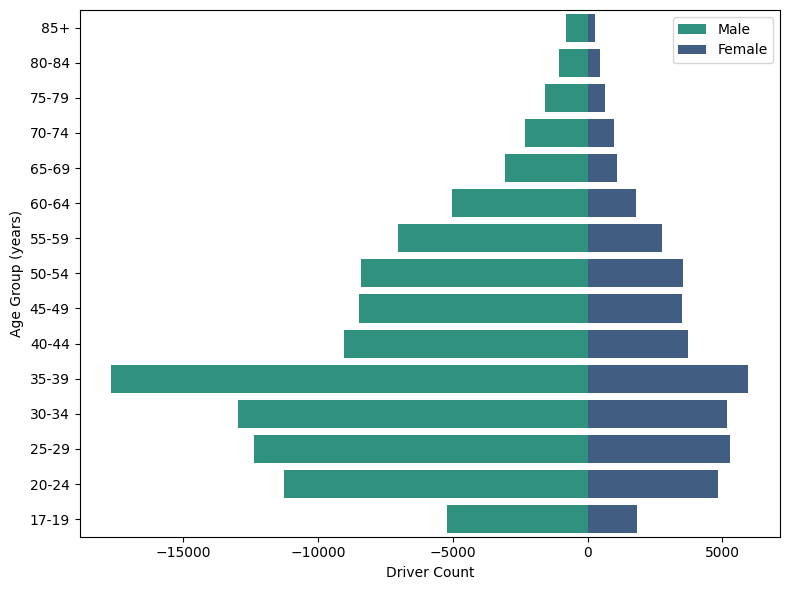

In [93]:
pyramid_male_female_driver = plot_age_pyramid_gender_driver(male_driver_age, female_driver_age)

*Summary of age of driver*

Thre are more male drivers than female involved in accidents.
Largest number of drivers involved in accidents, by some margin are those in their late 30s.
Early 20s to mid-30s also highly susceptible to be involved in an accident.

*Age of casualty*

sex_of_casualty key for casualty_df:
male = 1
female = 2

In [94]:
#Use summary stats function on age_of_casualty
age_of_casualty_stats = summary_stats_with_iqr(casualty_df, 'age_of_casualty')
age_of_casualty_stats

count    115584.0
mean         37.7
std          17.8
min           0.0
25%          24.0
50%          35.0
75%          50.0
max          99.0
IQR          26.0
Name: age_of_casualty, dtype: float64

Minimum age of casualty is 0 years old, maximum age is 99 years old. Mean age is 37.2.

In [95]:
#Define the age bins and ranges
age_bins_2 = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105]
age_labels_2 = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100-104']

#Create a new column in vehicle_df to store age groups
casualty_df['Age Group'] = pd.cut(casualty_df['age_of_casualty'], bins=age_bins_2, labels=age_labels_2, right=False, include_lowest=True)

#Set a fixed width for the bins
bin_width_2 = age_bins_2[1] - age_bins_2[0]

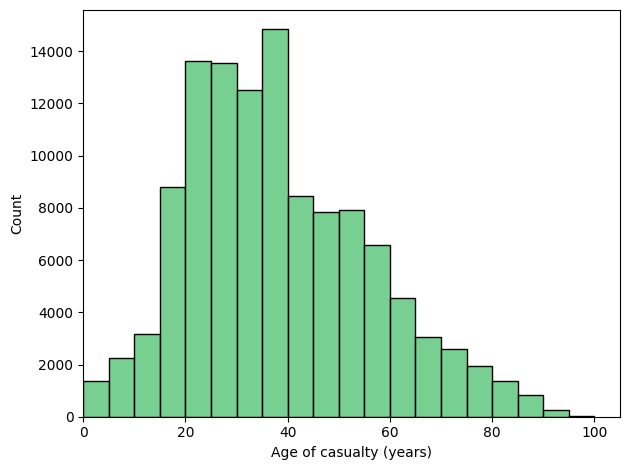

In [96]:
#Use histogram to plot age_of_casualty
age_of_casualty_distribution = plot_series_distribution(casualty_df, 'age_of_casualty', bins=age_bins_2, bin_width=bin_width_2, xlabel='Age of casualty (years)', color_index=4)

Most casualties occur between 20 and 35 years old.

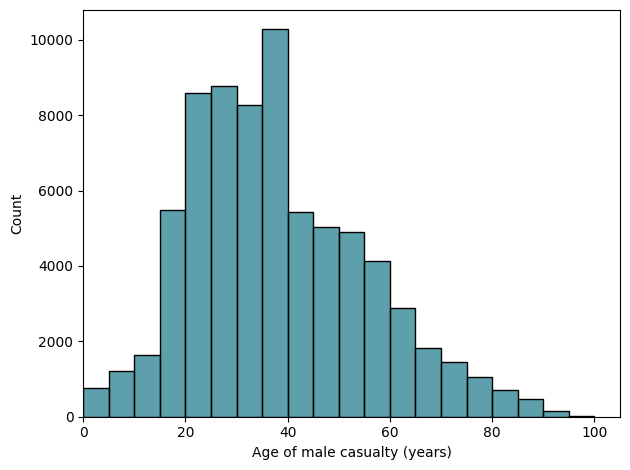

In [97]:
#Histogram of male casualty ages
#Pull out only male records, classed as 1 in dataframe column sex_of_casualty
male_casualty_age = casualty_df[(casualty_df['sex_of_casualty'] == 1)]

male_age_casualty = plot_series_distribution(male_casualty_age, 'age_of_casualty', bins=age_bins_2, bin_width=bin_width_2, xlabel='Age of male casualty (years)', color_index=2)

Higher number of male casualties from teens to 40 years old.

In [98]:
#Total count of casualties
total_count_casualty_df = len(casualty_df)

#Count of male casualties
male_count_casualties = len(male_casualty_age)

#Percentage of male casualties
male_percentage_casualties = (male_count_casualties / total_count_casualty_df) * 100

print(f"Count of male casualties: {male_count_casualties}")
print(f"Percentage of male casualties: {male_percentage_casualties:.2f}%")

Count of male casualties: 73091
Percentage of male casualties: 63.24%


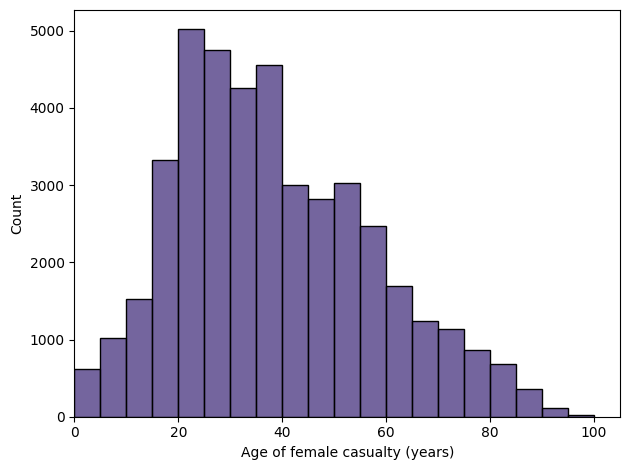

In [99]:
#Histogram of female casualty ages
#Pull out only female records, classed as 1 in dataframe column sex_of_casualty
female_casualty_age = casualty_df[(casualty_df['sex_of_casualty'] == 2)]

female_age_casualty = plot_series_distribution(female_casualty_age, 'age_of_casualty', bins=age_bins_2, bin_width=bin_width_2, xlabel='Age of female casualty (years)', color_index=0)

Highest number of female casualties between 20 and late 30s.

In [100]:
#Count of female casualties
female_count_casualties = len(female_casualty_age)

#Percentage of female casualties
female_percentage_casualties = (female_count_casualties / total_count_casualty_df) * 100

print(f"Count of female casualties: {female_count_casualties}")
print(f"Percentage of female casualties: {female_percentage_casualties:.2f}%")

Count of female casualties: 42488
Percentage of female casualties: 36.76%


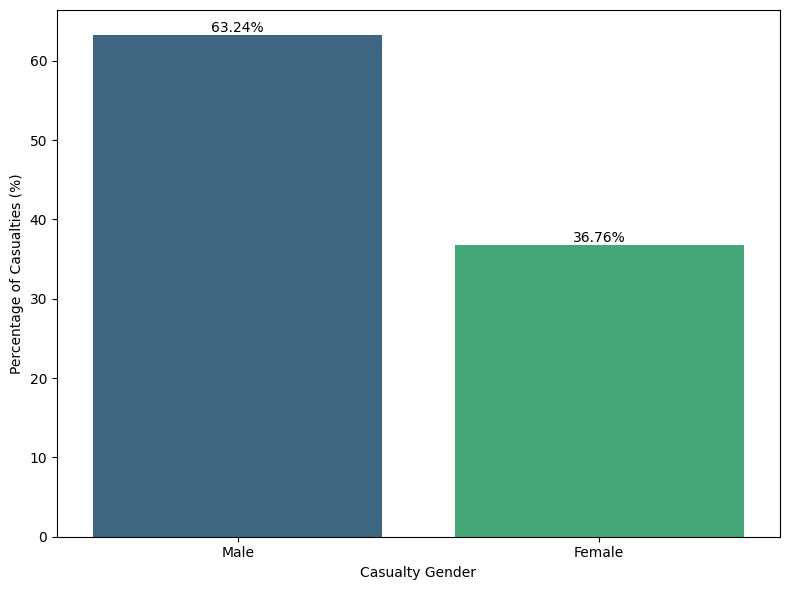

In [101]:
#Define the casualty labels and percentages
casualty_gender_labels = ['Male', 'Female']
casualty_percentages = [male_percentage_casualties, female_percentage_casualties]

#Plot the percentage bar plot for driver gender
percentage_gender_casualties = plot_percentage_barplot(casualty_gender_labels, casualty_percentages, xlabel='Casualty Gender', ylabel='Percentage of Casualties (%)')

Majority of casualties are male.

In [102]:
def plot_age_pyramid_gender_casualties(male_df, female_df):
    """
    Plot an age pyramid colored by gender for casualties.

    Parameters:
    male_df (pd.DataFrame): DataFrame containing male population data.
    female_df (pd.DataFrame): DataFrame containing female population data.

    Returns:
    fig (matplotlib.figure.Figure): The generated matplotlib figure.
    """
    #Define age bins and labels
    age_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, float('inf')]
    age_labels = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+']

    #Make copy of dfs and then group individuals aged 85 and over into one group
    male_df = male_df.copy()
    female_df = female_df.copy()
    male_df.loc[male_df['age_of_casualty'] >= 85, 'age_of_casualty'] = 85
    female_df.loc[female_df['age_of_casualty'] >= 85, 'age_of_casualty'] = 85

    #Assign age groups based on bins and labels
    male_df['Age Group'] = pd.cut(male_df['age_of_casualty'], bins=age_bins, labels=age_labels, right=False)
    female_df['Age Group'] = pd.cut(female_df['age_of_casualty'], bins=age_bins, labels=age_labels, right=False)

    #Count people in each age group for males and females
    count_by_agegroup_m = male_df.groupby('Age Group').size().reset_index(name='Count of Males')
    count_by_agegroup_f = female_df.groupby('Age Group').size().reset_index(name='Count of Females')
    
    #Rename columns
    count_by_agegroup_m.columns = ['Age Group', 'Count of Males']
    count_by_agegroup_f.columns = ['Age Group', 'Count of Females']

    #Create df with negative male counts for pyramid plotting
    count_by_agegroup_m_minus1 = count_by_agegroup_m.copy()
    count_by_agegroup_m_minus1['Count of Males'] *= -1

    #Merge dfs on Age Group
    count_by_agegroup = pd.merge(count_by_agegroup_m_minus1, count_by_agegroup_f, on='Age Group')
    
    #Plot the age pyramid
    fig, ax = plt.subplots(figsize=(8, 6))
    age_pyramid = sns.barplot(x='Count of Males', y='Age Group', data=count_by_agegroup,
                              order=count_by_agegroup['Age Group'][::-1], color=sns.color_palette('viridis')[3], label='Male', ax=ax)
    sns.barplot(x='Count of Females', y='Age Group', data=count_by_agegroup,
                order=count_by_agegroup['Age Group'][::-1], color=sns.color_palette('viridis')[1], label='Female', ax=ax)

    plt.xlabel('Casualty Count')
    plt.ylabel('Age Group (years)')
    plt.legend()
    plt.tight_layout()
    
    return fig

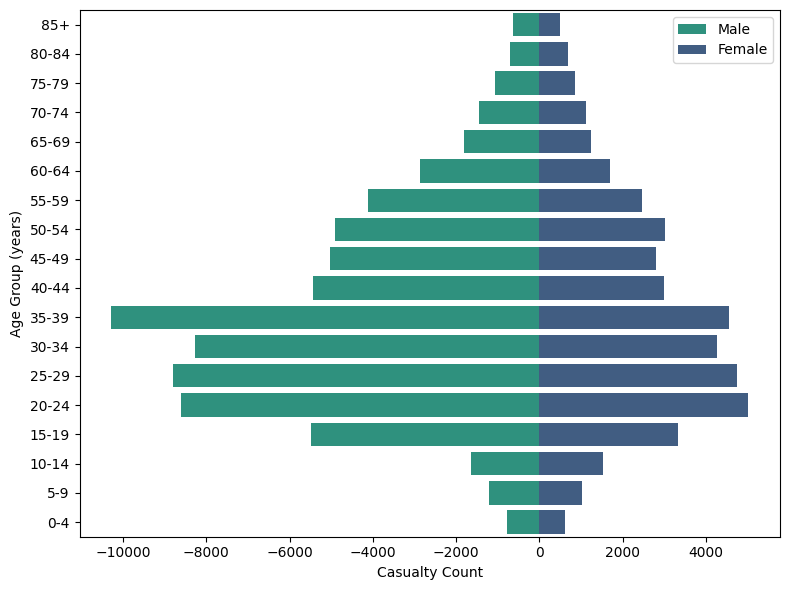

In [103]:
pyramid_male_female_casualties = plot_age_pyramid_gender_casualties(male_casualty_age, female_casualty_age)

*Summary of age of casualties*

There are more male casualties and male drivers compared to females. 
Most casualties occur between 20 and 39 years old.

*Summary of age*

Thre are more male drivers and casualties than female.
The driver and casualty age groups most susceptible to accidents was between 20 and 39 years.

*Casualty severity alone and by gender/age, casualty class (driver/rider, passenger, pedestrian) and vehicle_type*

sex_of_casualty key for casualty_df:
male = 1
female = 2

casualty_class key for casualty_df:
driver or rider = 1
passenger = 2
pedestrian = 3

casualty_severity key for casualty_df:
fatal = 1
serious = 2
slight = 3

vehicle_type key for vehicle_df:
1: Pedal cycle
2: M/cycle 50cc and under
3: M/cycle over 50cc and up to 125cc 
4: M/cycle over 125cc and up to 500cc
5: Motorcycle over 500cc
8: Taxi/Private hire car
9: Car
10: Minibus (8-16 passenger seats) 
11: Bus or coach 
16: Ridden horse
17: Agricultural vehicle 
18: Tram/Light rail
19: Van 
20: Goods vehicle over 3.5 tonnes and under 7.5 tonnes mgw
21: Goods vehicle 7.5 tonnes mgw & over 
22: Mobility scooter
23: Electric Motorcycle
90: Other
97: Motorcycle - cc unknown', 98: 'Goods vehicle - unknown weight

In [104]:
#Determine percentage of slight, serious and fatal accidents of total casualties
#Calculate the total number of casualties
total_casualties = len(casualty_df)

#Create dfs for each casualty severity category
fatal_casualties = casualty_df[casualty_df['casualty_severity'] == 1]
serious_casualties = casualty_df[casualty_df['casualty_severity'] == 2]
slight_casualties = casualty_df[casualty_df['casualty_severity'] == 3]

#Calculate the number of casualties for each severity category
fatal_count = len(fatal_casualties)
serious_count = len(serious_casualties)
slight_count = len(slight_casualties)

#Calculate the percentage of each severity category
fatal_percentage = (fatal_count / total_casualties) * 100
serious_percentage = (serious_count / total_casualties) * 100
slight_percentage = (slight_count / total_casualties) * 100

print(f"Percentage of Fatal Casualties: {fatal_percentage:.2f}%")
print(f"Percentage of Serious Casualties: {serious_percentage:.2f}%")
print(f"Percentage of Slight Casualties: {slight_percentage:.2f}%")

Percentage of Fatal Casualties: 1.26%
Percentage of Serious Casualties: 17.39%
Percentage of Slight Casualties: 81.35%


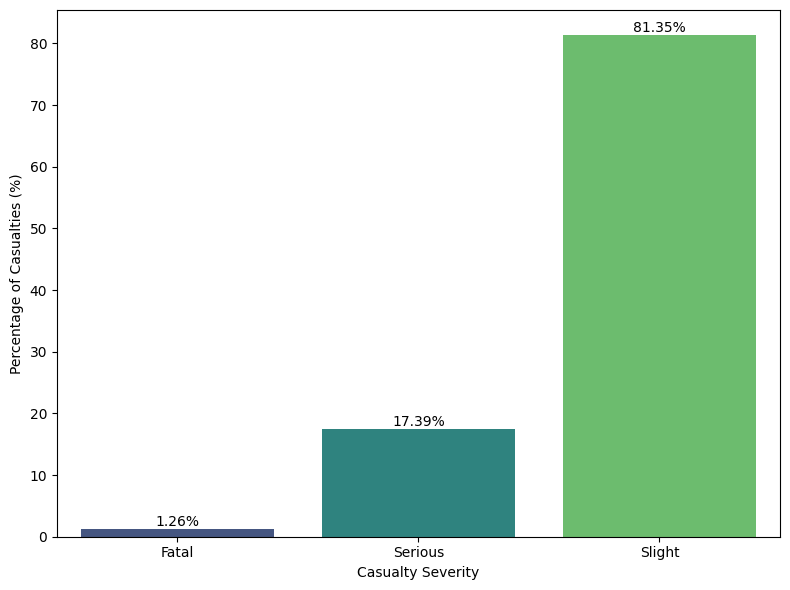

In [105]:
#Plot the percentages in a bar plot
severity_labels = ['Fatal', 'Serious', 'Slight']
severity_percentages = [fatal_percentage, serious_percentage, slight_percentage]

percentage_casualty_severity = plot_percentage_barplot(severity_labels, severity_percentages, xlabel='Casualty Severity', ylabel='Percentage of Casualties (%)')

Less than 2% of casualties are fatal. 81% are slight or minor.

*Casualty severity by age group for each casualty class*

In [106]:
#Filter casualty_df for casualty class 1 (driver or rider)
casualty_class_driver_rider = casualty_df[casualty_df['casualty_class'] == 1]

#Filter casualty_df for casualty class 2 (passenger)
casualty_class_passenger = casualty_df[casualty_df['casualty_class'] == 2]

#Filter casualty_df for casualty class 3 (pedestrian)
casualty_class_pedestrian = casualty_df[casualty_df['casualty_class'] == 3]

In [279]:
#Function to plot accident severity by age group
def plot_accident_severity_by_age_group(filtered_casualty_df, ylabel=None):
    """
    Plot accident severity by age group.

    Parameters:
    filtered_casualty_df (pd.DataFrame): Filtered DataFrame containing casualty data for casualty class 1 (driver or rider), including 'Age Group' and 'Casualty Severity' columns.

    Returns:
    fig (matplotlib.figure.Figure): The generated matplotlib figure.
    
    """
    #Make a copy of the filtered df
    filtered_casualty_df = filtered_casualty_df.copy()
    
    #Define the mapping of casualty severity codes to their corresponding labels
    severity_labels = {1: 'Fatal', 2: 'Serious', 3: 'Slight'}

    #Map the severity codes to labels
    filtered_casualty_df['casualty_severity'] = filtered_casualty_df['casualty_severity'].map(severity_labels)

    #Group the data by age group and accident severity, then calculate the count of accidents
    accident_counts = filtered_casualty_df.groupby(['Age Group', 'casualty_severity']).size().reset_index(name='Count')

    #Plot the data
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x='Age Group', y='Count', hue='casualty_severity', data=accident_counts, palette='viridis', ax=ax)
    plt.xlabel('Age Group (years)')
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend(title='Casualty Severity')

    plt.tight_layout()

    return fig

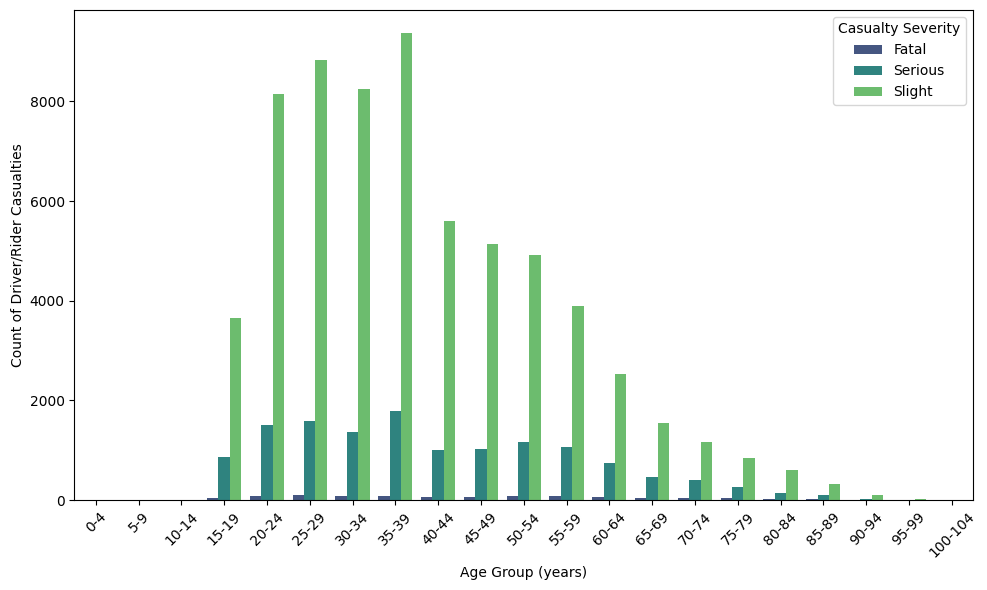

In [280]:
#Run function for driver/rider casualties
casualty_severity_age_driver_rider = plot_accident_severity_by_age_group(casualty_class_driver_rider, ylabel='Count of Driver/Rider Casualties')

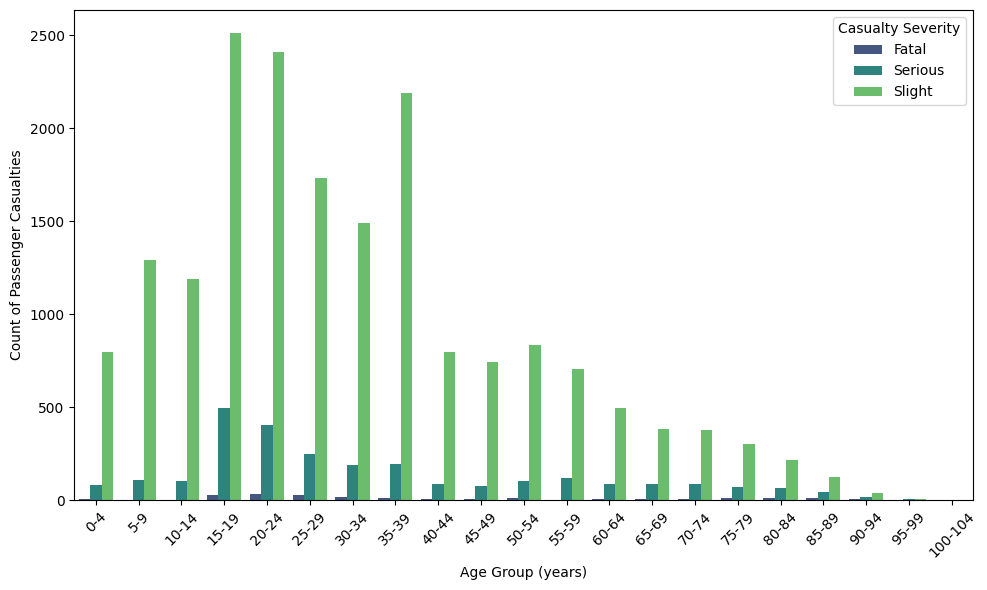

In [281]:
#Run function for passenger casualties
casualty_severity_age_passenger = plot_accident_severity_by_age_group(casualty_class_passenger, ylabel='Count of Passenger Casualties')

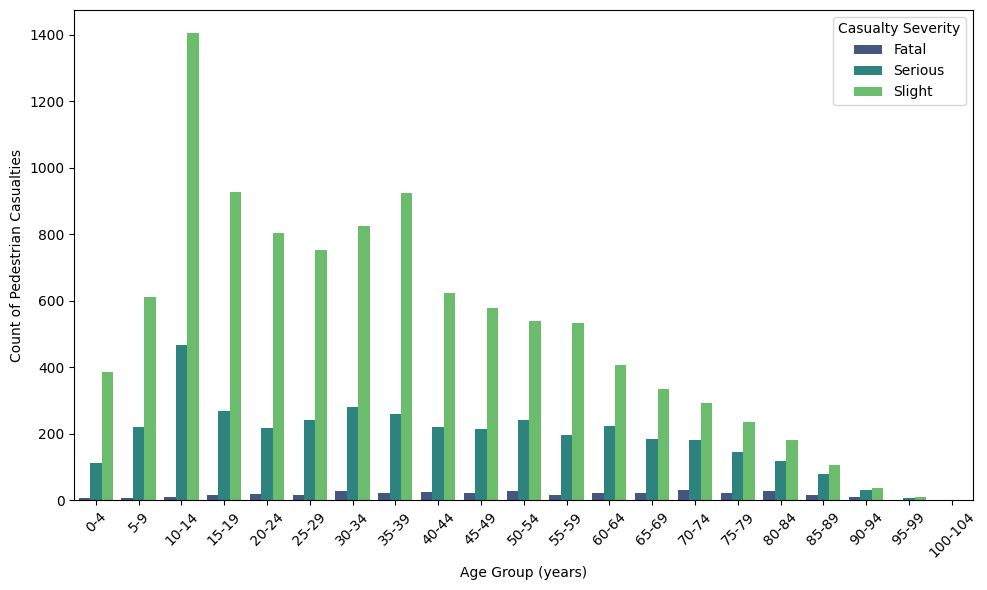

In [282]:
#Run function for pedestrian casualties
casualty_severity_age_pedestrian = plot_accident_severity_by_age_group(casualty_class_pedestrian, ylabel='Count of Pedestrian Casualties')

Most accidents/casualties are slight for all casualty classes (driver/rider, passenger, pedestrian).
Serious accidents are more prevalent for driver/riders between the ages of 20 to 39 years which correlates with the number of casualties being higher for these age groups.
Higher serious accidents occur to 15-19 year old passengers and 10-14 year old pedestrians.

*Casualty severity by gender for all casualties and each casualty class*

In [111]:
#Function to plot accident severity by gender
def plot_casualty_severity_by_gender(df, ylabel=None):
    """
    Plot casualty severity by gender of casualty.

    Parameters:
    df (pd.DataFrame): DataFrame containing casualty data, including 'sex_of_casualty' and 'casualty_severity' columns.
    ylabel (str): Label for the y-axis.

    Returns:
    fig (matplotlib.figure.Figure): The generated matplotlib figure.
    """
    #Make a copy of the DataFrame
    df = df.copy()
    
    #Map gender categories to labels
    gender_labels = {1: 'Male', 2: 'Female'}
    df['sex_of_casualty'] = df['sex_of_casualty'].map(gender_labels)

    #Define the mapping of casualty severity codes to their corresponding labels
    severity_labels = {1: 'Fatal', 2: 'Serious', 3: 'Slight'}

    #Map the severity codes to labels
    df['casualty_severity'] = df['casualty_severity'].map(severity_labels)

    #Group the data by sex of casualty and accident severity, then calculate the count of accidents
    accident_counts = df.groupby(['sex_of_casualty', 'casualty_severity']).size().reset_index(name='Count')

    #Plot the data
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(x='sex_of_casualty', y='Count', hue='casualty_severity', data=accident_counts, palette='viridis', ax=ax)
    plt.xlabel('Casualty Gender')
    plt.ylabel(ylabel if ylabel else 'Count of Casualties')
    plt.xticks(rotation=45)
    plt.legend(title='Casualty Severity')

    plt.tight_layout()

    return fig

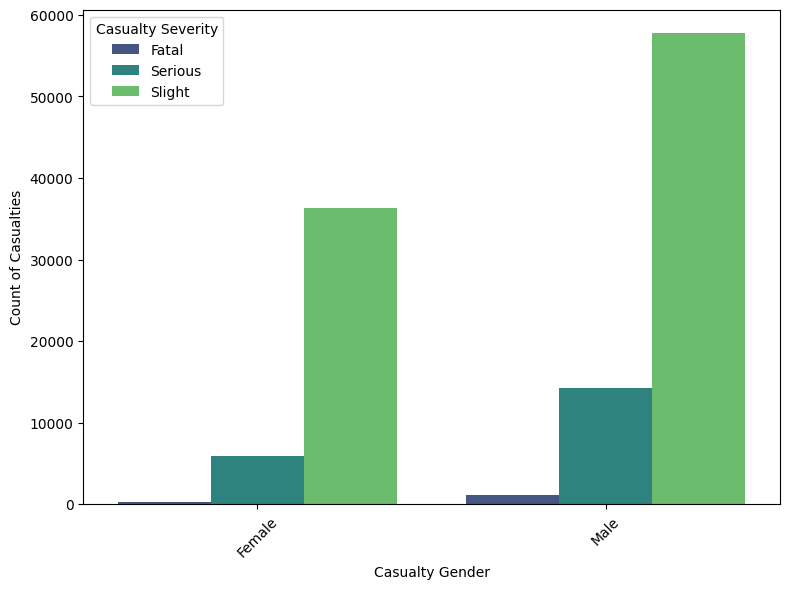

In [112]:
#Run for all casualties in casualty_df
casualty_severity_by_gender = plot_casualty_severity_by_gender(casualty_df)

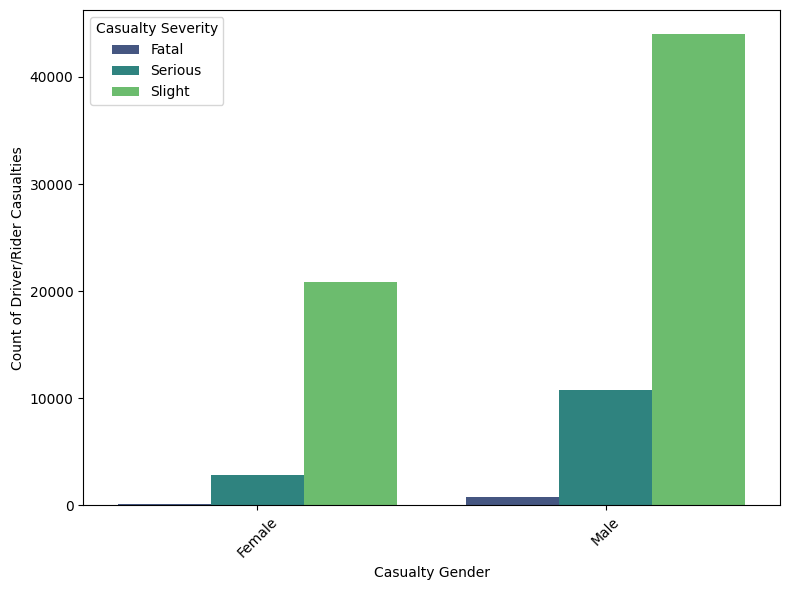

In [113]:
#Plot casualty severity for rider/drivers
casualty_severity_by_gender_rider_driver = plot_casualty_severity_by_gender(casualty_class_driver_rider, ylabel='Count of Driver/Rider Casualties')

We already know that men are involved in more accideents, but they also have more serious and fatal accidents than women.

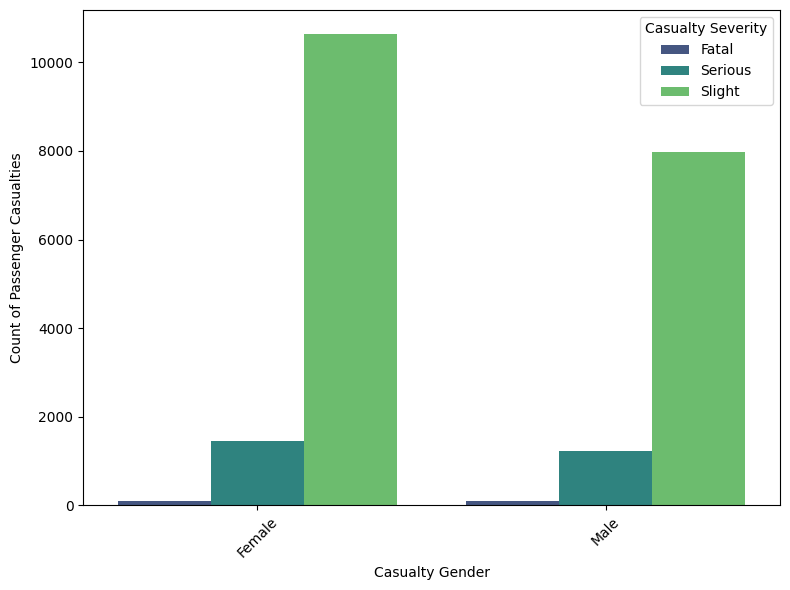

In [114]:
#Plot casualty severity for passengers
casualty_severity_by_gender_passenger = plot_casualty_severity_by_gender(casualty_class_passenger, ylabel='Count of Passenger Casualties')

There are more female passenger casualties than men, which correlates with more men drivers being involved in accidents.

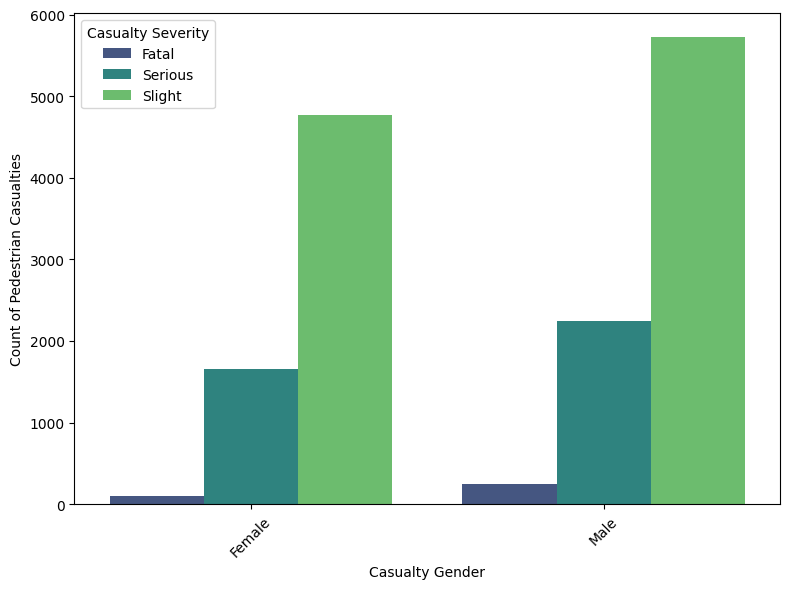

In [115]:
#Plot casualty severity for pedestrians
casualty_severity_by_gender_pedestrian = plot_casualty_severity_by_gender(casualty_class_pedestrian, ylabel='Count of Pedestrian Casualties')

There are more men pedestrian casualties than women but the data is more balanced.

*Count of total accidents by vehicle type*

In [116]:
def plot_total_accidents_by_vehicle_type(df):
    """
    Plot total accidents by vehicle type.

    Parameters:
    df (pd.DataFrame): DataFrame containing accident data with 'vehicle_type' column.

    Returns:
    fig (matplotlib.figure.Figure): The generated matplotlib figure.
    """ 
    #Make a copy of the DataFrame
    df = df.copy()
    
    #Define a dictionary to map numeric vehicle type labels to their string representations
    vehicle_type_labels = {
        1: 'Pedal cycle',
        2: 'M/cycle 50cc and under',
        3: 'M/cycle over 50cc to 125cc',
        4: 'M/cycle over 125cc to 500cc',
        5: 'Motorcycle over 500cc',
        8: 'Taxi/Private hire car',
        9: 'Car',
        10: 'Minibus',
        11: 'Bus or coach',
        16: 'Ridden horse',
        17: 'Agricultural vehicle',
        18: 'Tram/Light rail',
        19: 'Van',
        20: 'Goods vehicle over 3.5 to 7.5 tonnes mgw',
        21: 'Goods vehicle 7.5 tonnes mgw & over',
        22: 'Mobility scooter',
        23: 'Electric Motorcycle',
        90: 'Other',
        97: 'Motorcycle - cc unknown',
        98: 'Goods vehicle - unknown weight'
    }
    
    #Map numeric vehicle type labels to string representations
    df['vehicle_type'] = df['vehicle_type'].map(vehicle_type_labels)

    #Count the occurrences of each vehicle type
    vehicle_type_counts = df['vehicle_type'].value_counts().sort_values(ascending=False)

    fig = plt.figure(figsize=(10, 8))
    sns.countplot(x='vehicle_type', data=df, order=vehicle_type_counts.index, palette='viridis')
    plt.xlabel('Vehicle Type')
    plt.ylabel('Count of Accidents')
    plt.xticks(rotation=70, ha='right')
    plt.tight_layout()
    
    return fig

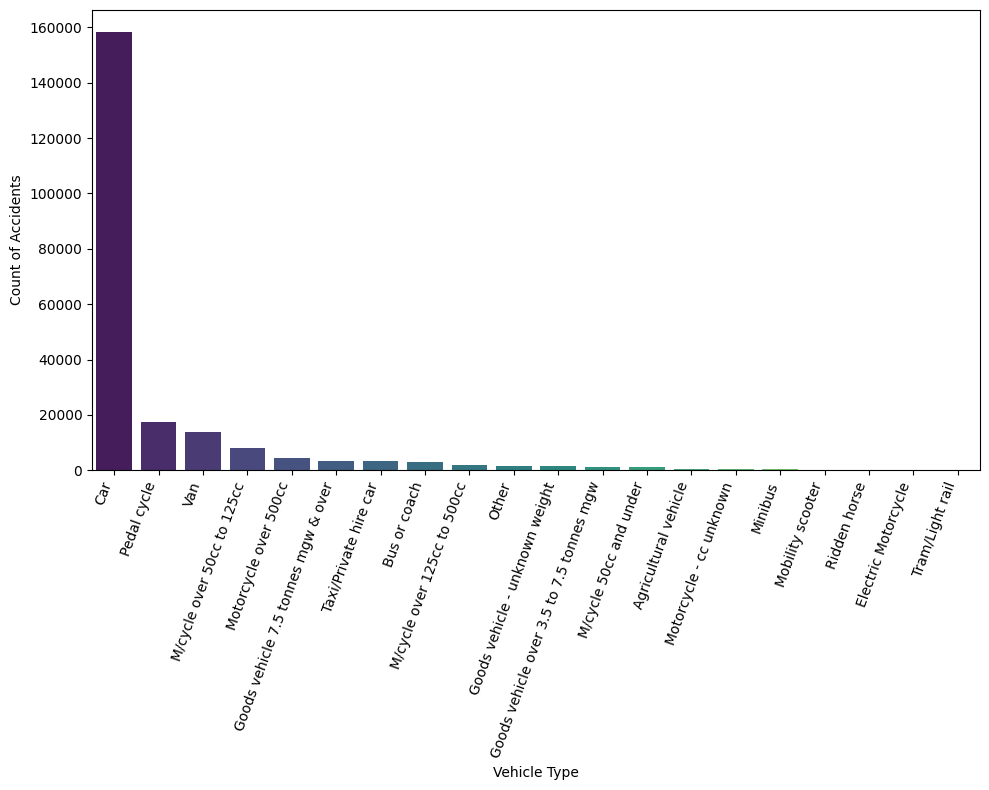

In [117]:
accident_vehicle_type = plot_total_accidents_by_vehicle_type(merged_df)

Cars are involved in the most accidents, followed by pedal cycles. Motorcycles up to 125cc and over 500cc of all mototrbike categories are also invovled in the most accidents. This highlights these motorcycle types in particular, along with pedal cycles where saftey could be increased or considered.

*Fatal casualties by vehicle type*

Determine fatal casualties (Casualty_df) associated with vehicle_types (vehicle_df). Need to use merged_df to determine.

In [118]:
def plot_fatal_casualties_by_vehicle_type(df):
    """
    Plot fatal casualties by vehicle type.

    Parameters:
    df (pd.DataFrame): DataFrame containing casualty data with 'vehicle_type' and 'casualty_severity' columns.

    Returns:
    fig (matplotlib.figure.Figure): The generated matplotlib figure.
    """ 
    #Make a copy of the DataFrame
    df = df.copy()
    
    #Define a dictionary to map numeric vehicle type labels to their string representations
    vehicle_type_labels = {
        1: 'Pedal cycle',
        2: 'M/cycle 50cc and under',
        3: 'M/cycle over 50cc to 125cc',
        4: 'M/cycle over 125cc to 500cc',
        5: 'Motorcycle over 500cc',
        8: 'Taxi/Private hire car',
        9: 'Car',
        10: 'Minibus',
        11: 'Bus or coach',
        16: 'Ridden horse',
        17: 'Agricultural vehicle',
        18: 'Tram/Light rail',
        19: 'Van',
        20: 'Goods vehicle over 3.5 to 7.5 tonnes mgw',
        21: 'Goods vehicle 7.5 tonnes mgw & over',
        22: 'Mobility scooter',
        23: 'Electric Motorcycle',
        90: 'Other',
        97: 'Motorcycle - cc unknown',
        98: 'Goods vehicle - unknown weight'
    }
    
    #Filter dataframe to include only fatal casualties
    fatal_casualties_df = df[df['casualty_severity'] == 1]

    #Map numeric vehicle type labels to string representations
    fatal_casualties_df.loc[:, 'vehicle_type'] = fatal_casualties_df['vehicle_type'].map(vehicle_type_labels)
    
    #Get the order of vehicle types by their counts in descending order
    vehicle_type_order = fatal_casualties_df['vehicle_type'].value_counts().index

    fig = plt.figure(figsize=(10, 8))
    sns.countplot(x='vehicle_type', data=fatal_casualties_df, order=vehicle_type_order, palette='viridis')
    plt.xlabel('Vehicle Type')
    plt.ylabel('Count of Fatal Casualties')
    plt.xticks(rotation=70, ha='right')
    plt.tight_layout()
    
    return fig

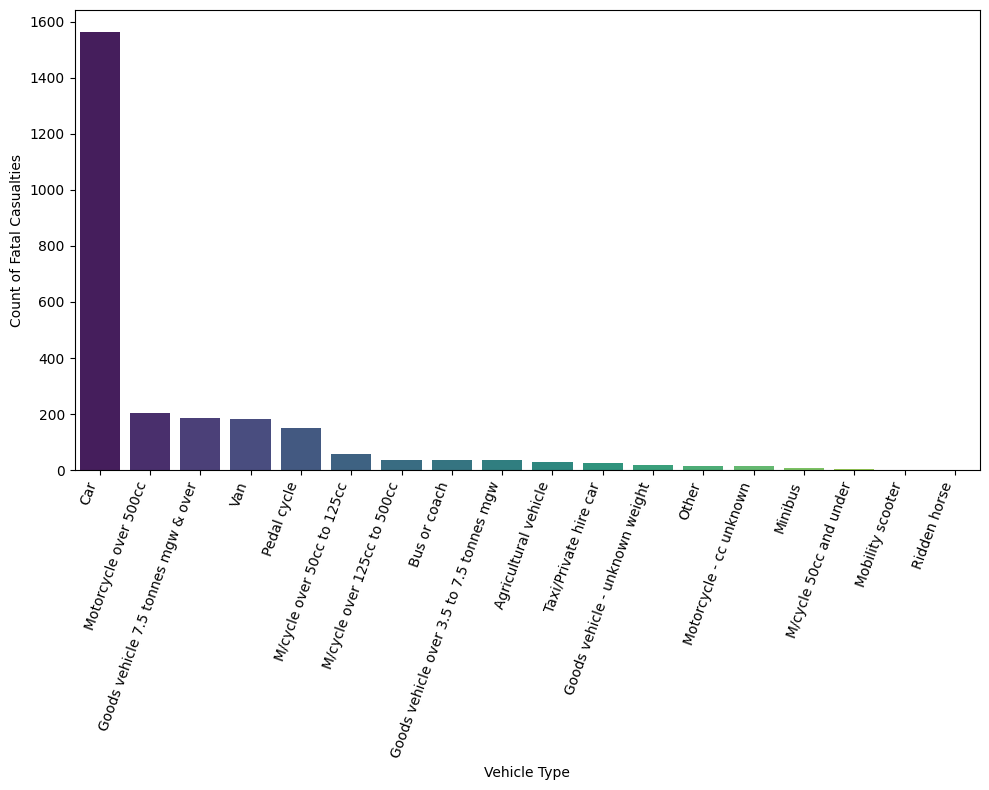

In [119]:
fatal_casualties_vehicle_type = plot_fatal_casualties_by_vehicle_type(merged_df)

Most fatal accidents occur for cars and motorcycles over 500cc. There are approx. 150 fatal pedal cycle accidents.

**Casualty severity of pedal cycle accidents**

Pedal cycle key = 1 in vehicle_type

In [120]:
#Create df for casualty severity 1 and vehicle type 1
fatal_pedal_cycle = merged_df[(merged_df['casualty_severity'] == 1) & (merged_df['vehicle_type'] == 1)]

#Create df for casualty severity 2 and vehicle type 1
serious_pedal_cycle = merged_df[(merged_df['casualty_severity'] == 2) & (merged_df['vehicle_type'] == 1)]

#Create df for casualty severity 3 and vehicle type 1
slight_pedal_cycle = merged_df[(merged_df['casualty_severity'] == 3) & (merged_df['vehicle_type'] == 1)]

In [121]:
#Filter merged_df to include only rows where vehicle_type is 1
vehicle_type_pedal_cycle = merged_df[merged_df['vehicle_type'] == 1]

#Get the total number of accidents where vehicle_type is 1
total_accidents_pedal_cycle = len(vehicle_type_pedal_cycle)

#Count of severity for each class
fatal_count_pedal_cycle = len(fatal_pedal_cycle)
serious_count_pedal_cycle = len(serious_pedal_cycle)
slight_count_pedal_cycle = len(slight_pedal_cycle)

#Calculate the percentage of each severity category
fatal_percentage_pedal_cycle = (fatal_count_pedal_cycle / total_accidents_pedal_cycle) * 100
serious_percentage_pedal_cycle = (serious_count_pedal_cycle / total_accidents_pedal_cycle) * 100
slight_percentage_pedal_cycle = (slight_count_pedal_cycle / total_accidents_pedal_cycle) * 100

print(f"Percentage of Fatal Casualties: {fatal_percentage_pedal_cycle:.2f}%")
print(f"Percentage of Serious Casualties: {serious_percentage_pedal_cycle:.2f}%")
print(f"Percentage of Slight Casualties: {slight_percentage_pedal_cycle:.2f}%")

Percentage of Fatal Casualties: 0.87%
Percentage of Serious Casualties: 23.54%
Percentage of Slight Casualties: 75.59%


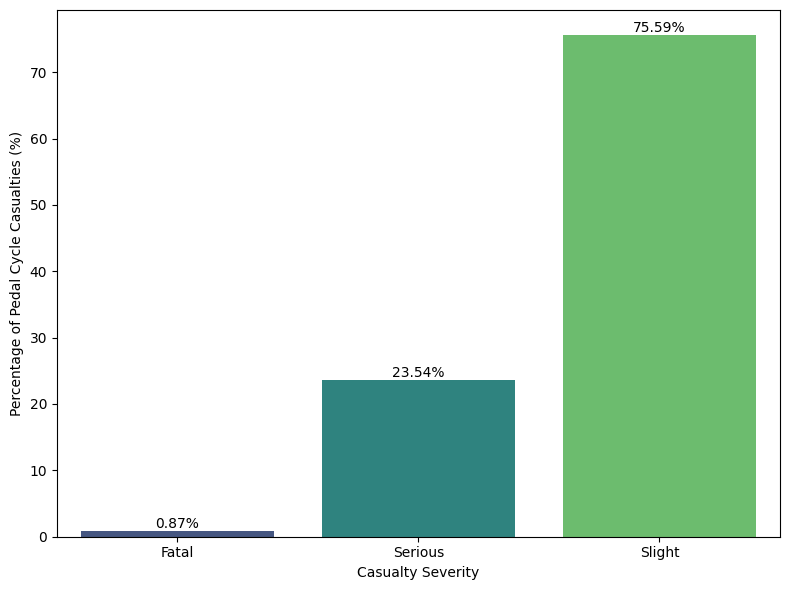

In [122]:
#Plot the percentages in a bar plot
severity_percentages_pedal_cycle = [fatal_percentage_pedal_cycle, serious_percentage_pedal_cycle, slight_percentage_pedal_cycle]

percentage_casualty_severity_pedal_cycle = plot_percentage_barplot(severity_labels, severity_percentages_pedal_cycle, xlabel='Casualty Severity', ylabel='Percentage of Pedal Cycle Casualties (%)')

The number of fatal accidents involving pedal cycles is <1%, however 24% of accidents are serious. Serious accidents could be prevented by increasing cycle safety thourhg awareness campaigns around lights and helmet usage, and increased cycle lanes.

*Casualty variation during the year*

In [123]:
#Group by day of the year and count the occurrences
accidents_by_day_of_year = accident_df.groupby(accident_df['date'].dt.dayofyear).size()

In [124]:
def plot_accidents_by_day_of_year(accidents_by_day_of_year, rolling_average_window=7, color_index=0):
    """
    Plot accidents by day of the year with a rolling average.

    Parameters:
    accidents_by_day_of_year (pd.Series): Series containing the count of accidents indexed by day of the year.
    rolling_average_window (int): Window size for the rolling average.
    color_index (int): Index of the color to be used for plotting.

    Returns:
    fig (matplotlib.figure.Figure): The generated matplotlib figure.
    """
    #Calculate the rolling average of accidents by day using a window size
    rolling_average = accidents_by_day_of_year.rolling(window=rolling_average_window, min_periods=1).mean()

    #Calculate the first day of each month
    first_day_of_month = pd.date_range(start='2020-01-01', periods=12, freq='MS')

    #Create a line plot for count of accidents by day of the year
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(accidents_by_day_of_year.index, accidents_by_day_of_year.values, color=sns.color_palette('viridis')[color_index], linestyle='-', label='Accidents by Day')

    #Plot the rolling average line
    ax.plot(accidents_by_day_of_year.index, rolling_average.values, color='red', linestyle='-', linewidth=0.8, label=f'Rolling Average ({rolling_average_window} days)')

    #Set x-axis ticks and labels for months
    plt.xticks(first_day_of_month.dayofyear, first_day_of_month.strftime('%B'), rotation=45)
    
    #Set x-axis limits to start from January and end at December
    ax.set_xlim(1, 365)

    ax.set_xlabel('Month of the Year 2020')
    ax.set_ylabel('Accident Count')
    ax.legend()
    plt.tight_layout()
    plt.show()

    return fig

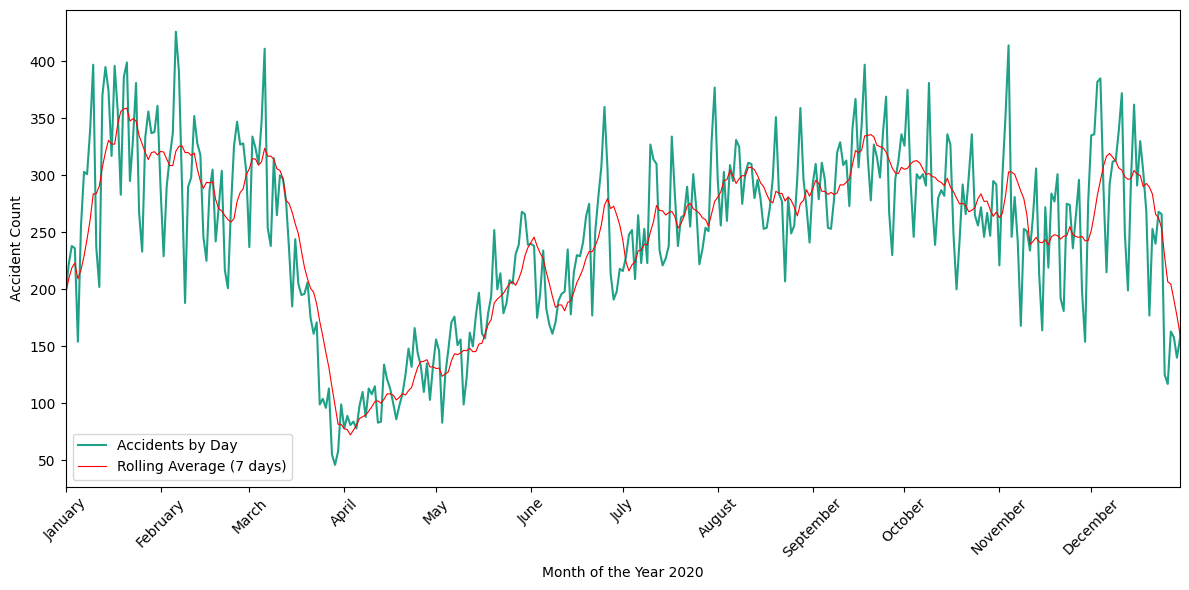

In [125]:
accident_count_days_year = plot_accidents_by_day_of_year(accidents_by_day_of_year, color_index=3)

The time series plot of accident count over the months of the year shows the lowest number of casualties during spring (lowest around April-May). The summer and winter months exhibit a higher number of casualties potentially due to increased travel during holiday periods.

*Age of vehicle accident count and severity*

In [126]:
#Use summary stats function on age_of_vehicle
age_of_vehicle_stats = summary_stats_with_iqr(vehicle_df, 'age_of_vehicle')
age_of_vehicle_stats

count    167375.0
mean          7.9
std           4.9
min           0.0
25%           5.0
50%           7.0
75%          11.0
max          96.0
IQR           6.0
Name: age_of_vehicle, dtype: float64

Oldest vehicle is 96 years old (vintage/classic). Want to see spread of data so will plot histogram and boxplot to determine outliers.

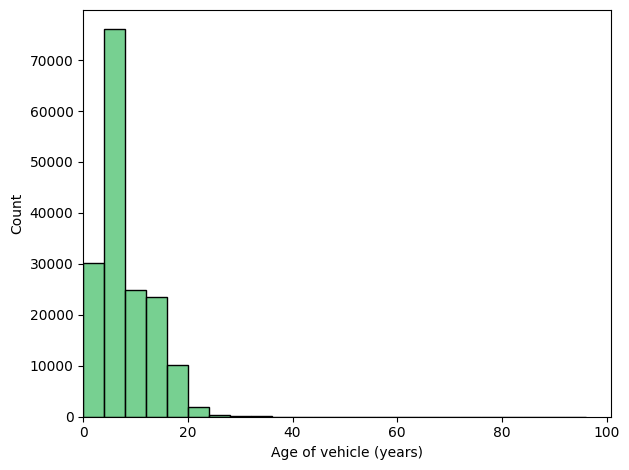

In [127]:
#Plot histogram of age_of_vehicle
age_of_vehicle_distribution = plot_series_distribution(vehicle_df, 'age_of_vehicle', bins=age_bins, bin_width=bin_width, xlabel='Age of vehicle (years)', color_index=4)

In [283]:
def plot_boxplot(df, column, color_index=0, ylabel=None):
    """
    Plot a boxplot of a specific column in a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    column (str): Name of the column to be plotted.
    color_index (int): Index of the color to be used for plotting.

    Returns:
    fig (matplotlib.figure.Figure): The generated matplotlib figure.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(y=column, data=df, color=sns.color_palette('viridis')[color_index], ax=ax)
    ax.set_ylabel(ylabel)
    plt.tight_layout()

    return fig

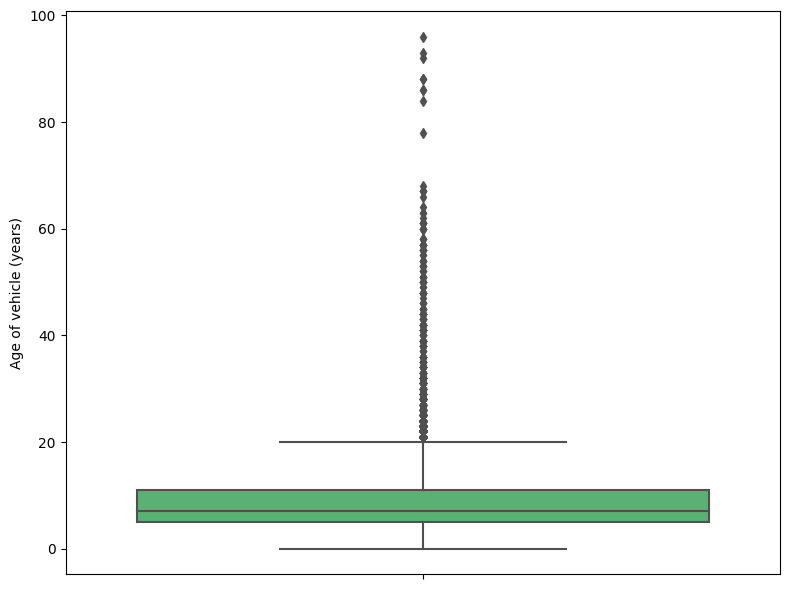

In [284]:
#Boxplot age_of_vehicle in vehicle_df
age_of_vehicle_boxplot = plot_boxplot(vehicle_df, 'age_of_vehicle', color_index=4, ylabel="Age of vehicle (years)")

Majority of vehicles are aged up to 20 years, with quite a few outliers  greater than 20 years old sitting outside 1.5 x the IQR (whiskers).

*Accident geography*

pip install folium

pip install selenium -to save screenshot

Python visualization Folium (2024). Available online: https://python-visualization.github.io/folium/latest/ [Accessed 10/03/2024].

In [130]:
#Function for a folium map with density heat map overlay
def plot_high_density_accidents(accident_df, radius=10, density_threshold=1):
    """
    Plot high-density accident locations on a Folium map.

    Parameters:
    accident_df (pd.DataFrame): DataFrame containing accident locations with latitude and longitude columns.
    radius (int, optional): Radius of each point in the heatmap. Default is 10.
    density_threshold (float, optional): Density threshold above which accident locations are considered high-density. Default is 1.

    Returns:
    folium.Map: Folium map object displaying the heatmap of high-density accident locations.
    """
    #Calculate accident density and filter high-density accidents
    accident_density = accident_df[['latitude', 'longitude']].value_counts().reset_index()
    accident_density.columns = ['latitude', 'longitude', 'density']
    high_density_accidents = accident_density[accident_density['density'] > density_threshold]

    #Create a base map centered around the mean of accident coordinates
    map_accident_density = folium.Map(location=[accident_df['latitude'].mean(), accident_df['longitude'].mean()], zoom_start=7)

    #Create a HeatMap layer with high-density accident locations
    heat_map = HeatMap(high_density_accidents[['latitude', 'longitude', 'density']], radius=radius)

    #Add the HeatMap layer to the map
    map_accident_density.add_child(heat_map)

    return map_accident_density

In [131]:
#Run function on accident_df
map_accident_density = plot_high_density_accidents(accident_df, radius=25.81, density_threshold=1.99)
map_accident_density

In [132]:
map_accident_density.save("map_accident_density.png")

The density plot shows a concentration of accidents in cities in England and Wales including, London, Birmingham, Leeds and Manchester.

This is not surprising as the population of these cities if the highest in the UK according to the 2021 census.

Office for National Statistics Towns and cities, characteristics of built-up areas, England and Wales: census 2021 (2023). Available online: https://www.ons.gov.uk/peoplepopulationandcommunity/housing/articles/townsandcitiescharacteristicsofbuiltupareasenglandandwales/census2021 [Accessed 10/03/2024].

*Percentage of accidents in cities (urban areas)*

Defined by filtering accident_df on one way street (2) and single carriageway (6) road_types.

In [133]:
#Total number of accidents in accident_df
total_accidents = len(accident_df)

#Define urban road types - one way street (2), single carriageway (6)
urban_road_types = [2, 6]

#Filter the df for urban road types
urban_accidents = accident_df[accident_df['road_type'].isin(urban_road_types)]

#Calculate the count of urban accidents
count_urban_accidents = len(urban_accidents)

#Calculate the percentage of urban accidents compared to the total number of accidents
percentage_of_total = (count_urban_accidents / total_accidents) * 100

print(f"Percentage of accidents for urban road types: {percentage_of_total:.2f}%")

Percentage of accidents for urban road types: 75.54%


More than 75% of accidents occur on one way streets and single carriageway, likely in urban areas, which correlates with the density map of accident locations in cities. 

The speed limits on these roads are lower compared to dual-carriageways. There may be a correlation or association between speed limit and road type and the severity of the accidents occuring in more urban areas. One can assume that accident severity is more likely to be slight. 

In [134]:
#Printing unique values in the urban_or_rural_area column
urban_or_rural_unique_values = accident_df['urban_or_rural_area'].unique()
print(urban_or_rural_unique_values)

[1 2 3]


Can't locate the corresponding descriptors for the urban_or_rural_area column in accident_df so unable to perform analaysis on rural vs urban frequency.

**Further Data Insights**

*1. Are there significant hours of the day, and days of the week, on which accidents occur?*

Analysis undertaken in this section:

1. Hours of the day
2. Days of the week

*Hours of the day*

In [135]:
#Binning the decimal time into 24 bins for hours of day
hour_bins = pd.cut(accident_df['decimal_time'], bins=24, labels=range(24))  

#Calculating the count of accidents for each bin
hour_bin_counts = hour_bins.value_counts().sort_index().reset_index()
hour_bin_counts.columns = ['Hour', 'Accident Count']

In [136]:
#Function to plot accident count by hour of the day
def plot_accidents_by_hour(df, decimal_time_column, color_index=0, bin_counts=0):
    #Plot the variability over 24 hours using sns histplot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(data=bin_counts, x='Hour', weights='Accident Count', bins=24, color=sns.color_palette('viridis')[color_index], alpha=0.7, kde=True, ax=ax)

    plt.xlabel('Hour of the Day')
    plt.ylabel('Accident Count')
    plt.xticks(rotation=45)
    plt.tight_layout()

    return fig

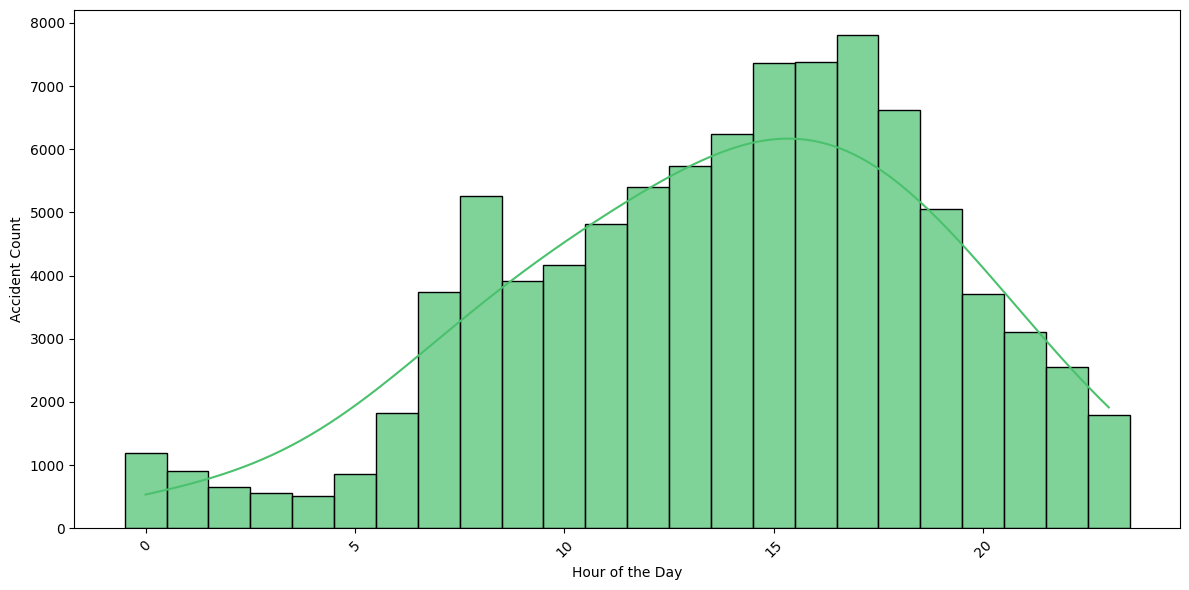

In [137]:
#Run function on decimal time column in accident_df
accident_hour_day = plot_accidents_by_hour(accident_df, 'decimal_time', color_index=4, bin_counts=hour_bin_counts)

Greatest number of accidents occur at rush hour and around the time of the school runs from 3-6pm.

Quantify (in terms of standard deviations) just how much more likely accidents are at evening rush hours compared to the rest of the hours of the day.

In [138]:
#Calculate mean and standard deviation for all hours
mean_all_hours = hour_bin_counts['Accident Count'].mean()
std_all_hours = hour_bin_counts['Accident Count'].std()

#Define evening rush hours (e.g., from 4 PM to 7 PM)
evening_rush_hours = hour_bin_counts[(hour_bin_counts['Hour'] >= 15) & (hour_bin_counts['Hour'] <= 18)]

#Calculate mean and standard deviation for evening rush hours
mean_evening_rush = evening_rush_hours['Accident Count'].mean()
std_evening_rush = evening_rush_hours['Accident Count'].std()

#Calculate the difference in accident counts in terms of standard deviations
difference_in_std = (mean_evening_rush - mean_all_hours) / std_all_hours

print(f"Difference in accident counts during evening rush hours compared to all hours (standard deviation): {difference_in_std:.2f}")

Difference in accident counts during evening rush hours compared to all hours (standard deviation): 1.46


*Days of the week*

In [139]:
#Calculate the count of accidents for each day of the week
accidents_by_day = accident_df['day_of_week'].value_counts().sort_index()

In [140]:
#Function to count accidents by day of the week
def plot_accidents_by_day(df, day_column, color_index=0):
    #Calculate the count of accidents for each day of the week
    accidents_by_day = df[day_column].value_counts().sort_index()
    
    #Define the names for the days of the week
    #Determined using stats information sheet 1 = Sunday, 7 = Saturday
    day_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

    #Create a bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=day_names, y=accidents_by_day, color=sns.color_palette('viridis')[color_index], ax=ax)
    
    plt.xlabel('Day of the Week')
    plt.ylabel('Accident Count')
    plt.xticks(rotation=45)
    plt.tight_layout()

    return fig

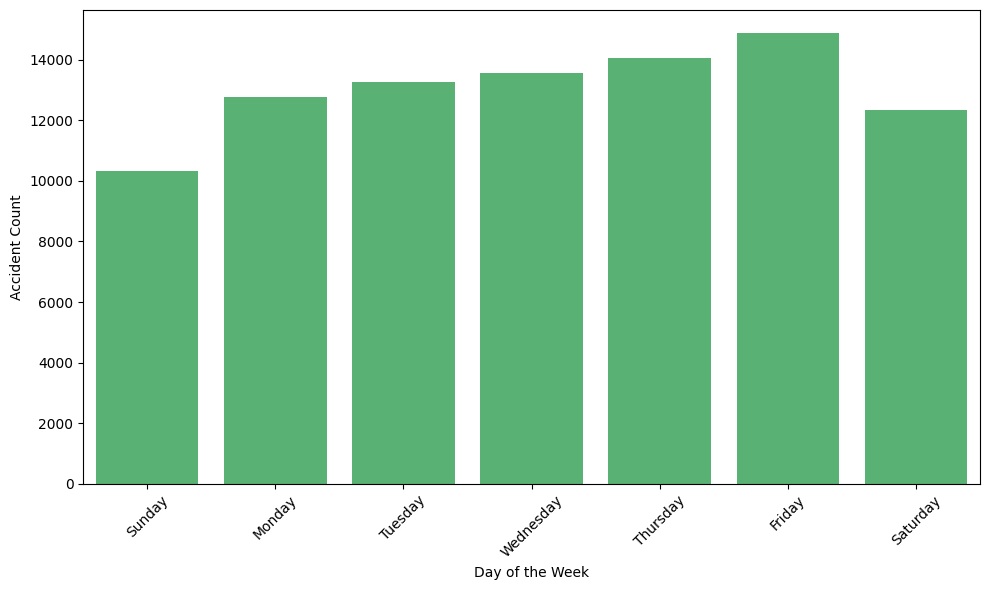

In [141]:
#Run function on day_of_week column in accident_df
accident_day_week = plot_accidents_by_day(accident_df, 'day_of_week', color_index=4)

More accidents occur during the working week, than at the weekends. Most occur on Friday when people are rushing home for the weekend.

*2. For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur?* 

Focus on: Motorcycle 125cc and under, Motorcycle over 125cc and up to 500cc, and Motorcycle over 500cc.

Motorcycle 50cc and under = 2
Motorcycle 125cc and under = 3
Motorcycle over 125cc up to 500cc = 4
Motorcycle over 500cc = 5

Analysis undertaken in this section:

1. Percentage accidents in each motorbike category
2. Hours of the day for each category and all motorbikes
3. Days of the week for each category
4. Hypothesis testing for each ategory to determine if statistical significane wbetween accident occurrence at weekend vs weekday

*Hours of day*

In [142]:
#Filter merged df for accidents involving the three categories of motorbikes by engine size
motorbike_under_125_accidents = merged_df[merged_df['vehicle_type'].isin([2, 3])]
motorbike_125_500_accidents = merged_df[merged_df['vehicle_type'] == 4]
motorbike_500_over_accidents = merged_df[merged_df['vehicle_type'] == 5]

#Binning the decimal time into 24 bins for each filtered motorbike df
hour_bins_under_125 = pd.cut(motorbike_under_125_accidents['decimal_time'], bins=24, labels=range(24)) 
hour_bins_125_500 = pd.cut(motorbike_125_500_accidents['decimal_time'], bins=24, labels=range(24)) 
hour_bins_500_over = pd.cut(motorbike_500_over_accidents['decimal_time'], bins=24, labels=range(24)) 

#Calculating the count of accidents for each bin
hour_bin_counts_under_125 = hour_bins_under_125.value_counts().sort_index().reset_index()
hour_bin_counts_125_500 = hour_bins_125_500.value_counts().sort_index().reset_index()
hour_bin_counts_500_over = hour_bins_500_over.value_counts().sort_index().reset_index()

#Assigning column names
hour_bin_counts_under_125.columns = ['Hour', 'Accident Count']
hour_bin_counts_125_500.columns = ['Hour', 'Accident Count']
hour_bin_counts_500_over.columns = ['Hour', 'Accident Count']

In [143]:
#Calculate total count of accidents for each motorbike category
total_accidents_under_125 = len(motorbike_under_125_accidents)
total_accidents_125_500 = len(motorbike_125_500_accidents)
total_accidents_500_over = len(motorbike_500_over_accidents)

#Calculate total count of accidents across all categories
total_accidents_all_motorbikes = total_accidents_under_125 + total_accidents_125_500 + total_accidents_500_over

#Calculate percentages of accidents for each motorbike category
percentage_under_125 = (total_accidents_under_125 / total_accidents_all_motorbikes) * 100
percentage_125_500 = (total_accidents_125_500 / total_accidents_all_motorbikes) * 100
percentage_500_over = (total_accidents_500_over / total_accidents_all_motorbikes) * 100

print(f"Percentage of accidents for motorbikes under 125cc: {percentage_under_125:.2f}%")
print(f"Percentage of accidents for motorbikes between 125cc and 500cc: {percentage_125_500:.2f}%")
print(f"Percentage of accidents for motorbikes over 500cc: {percentage_500_over:.2f}%")

Percentage of accidents for motorbikes under 125cc: 59.58%
Percentage of accidents for motorbikes between 125cc and 500cc: 12.04%
Percentage of accidents for motorbikes over 500cc: 28.39%


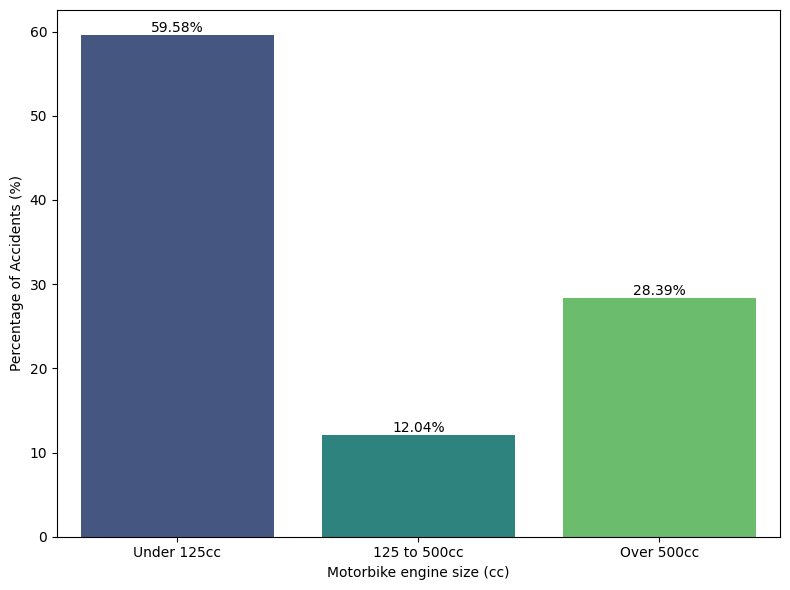

In [144]:
#Plot the percentages in a bar plot
motorbike_labels = ['Under 125cc', '125 to 500cc', 'Over 500cc']
motorobike_percentages = [percentage_under_125, percentage_125_500, percentage_500_over]

percentage_casualty_severity_motorbike = plot_percentage_barplot(motorbike_labels, motorobike_percentages, xlabel='Motorbike engine size (cc)', ylabel='Percentage of Accidents (%)')

Majority of motorbike accidents occur with engine size under 125cc. Nearly 30% are involving 500cc.

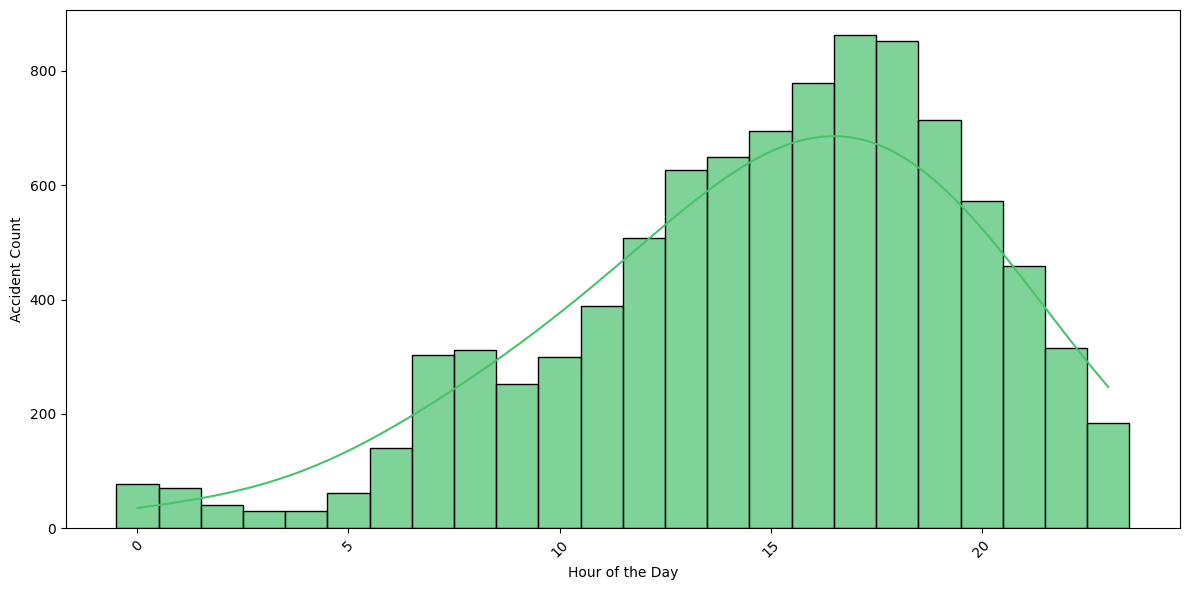

In [145]:
#Run function on decimal time column on motorbikes under 125 cc
accident_hour_day_motorbike_under_125 = plot_accidents_by_hour(motorbike_under_125_accidents, 'decimal_time', color_index=4, bin_counts=hour_bin_counts_under_125)

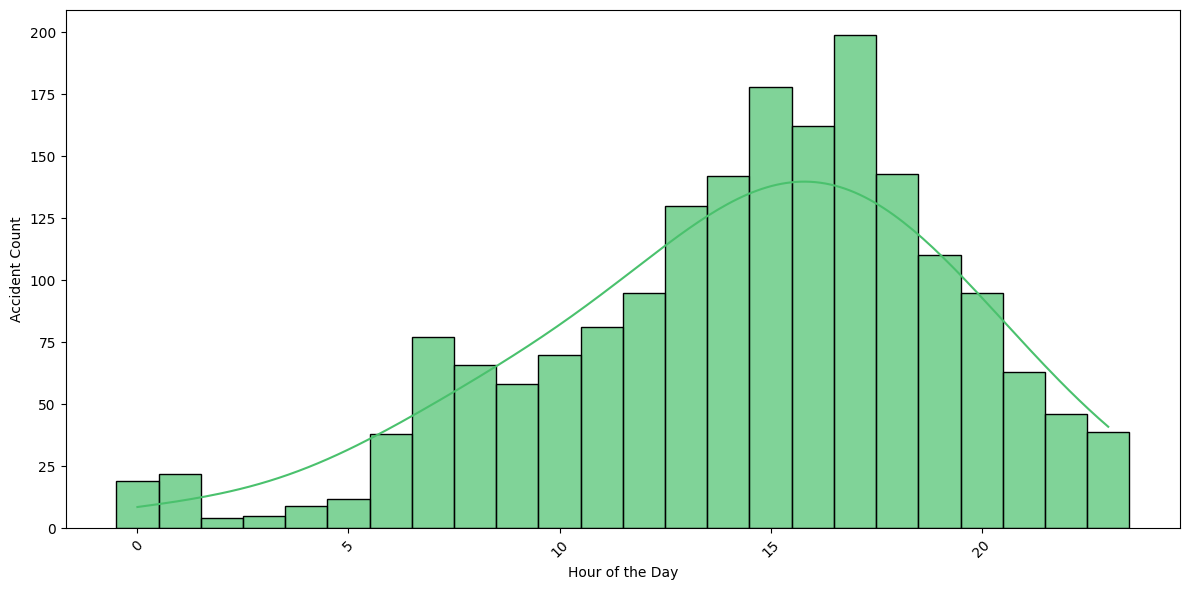

In [146]:
#Run function on decimal time column on motorbikes between 125 and under 500cc
accident_hour_day_motorbike_125_500 = plot_accidents_by_hour(motorbike_125_500_accidents, 'decimal_time', color_index=4, bin_counts=hour_bin_counts_125_500)

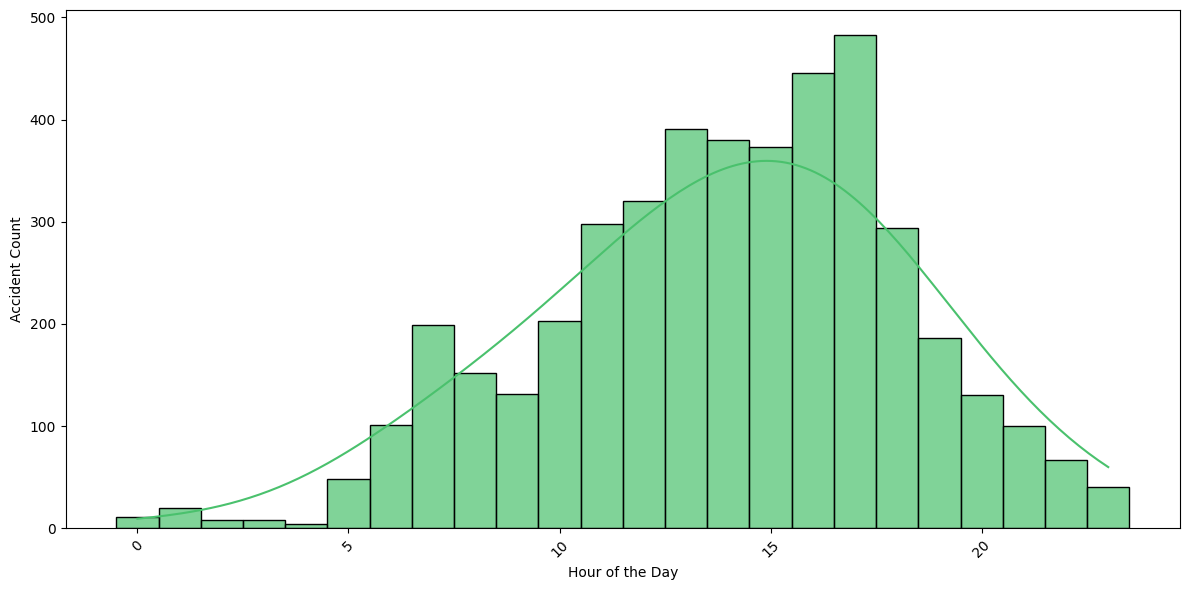

In [147]:
#Run function on decimal time column on motorbikes over 500cc
accident_hour_day_motorbike_500_over = plot_accidents_by_hour(motorbike_500_over_accidents, 'decimal_time', color_index=4, bin_counts=hour_bin_counts_500_over)

In [148]:
#Combine all motorbike data and visualise accidents by hours of day
all_motorbike_accidents = merged_df[merged_df['vehicle_type'].isin([2, 3, 4, 5])]

#Reset the index after concatenation
all_motorbike_accidents.reset_index(drop=True, inplace=True)

#Binning the decimal time into 24 bins for all_motorbike_accidents df
all_motorbike_accidents_hour_bins = pd.cut(all_motorbike_accidents['decimal_time'], bins=24, labels=range(24)) 

#Calculating the count of accidents for each bin
all_motorbike_accidents_hour_bin_counts = all_motorbike_accidents_hour_bins.value_counts().sort_index().reset_index()

#Assigning column names
all_motorbike_accidents_hour_bin_counts.columns = ['Hour', 'Accident Count']

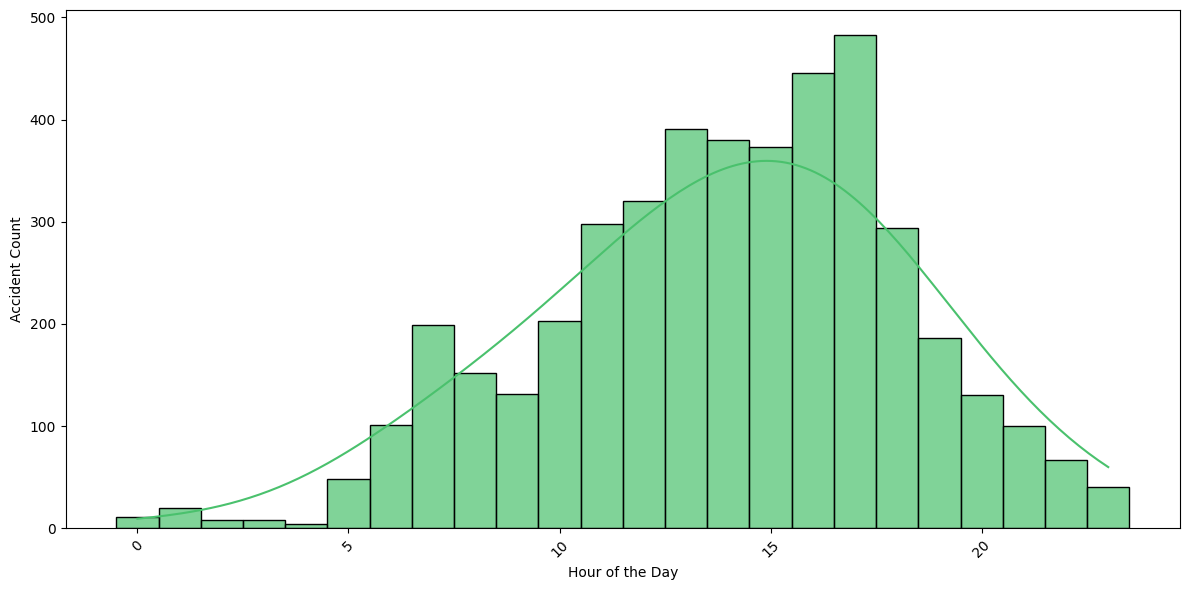

In [149]:
#Run function on decimal time column for all motorbikes
accident_hour_day_all_motorbikes = plot_accidents_by_hour(all_motorbike_accidents, 'decimal_time', color_index=4, bin_counts=hour_bin_counts_500_over)

Number of accidents on motorbikes is higher around rush hours correlating with distribution of crashes by hour for all vehicles.

*Days of week*

In [150]:
def plot_motorbike_accidents_by_day(motorbike_under_125_accidents, motorbike_125_500_accidents, motorbike_500_over_accidents):
    """
    Plot the distribution of motorbike accidents by day of the week and motorbike category.

    Parameters:
    motorbike_under_125_accidents (DataFrame): DataFrame containing motorbike accidents data for bikes under 125cc, with a 'day_of_week' column.
    motorbike_125_500_accidents (DataFrame): DataFrame containing motorbike accidents data for bikes between 125cc and 500cc, with a 'day_of_week' column.
    motorbike_500_over_accidents (DataFrame): DataFrame containing motorbike accidents data for bikes over 500cc, with a 'day_of_week' column.

    Returns:
    fig (matplotlib.figure.Figure): The generated matplotlib figure.
    """
    #Group by day of week and count accidents for each dataframe
    motorbike_under_125_counts = motorbike_under_125_accidents['day_of_week'].value_counts().sort_index()
    motorbike_125_500_counts = motorbike_125_500_accidents['day_of_week'].value_counts().sort_index()
    motorbike_over_500_counts = motorbike_500_over_accidents['day_of_week'].value_counts().sort_index()

    #Define the names for the days of the week
    day_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

    #Combine counts into a single df
    counts_df = pd.DataFrame({
        'Day of Week': day_names,
        'Under 125cc': motorbike_under_125_counts.values,
        '125cc - 500cc': motorbike_125_500_counts.values,
        'Over 500cc': motorbike_over_500_counts.values
    })

    #Melt df to have 'Day of Week' as x-axis, 'Count' as y-axis and 'Motorbike Category' as hue
    melted_df = pd.melt(counts_df, id_vars='Day of Week', var_name='Motorbike Category', value_name='Count')

    #Plot using sns
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=melted_df, x='Day of Week', y='Count', hue='Motorbike Category', palette='viridis', ax=ax)
    plt.xlabel('Day of the Week')
    plt.ylabel('Accident Count')
    plt.xticks(rotation=45)
    plt.legend(title='Motorbike Category')
    plt.tight_layout()
    
    return fig

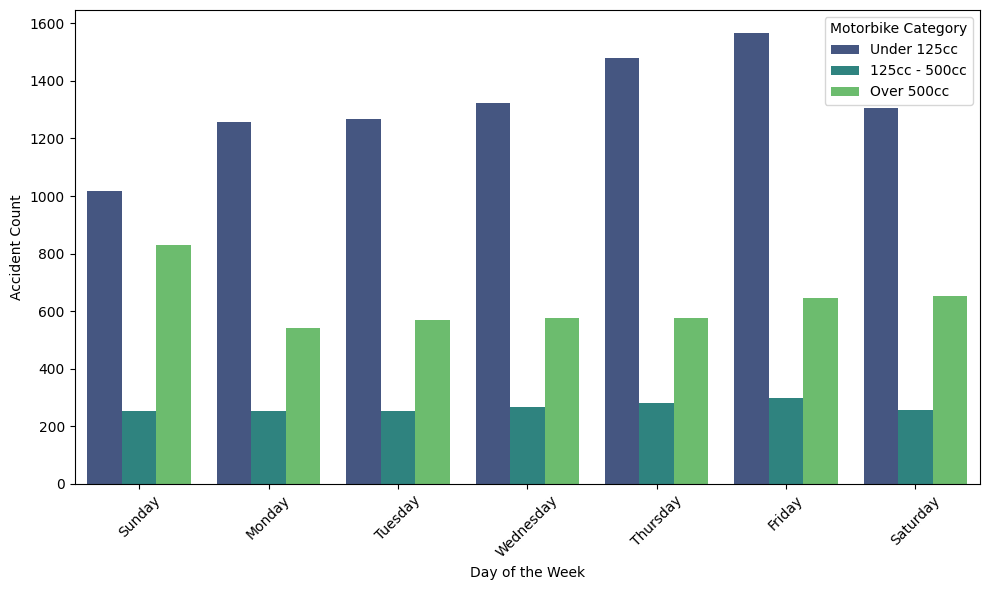

In [151]:
motorbike_category_accident_by_day = plot_motorbike_accidents_by_day(motorbike_under_125_accidents, motorbike_125_500_accidents, motorbike_500_over_accidents)

Most accidents occur on Fridays for motorbikes under 125cc. Over 500cc motorbikes have more accidents on Sundays.

*Hypothesis testing*

Is there a significant difference in the count of accidents between weekends (Saturday and Sunday) and weekdays (Monday to Friday) for each motorbike category? Use two sample independent t-test to determine.

Null hypothesis (H0): There is no significant difference in the mean number of accidents between weekends and weekdays.

Alternative hypothesis (H1): There is a significant difference in the mean number of accidents between weekends and weekdays.

p-value = 0.05

In [152]:
#Splitting the data into weekends and weekdays for all motorbike categories
motorbike_under_125_accidents_weekends = motorbike_under_125_accidents[(motorbike_under_125_accidents['day_of_week'] == 7) | (motorbike_under_125_accidents['day_of_week'] == 1)]
motorbike_under_125_accidents_weekdays = motorbike_under_125_accidents[(motorbike_under_125_accidents['day_of_week'] != 7) & (motorbike_under_125_accidents['day_of_week'] != 1)]
motorbike_125_500_accidents_weekends = motorbike_125_500_accidents[(motorbike_125_500_accidents['day_of_week'] == 7) | (motorbike_125_500_accidents['day_of_week'] == 1)]
motorbike_125_500_accidents_weekdays = motorbike_125_500_accidents[(motorbike_125_500_accidents['day_of_week'] != 7) & (motorbike_125_500_accidents['day_of_week'] != 1)]
motorbike_500_over_accidents_weekends = motorbike_500_over_accidents[(motorbike_500_over_accidents['day_of_week'] == 7) | (motorbike_500_over_accidents['day_of_week'] == 1)]
motorbike_500_over_accidents_weekdays = motorbike_500_over_accidents[(motorbike_500_over_accidents['day_of_week'] != 7) & (motorbike_500_over_accidents['day_of_week'] != 1)]

In [153]:
#Function to perform t_test on two sets of data
def perform_t_test(data1, data2):
    """
    Perform a t-test for two independent samples.

    Parameters:
    data1 (array-like): The data for the first sample.
    data2 (array-like): The data for the second sample.

    Returns:
    t_statistic (float): The calculated t-statistic.
    p_value (float): The two-tailed p-value.
    """
    #Performing t-test for data1 and data2
    t_statistic, p_value = ttest_ind(data1, data2)  #Using row indices as proxy for counts to determine the mean

    return t_statistic, p_value

In [154]:
t_statistic, p_value = perform_t_test(motorbike_under_125_accidents_weekends.index, motorbike_under_125_accidents_weekdays.index)
print("For motorbike under 125cc:")
print(f"T-Statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

For motorbike under 125cc:
T-Statistic: 0.2806
P-value: 0.7791


In [155]:
t_statistic_2, p_value_2 = perform_t_test(motorbike_125_500_accidents_weekends.index, motorbike_125_500_accidents_weekdays.index)
print("For motorbike 125 to 500cc:")
print(f"T-Statistic: {t_statistic_2:.4f}")
print(f"P-value: {p_value_2:.4f}")

For motorbike 125 to 500cc:
T-Statistic: 1.7579
P-value: 0.0789


In [156]:
t_statistic_3, p_value_3 = perform_t_test(motorbike_500_over_accidents_weekends.index, motorbike_500_over_accidents_weekdays.index)
print("For motorbike over 500cc:")
print(f"T-Statistic: {t_statistic_3:.4f}")
print(f"P-value: {p_value_3}")

For motorbike over 500cc:
T-Statistic: 7.9307
P-value: 2.7421081570545336e-15


For motorbike over 500cc category, the p-value is less than 0.05, therefore the null hypothesis is rejected and there is signficant difference in accidents between weekdays and weekends for this category. Motorbikes over 500cc might be used more recereationally, rather than for commuter purposes during the week.

*Determine if significant difference in motorbike and car accidents being fatal (casualty_severity = 1)*

In [157]:
#all_motorbike_accidents
car_accidents = merged_df[merged_df['vehicle_type'] == 9]
 
#where casualty_severity = 1 (fatal) is there a significant difference between motorbike and car accidents?
fatal_motorbike_accidents = all_motorbike_accidents[all_motorbike_accidents['casualty_severity'] == 1]
fatal_car_accidents = car_accidents[car_accidents['casualty_severity'] == 1]

#Count the number of fatal casualties for motorbikes and cars
motorbike_fatal_count = len(fatal_motorbike_accidents)
car_fatal_count = len(fatal_car_accidents)

print("Number of fatal motorbike accidents:", motorbike_fatal_count)
print("Number of fatal car accidents:", car_fatal_count)

Number of fatal motorbike accidents: 302
Number of fatal car accidents: 1563


The number of fatal car accidents is a lot higher than fatal motrobike accidents. Is there a significant difference?

Null hypothesis (H0): There is no significant difference in the number of fatal accidents between motorbikes and cars.

Alternative hypothesis (H1): There is a significant difference in the number of fatal accidents between motorbikes and cars.

In [158]:
#Perform chi square test to determine if there is a statsictical significance between cars and motrobikes for accident fatality
#Create a contingency table for the chi-square test (p = 0.05)
#This represents the counts of fatal and non-fatal accidents for motorbikes and cars
contingency_table = [[motorbike_fatal_count, car_fatal_count],
                     [len(all_motorbike_accidents) - motorbike_fatal_count, len(car_accidents) - car_fatal_count]]

#Perform chi-square test
chi2_stat, p_value_chi, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value_chi}")

Chi-square Statistic: 122.5737
P-value: 1.7287294592896454e-28


The very low p-value indicates a significant difference between number of fatal accidents for cars vs motorbikes so the null hypothesis is rejected.

Since the chi-square statistic is quite high and the associated p-value is very low, it suggests that there is a significant association between vehicle type and accident severity. The difference in the number of fatal accidents between motorbikes and cars is unlikely to have occurred by random chance alone. 

*3. For pedestrians involved in accidents, are there significant hours of the day, and days of the week, on which they are more likely to be involved?*

Analysis undertaken in this section:

1. Hours of the day for pedestrian accidents
2. School-aged children involved in accidents at certain times (hypothesis testing)
3. Days of the week for pedestrian accidents

*Hours of day*

In [159]:
#Already have merged_df combining all three original dfs
#Filter merged_df for accidents involving pedestrians, where casualty_class = 3
pedestrian_accidents = merged_df[merged_df['casualty_class'] == 3]

#Binning the decimal time into 24 bins for each filtered motorbike df
hour_bins_pedestrians = pd.cut(pedestrian_accidents['decimal_time'], bins=24, labels=range(24)) 

#Calculating the count of accidents for each bin
hour_bin_counts_pedestrians = hour_bins_pedestrians.value_counts().sort_index().reset_index()

#Assigning column names
hour_bin_counts_pedestrians.columns = ['Hour', 'Accident Count']

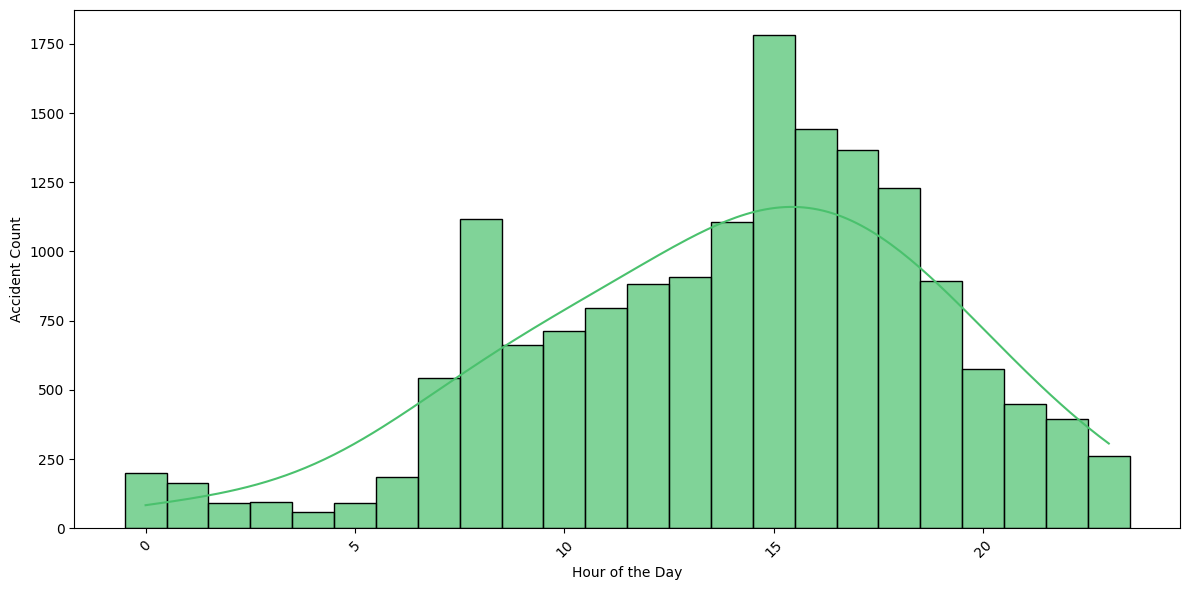

In [160]:
#Run function on decimal time column on pedestrian accidents
accident_hour_day_pedestrians = plot_accidents_by_hour(pedestrian_accidents, 'decimal_time', color_index=4, bin_counts=hour_bin_counts_pedestrians)

Highest number of pedestrain accidents occur at 8am and from 3pm to 6pm. Count is particulary high at 3pm which may correlate with school children leaving school? Can look at age of pedestrian to determine if significant proportion are school-aged.

In [161]:
#Filter pedestrian_accidents for accidents at 3pm (bin 15)
pedestrians_at_3pm = pedestrian_accidents[hour_bins_pedestrians == 15]

#Total number of pedestrian casualties at 3pm
total_pedestrian_casualties_at_3pm = len(pedestrians_at_3pm)

#Further filter for pedestrians aged 18 and under
pedestrians_18_and_under_at_3pm = pedestrians_at_3pm[pedestrians_at_3pm['age_of_casualty'] <= 18]

#Number of pedestrian casualties aged 18 and under at 3pm
num_pedestrians_18_and_under_at_3pm = len(pedestrians_18_and_under_at_3pm)

#Calculate the percentage
percentage_18_and_under_at_3pm = (num_pedestrians_18_and_under_at_3pm / total_pedestrian_casualties_at_3pm) * 100

print("Number of pedestrians aged 18 and under involved in accidents at 3pm:", num_pedestrians_18_and_under_at_3pm)
print(f"Percentage of pedestrians aged 18 and under out of total pedestrian casualties at 3pm: {percentage_18_and_under_at_3pm:.2f}%")

Number of pedestrians aged 18 and under involved in accidents at 3pm: 937
Percentage of pedestrians aged 18 and under out of total pedestrian casualties at 3pm: 52.55%


Greater than 50% of pedestrian casualties at 3pm are 18 and under, correlating with thwory that a number are school children walking home from school.

In [162]:
#Compare to 4pm - are the number of 18 and unders less at this time?
#Filter pedestrian_accidents for accidents at 4pm (bin 16)
pedestrians_at_4pm = pedestrian_accidents[hour_bins_pedestrians == 16]

#Total number of pedestrian casualties at 4pm
total_pedestrian_casualties_at_4pm = len(pedestrians_at_4pm)

#Further filter for pedestrians aged 18 and under
pedestrians_18_and_under_at_4pm = pedestrians_at_4pm[pedestrians_at_4pm['age_of_casualty'] <= 18]

#Number of pedestrian casualties aged 18 and under at 4pm
num_pedestrians_18_and_under_at_4pm = len(pedestrians_18_and_under_at_4pm)

#Calculate the percentage
percentage_18_and_under_at_4pm = (num_pedestrians_18_and_under_at_4pm / total_pedestrian_casualties_at_4pm) * 100

print("Number of pedestrians aged 18 and under involved in accidents at 4pm:", num_pedestrians_18_and_under_at_4pm)
print(f"Percentage of pedestrians aged 18 and under out of total pedestrian casualties at 4pm: {percentage_18_and_under_at_4pm:.2f}%")

Number of pedestrians aged 18 and under involved in accidents at 4pm: 537
Percentage of pedestrians aged 18 and under out of total pedestrian casualties at 4pm: 37.27%


Number of 18 and under pedestrain casualties at 4pm is lower at 37%.

Hypothesis testing

Null hypothesis (H0): There is no significant difference in the proportion of pedestrians aged 18 and under out of the total pedestrian casualties between 3pm and 4pm.

Alternative hypothesis (H1): There is a significant difference in the proportion of pedestrians aged 18 and under out of the total pedestrian casualties between 3pm and 4pm.

p=0.05

In [163]:
#Perform chi-square test
#Contingency table_2
contingency_table_2 = [[num_pedestrians_18_and_under_at_3pm, num_pedestrians_18_and_under_at_4pm],
                   [total_pedestrian_casualties_at_3pm - num_pedestrians_18_and_under_at_3pm,
                    total_pedestrian_casualties_at_4pm - num_pedestrians_18_and_under_at_4pm]]

#Perform chi-square test
chi2_stat_2, p_value_chi_2, dof, expected = chi2_contingency(contingency_table_2)
print(f"Chi-square Statistic: {chi2_stat_2:.4f}")
print(f"P-value: {p_value_chi_2}")

Chi-square Statistic: 74.4210
P-value: 6.311506012358953e-18


Since the p-value is less than the significance level, reject the null hypothesis because there is a significant difference in the proportion of pedestrians aged 18 and under between 3pm and 4pm.

This suggests that the number of pedestrians aged 18 and under involved in accidents significantly differs between 3pm and 4pm, correlating with increased school-aged children involved in accidents at 3pm (school home time). This warrantes a closer look at children road safety.

*Days of week*

In [164]:
#Calculate the count of pedestrian accidents for each day of the week
accidents_by_day_pedestrians = pedestrian_accidents['day_of_week'].value_counts().sort_index()

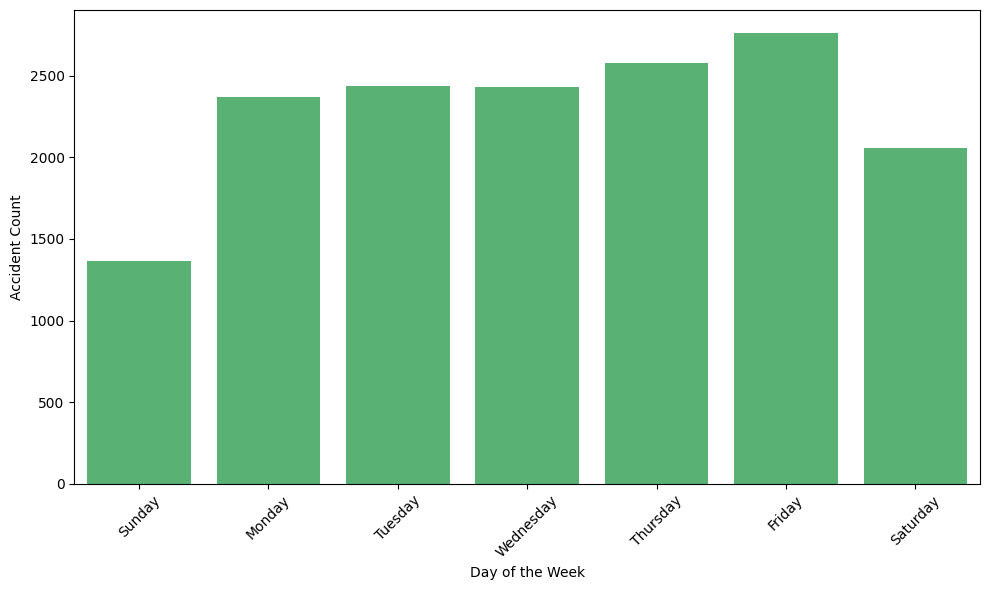

In [165]:
#Run function on day_of_week column in pedestrian_accidents
accident_day_week_pedestrians = plot_accidents_by_day(pedestrian_accidents, 'day_of_week', color_index=4)

More pedestrian accidents occur during the working week, than at the weekends, correlating with total number of accidents. Most occur on Friday when people are rushing home for the weekend, again correalting with total accidents by day of week.

*Light and weather conditions*

Analysis undertaken in this section:

1. Percentage of accidents due to weather conditions
2. Percentage of accidents due to light conditions

In [166]:
#Count the number of accidents for each weather condition
weather_conditions_count = accident_df['weather_conditions'].value_counts()

#Calculate the percentage of accidents for each weather condition
weather_conditions_percentage = (weather_conditions_count / len(accident_df)) * 100

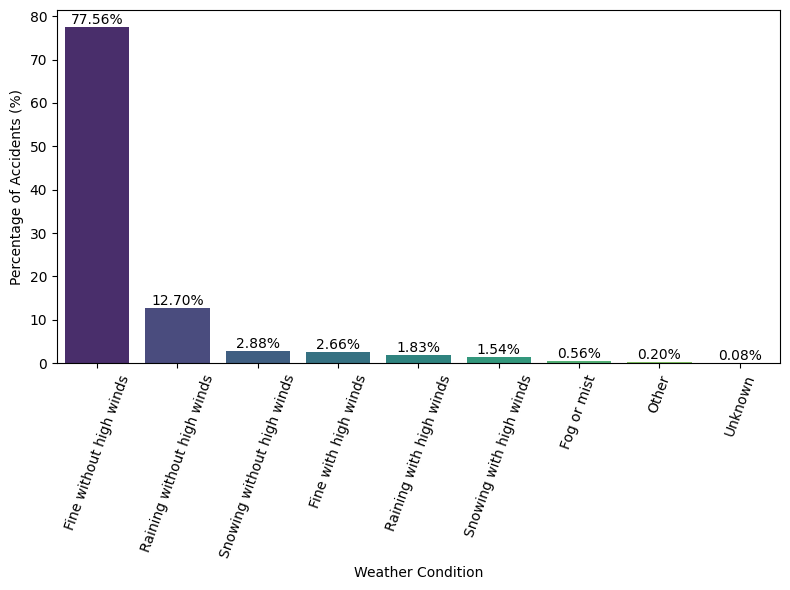

In [167]:
#Define the weather condition labels and percentages
weather_condition_labels = ['Fine without high winds', 'Raining without high winds', 
                              'Snowing without high winds', 'Fine with high winds', 
                              'Raining with high winds', 'Snowing with high winds', 
                              'Fog or mist', 'Other', 'Unknown']

#Plot the percentage bar plot for weather conditions
weather_conditions = plot_percentage_barplot(weather_condition_labels,  weather_conditions_percentage, xlabel='Weather Condition', ylabel='Percentage of Accidents (%)', rotation=70)

In [168]:
#Count the number of accidents for each light condition
light_conditions_count = accident_df['light_conditions'].value_counts()

#Calculate the percentage of accidents for each light condition
light_conditions_percentage = (light_conditions_count / len(accident_df)) * 100

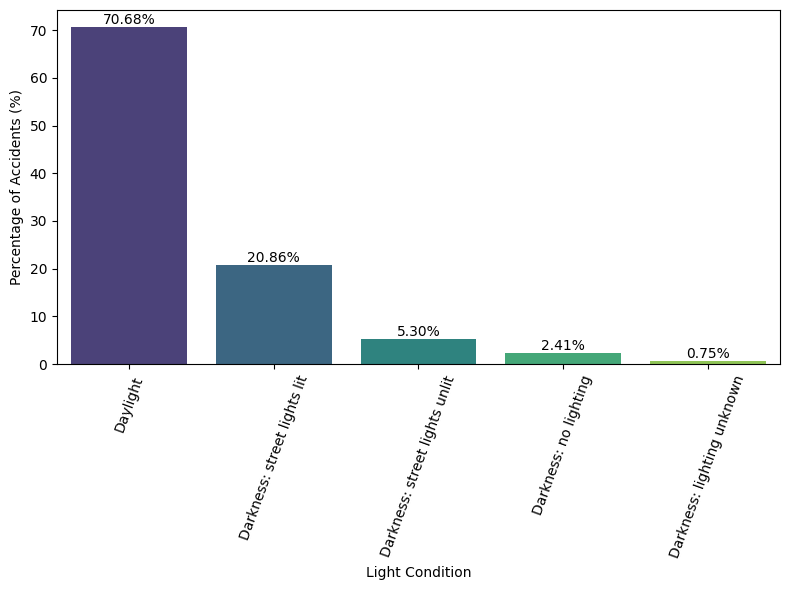

In [169]:
#Define the weather condition labels and percentages
light_condition_labels = ['Daylight', 'Darkness: street lights lit', 
                          'Darkness: street lights unlit', 'Darkness: no lighting', 
                          'Darkness: lighting unknown']

#Plot the percentage bar plot for weather conditions
light_conditions = plot_percentage_barplot(light_condition_labels,  light_conditions_percentage, xlabel='Light Condition', ylabel='Percentage of Accidents (%)', rotation=70)

More than 70% of accidents occurred during daylight and under fine weather conditions. More challenging weather and lighting conditions had minimal impact on accident occurrence. Rather than causing more accidents, the poor weather and darkness reduce them by discouraging driving, leading to fewer drivers and less congested roads, reducing the number of accidents.

*Using the apriori algorithm, explore the impact of selected variables on accident severity.*  

accident_severity key for merged_df:
fatal = 1
serious = 2
slight = 3

Steps for Apriori and running association rules:

1. Data preprocessing encoding categorical variables and filtering relevant columns.

2. Apply the Apriori algorithm to find frequent itemsets and association rules.

3. Explore the association rules to understand the impact of selected variables on accident severity.

In [170]:
#View possible values for specific columns in merged_df
#Define columns to view the unique values
columns_of_interest = ['accident_severity', 'speed_limit', 'weather_conditions', 
                   'road_surface_conditions', 'light_conditions', 'vehicle_type', 
                   'sex_of_driver', 'road_type']

#Iterate over columns and print unique integer values
for column in columns_of_interest:
    unique_values = merged_df[column].astype(int).unique()
    print(f"Possible values in {column}:", unique_values)

Possible values in accident_severity: [3 2 1]
Possible values in speed_limit: [20 30 40 50 60 70]
Possible values in weather_conditions: [9 1 8 7 2 4 5 3 6]
Possible values in road_surface_conditions: [9 1 2 5 4 3]
Possible values in light_conditions: [1 4 5 7 6]
Possible values in vehicle_type: [ 9  8  3  2 11  1 90 19  4  5 21 97 20 98 10 17 23 22 18 16]
Possible values in sex_of_driver: [2 1 3]
Possible values in road_type: [6 2 3 7 1 9]


*Mapping category names to columns*

In [171]:
#Prep dataframes by mapping categories
#Define mappings for each column of interest
weather_conditions_mapping = {1: 'Fine without high winds', 2: 'Raining without high winds', 
                              3: 'Snowing without high winds', 4: 'Fine with high winds', 
                              5: 'Raining with high winds', 6: 'Snowing with high winds', 
                              7: 'Fog or mist', 8: 'Other', 9: 'Unknown'}
light_conditions_mapping = {1: 'Daylight', 4: 'Darkness: street lights present and lit', 
                            5: 'Darkness: street lights present but unlit', 6: 'Darkness: no street lighting', 
                            7: 'Darkness: street lighting unknown'}
road_surface_conditions_mapping = {1: 'Dry', 2: 'Wet/Damp', 3: 'Snow', 4: 'Frost/Ice', 5: 'Flood', 9: 'Unknown'}
vehicle_type_mapping = {1: 'Pedal cycle', 2: 'M/cycle 50cc and under', 
                        3: 'M/cycle over 50cc and up to 125cc', 4: 'M/cycle over 125cc and up to 500cc', 
                        5: 'Motorcycle over 500cc', 8: 'Taxi/Private hire car', 
                        9: 'Car', 10: 'Minibus (8-16 passenger seats)', 
                        11: 'Bus or coach', 16: 'Ridden horse',
                        17: 'Agricultural vehicle', 18: 'Tram/Light rail',
                        19: 'Van', 20: 'Goods vehicle over 3.5 tonnes and under 7.5 tonnes mgw',
                        21: 'Goods vehicle 7.5 tonnes mgw & over', 22: 'Mobility scooter',
                        23: 'Electric Motorcycle ', 90: 'Other', 
                        97: 'Motorcycle - cc unknown', 98: 'Goods vehicle - unknown weight'}
sex_of_driver_mapping = {1: 'Male', 2: 'Female', 3: 'Not known'}
road_type_mapping = {1: 'Roundabout', 2: 'One way street', 3: 'Dual carriageway', 6: 'Single carriageway', 7: 'Slip road', 9: 'Unknown'}
accident_severity_mapping = {1: 'Fatal', 2: 'Serious', 3: 'Slight'}

#Define mappings for each column
mappings = {
    'weather_conditions': weather_conditions_mapping,
    'road_surface_conditions': road_surface_conditions_mapping,
    'light_conditions': light_conditions_mapping,
    'vehicle_type': vehicle_type_mapping,
    'sex_of_driver': sex_of_driver_mapping,
    'road_type': road_type_mapping,
    'accident_severity': accident_severity_mapping
}

#Map categories to category names, convert 'speed_limit' to integer, then back to string
merged_df_sp_col = merged_df[columns_of_interest].copy()
merged_df_sp_col['speed_limit'] = merged_df_sp_col['speed_limit'].astype(int).astype(str)
for column, mapping in mappings.items():
    merged_df_sp_col[column] = merged_df_sp_col[column].map(mapping)

In [172]:
merged_df_sp_col.head()

accident_severity speed_limit       weather_conditions  \
0            Slight          20                  Unknown   
1            Slight          20  Fine without high winds   
2            Slight          20  Fine without high winds   
3            Slight          30  Fine without high winds   
4           Serious          30  Fine without high winds   

  road_surface_conditions                         light_conditions  \
0                 Unknown                                 Daylight   
1                     Dry                                 Daylight   
2                     Dry                                 Daylight   
3                Wet/Damp  Darkness: street lights present and lit   
4                     Dry  Darkness: street lights present and lit   

            vehicle_type sex_of_driver           road_type  
0                    Car        Female  Single carriageway  
1                    Car          Male  Single carriageway  
2                    Car          Male  Single carriageway  
3                    Car     Not known  Single carriageway  
4  Taxi/Private hire car          Male  Single carriageway

*One-hot encoding*

Scikit learn (n. d.) sklearn.preprocessing.OneHotEncoder. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html [Accessed 14/03/2024].

In [173]:
#One-hot encoding
encoded_df = pd.get_dummies(merged_df_sp_col)

In [174]:
encoded_df.head()

accident_severity_Fatal  accident_severity_Serious  \
0                    False                      False   
1                    False                      False   
2                    False                      False   
3                    False                      False   
4                    False                       True   

   accident_severity_Slight  speed_limit_20  speed_limit_30  speed_limit_40  \
0                      True            True           False           False   
1                      True            True           False           False   
2                      True            True           False           False   
3                      True           False            True           False   
4                     False           False            True           False   

   speed_limit_50  speed_limit_60  speed_limit_70  \
0           False           False           False   
1           False           False           False   
2           False           False           False   
3           False           False           False   
4           False           False           False   

   weather_conditions_Fine with high winds  ...  vehicle_type_Van  \
0                                    False  ...             False   
1                                    False  ...             False   
2                                    False  ...             False   
3                                    False  ...             False   
4                                    False  ...             False   

   sex_of_driver_Female  sex_of_driver_Male  sex_of_driver_Not known  \
0                  True               False                    False   
1                 False                True                    False   
2                 False                True                    False   
3                 False               False                     True   
4                 False                True                    False   

   road_type_Dual carriageway  road_type_One way street  road_type_Roundabout  \
0                       False                     False                 False   
1                       False                     False                 False   
2                       False                     False                 False   
3                       False                     False                 False   
4                       False                     False                 False   

   road_type_Single carriageway  road_type_Slip road  road_type_Unknown  
0                          True                False              False  
1                          True                False              False  
2                          True                False              False  
3                          True                False              False  
4                          True                False              False  

[5 rows x 58 columns]

*Apriori algorithm and association rules*

KDnuggets (2016) Association rules and the apriori algorithm: a tutorial. Available online: https://www.kdnuggets.com/2016/04/association-rules-apriori-algorithm-tutorial.html [Accessed 14/03/2024].

In [175]:
#Define apriori and association rule function
#Set minimum support to 0.25 for apriori
#Set confidence threshold to 0.7 for association rules
def find_association_rules(encoded_df, metric='confidence', min_support=0.25, min_threshold=0.7):
    #Apply Apriori algorithm
    frequent_itemsets = apriori(encoded_df, min_support=min_support, use_colnames=True)

    #Find association rules
    rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)

    return frequent_itemsets, rules

#Apply function to each encoded df
frequent_itemsets, rules = find_association_rules(encoded_df)

#Display frequent itemsets
print('Frequent itemsets:')
display(frequent_itemsets)

Frequent itemsets:


support                                           itemsets
0    0.777445                         (accident_severity_Slight)
1    0.542663                                   (speed_limit_30)
2    0.780892       (weather_conditions_Fine without high winds)
3    0.688416                      (road_surface_conditions_Dry)
4    0.293370                 (road_surface_conditions_Wet/Damp)
..        ...                                                ...
123  0.272171  (road_type_Single carriageway, light_condition...
124  0.281321  (accident_severity_Slight, vehicle_type_Car, l...
125  0.288262  (accident_severity_Slight, road_type_Single ca...
126  0.260716  (accident_severity_Slight, road_type_Single ca...
127  0.258326  (road_type_Single carriageway, vehicle_type_Ca...

[128 rows x 2 columns]

Support is the proportion of transactions in the dataset that contain a particular itemset. It indicates how frequently an itemset, or combination of itemsets, appears in the dataset.

Accidents most commonly occur when they are slight, at 30mph, in fine weather with dry road surfaces indicated by support >65%.

Based on this it makes sense to focus first on slight accident_severity for generated association rules.

*Slight accident_severity rules*

In [176]:
#Filter rules generated by function above where the consequent is 'accident_severity_Slight'
slight_rules = rules[rules['consequents'].astype(str).str.contains('accident_severity_Slight')]

#Sort rules based support in descending order
top_support_slight_rules = slight_rules.sort_values(by=['support'], ascending=False).head(10)

#Display the top rules
print("Top supported association rules where the consequent is 'accident_severity_Slight':")
display(top_support_slight_rules)

Top supported association rules where the consequent is 'accident_severity_Slight':


antecedents  \
1        (weather_conditions_Fine without high winds)   
6                                  (vehicle_type_Car)   
4                         (light_conditions_Daylight)   
9                      (road_type_Single carriageway)   
3                       (road_surface_conditions_Dry)   
46  (road_surface_conditions_Dry, weather_conditio...   
49                      (road_surface_conditions_Dry)   
8                                (sex_of_driver_Male)   
50  (light_conditions_Daylight, weather_conditions...   
53  (vehicle_type_Car, weather_conditions_Fine wit...   

                                          consequents  antecedent support  \
1                          (accident_severity_Slight)            0.780892   
6                          (accident_severity_Slight)            0.718266   
4                          (accident_severity_Slight)            0.710604   
9                          (accident_severity_Slight)            0.720652   
3                          (accident_severity_Slight)            0.688416   
46                         (accident_severity_Slight)            0.646912   
49  (weather_conditions_Fine without high winds, a...            0.688416   
8                          (accident_severity_Slight)            0.638243   
50                         (accident_severity_Slight)            0.584240   
53                         (accident_severity_Slight)            0.554808   

    consequent support   support  confidence      lift  leverage  conviction  \
1             0.777445  0.604246    0.773789  0.995298 -0.002854    0.983841   
6             0.777445  0.571302    0.795391  1.023083  0.012890    1.087709   
4             0.777445  0.558282    0.785645  1.010548  0.005827    1.038256   
9             0.777445  0.549137    0.762000  0.980134 -0.011130    0.935106   
3             0.777445  0.536299    0.779033  1.002043  0.001093    1.007187   
46            0.777445  0.502534    0.776819  0.999196 -0.000404    0.997199   
49            0.604246  0.502534    0.729985  1.208093  0.086561    1.465675   
8             0.777445  0.480704    0.753168  0.968774 -0.015494    0.901648   
50            0.777445  0.456497    0.781352  1.005026  0.002283    1.017871   
53            0.777445  0.440583    0.794119  1.021448  0.009251    1.080992   

    zhangs_metric  
1       -0.021105  
6        0.080085  
4        0.036067  
9       -0.067649  
3        0.006543  
46      -0.002274  
49       0.552817  
8       -0.081810  
50       0.012029  
53       0.047166

Support indicates the frequency of occurrence of both the antecedent and the consequent in the dataset. High support values suggest that the rule is applicable to a significant portion of the dataset.

From above, fine weather without high winds, car vehicle type, daylight, single_carriageway and dry condition all occur frequently with slight accidents.

In [177]:
#Sort rules based on confidence and lift in descending order
top_lift_confidence_slight_rules = slight_rules.sort_values(by=['confidence', 'lift'], ascending=False).head(10)

#Display the top rules with best lift and confidence
print("Top association rules based on lift and confidence where the consequent is 'accident_severity_Slight':")
display(top_lift_confidence_slight_rules)

Top association rules based on lift and confidence where the consequent is 'accident_severity_Slight':


antecedents  \
41                  (vehicle_type_Car, speed_limit_30)   
151  (vehicle_type_Car, weather_conditions_Fine wit...   
39         (light_conditions_Daylight, speed_limit_30)   
160  (road_type_Single carriageway, vehicle_type_Ca...   
148  (light_conditions_Daylight, weather_conditions...   
157  (road_type_Single carriageway, light_condition...   
0                                     (speed_limit_30)   
203  (vehicle_type_Car, light_conditions_Daylight, ...   
37       (road_surface_conditions_Dry, speed_limit_30)   
273  (vehicle_type_Car, light_conditions_Daylight, ...   

                    consequents  antecedent support  consequent support  \
41   (accident_severity_Slight)            0.389425            0.777445   
151  (accident_severity_Slight)            0.304911            0.777445   
39   (accident_severity_Slight)            0.384930            0.777445   
160  (accident_severity_Slight)            0.315531            0.777445   
148  (accident_severity_Slight)            0.320081            0.777445   
157  (accident_severity_Slight)            0.312078            0.777445   
0    (accident_severity_Slight)            0.542663            0.777445   
203  (accident_severity_Slight)            0.368544            0.777445   
37   (accident_severity_Slight)            0.386595            0.777445   
273  (accident_severity_Slight)            0.348588            0.777445   

      support  confidence      lift  leverage  conviction  zhangs_metric  
41   0.321913    0.826637  1.063274  0.019157    1.283754       0.097464  
151  0.251503    0.824840  1.060964  0.014451    1.270587       0.082667  
39   0.315630    0.819969  1.054698  0.016369    1.236205       0.084317  
160  0.257137    0.814935  1.048223  0.011829    1.202581       0.067212  
148  0.260780    0.814731  1.047961  0.011935    1.201258       0.067310  
157  0.252755    0.809908  1.041757  0.010131    1.170777       0.058267  
0    0.439218    0.809375  1.041070  0.017327    1.167501       0.086261  
203  0.298002    0.808592  1.040064  0.011479    1.162727       0.061002  
37   0.312555    0.808482  1.039922  0.011999    1.162058       0.062584  
273  0.281321    0.807030  1.038055  0.010313    1.153317       0.056277

In [178]:
#Reset the index of top_lift_confidence_slight_rules
top_lift_confidence_slight_rules.reset_index(drop=True, inplace=True)

#Print the antecedents for the first five rules
for i in range(min(5, len(top_lift_confidence_slight_rules))):
    print("Antecedents for Rule", i)
    print(top_lift_confidence_slight_rules.loc[i, 'antecedents'])
    print()

Antecedents for Rule 0
frozenset({'vehicle_type_Car', 'speed_limit_30'})

Antecedents for Rule 1
frozenset({'vehicle_type_Car', 'weather_conditions_Fine without high winds', 'speed_limit_30'})

Antecedents for Rule 2
frozenset({'light_conditions_Daylight', 'speed_limit_30'})

Antecedents for Rule 3
frozenset({'road_type_Single carriageway', 'vehicle_type_Car', 'speed_limit_30'})

Antecedents for Rule 4
frozenset({'light_conditions_Daylight', 'weather_conditions_Fine without high winds', 'speed_limit_30'})



High confidence values indicate a strong relationship between the antecedent and consequent. In the context of traffic accidents, high confidence suggests that when certain conditions (antecedent) are present, there's a high probability of a slight accident (consequent) occurring.

Lift measures the increase in the likelihood of the consequent given the antecedent, compared to the likelihood of the consequent occurring without the antecedent. Lift values greater than 1 suggest that the antecedent has a positive effect on the consequent. For traffic accidents, high lift values imply that certain conditions increase the likelihood of slight accidents compared to the baseline.

Conviction indicates the likelihood that the consequent is not associated with the antecedent when the antecedent does not occur. In other words, it quantifies how much more likely the consequent is to occur in the absence of the antecedent compared to what the rule predicts. A high conviction value indicates that the consequent is unlikely to occur when the antecedent is present, thereby implying a strong association between the antecedent and the consequent.
A conviction value of 1.28 suggests a moderate level of association between speed limit 30, and vehicle type car and slight accidents. 

The top 5 rules for slight accidents occur at 30mph. The top 2 rules, the vehicle type is a car. Rule 1 also shows that slight accidents happen in fine weather conditions. Rule 2 identifies slight accidents in daylight are common. Rule 3 with cars on a single carriageway. With rule 4 indicating slight accidents occuring at 30mph in fine weather during the day.

Single carriageways can be associated with more urban areas with lower speed limits. The result implies that most slight or minor accidents occur in urban areas involve cars, during daylight, when the weather is fine, at 30mph. The weather conditions and daylight might be contrary to assumptions that accidents occur in bad weather and at nighttime when visibility is reduced.

*Serious and fatal accident severity rules with apriori support at 0.25 and confidence threshold 0.70*

In [179]:
#Filter rules generated by function above where the consequent is 'accident_severity_Serious'
serious_rules = rules[rules['consequents'].astype(str).str.contains('accident_severity_Serious')]

#Sort rules based support in descending order
top_support_serious_rules = serious_rules.sort_values(by=['support'], ascending=False).head(10)

#Display the top rules
print("Top supported association rules where the consequent is 'accident_severity_Serious':")
display(top_support_serious_rules)

Top supported association rules where the consequent is 'accident_severity_Serious':


Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []

In [180]:
#Filter rules generated by function above where the consequent is 'accident_severity_Fatal'
fatal_rules = rules[rules['consequents'].astype(str).str.contains('accident_severity_Fatal')]

#Sort rules based support in descending order
top_support_fatal_rules = fatal_rules.sort_values(by=['support'], ascending=False).head(10)

#Display the top rules
print("Top supported association rules where the consequent is 'accident_severity_Fatal':")
display(top_support_fatal_rules)

Top supported association rules where the consequent is 'accident_severity_Fatal':


Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []

The minimum support threshold of 0.25 set for the apriori algorithm might be too high, and only itemsets occuring more than 25% in trasnsactions in the df are being included in rule generation.

Serious and fatal accidents occur less than slight accidents in the df based on previous analysis (<18% Serious and <2% Fatal).

Or confidence of 0.7 might be too high for rule generation where fatal or serious accidents are the consequent.

Lower both minimum support and minimum thresholds to 0.1 to see if any associations are identified for Serious or Fatal accidents.

In [181]:
#Run find_association_rules function again to each encoded df with lower support and confidence (0.1)
frequent_itemsets_2, rules_2 = find_association_rules(encoded_df, min_support=0.1, min_threshold=0.1)

In [182]:
#Filter rules generated by function above where the consequent is 'accident_severity_Serious'
serious_rules = rules_2[rules_2['consequents'].astype(str).str.contains('accident_severity_Serious')]

#Sort rules based support in descending order
top_support_serious_rules = fatal_rules.sort_values(by=['support'], ascending=False).head(10)

#Display the top rules
print("Top supported association rules where the consequent is 'accident_severity_Serious':")
display(top_support_serious_rules)

Top supported association rules where the consequent is 'accident_severity_Serious':


Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []

In [183]:
#Filter rules generated by function above where the consequent is 'accident_severity_Fatal'
fatal_rules = rules_2[rules_2['consequents'].astype(str).str.contains('accident_severity_Fatal')]

#Sort rules based support in descending order
top_support_fatal_rules = fatal_rules.sort_values(by=['support'], ascending=False).head(10)

#Display the top rules
print("Top supported association rules where the consequent is 'accident_severity_Fatal':")
display(top_support_fatal_rules)

Top supported association rules where the consequent is 'accident_severity_Fatal':


Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, zhangs_metric]
Index: []

No association rules are being generated for Serious and Fatal accidents, even with very low support for apriori and confidence threshold for association rule generation.

*5. Clustering Kingston upon Hull, Humberside, and the East Riding of Yorkshire by filtering on LSOA, or police region or another method if you can find one.*

What do these clusters reveal about the distribution of accidents in our region?

Analysis undertaken in this section:

1. Perform K-means (euclidean distance), K-medoids, and agglomerative clustering (complete, average and single linkage)
2. Optmising number of k (clusters, where applicable)
3. Evaluation metrics (Silhouette score and Davies-Bouldin score)
4. Folium plot of humberside accidents
5. Effect of speed limit and weather conditions on accident occurrence

Scikit learn (n. d.) Clustering. Available online: https://scikit-learn.org/stable/modules/clustering.html [Accessed 11/03/2024].

In [184]:
#Filter lsoa_df based on the case-insensitive condition that string contains kingston upon hull, humber or east riding
filtered_lsoa_df = lsoa_df[lsoa_df['lsoa01nm'].str.contains('kingston upon hull|north lincoln|north east lincoln|east riding', case=False, regex=True)]

#Retrieve correspondng values from lsoa01cd column in filtered_lsoa_df
location_values = filtered_lsoa_df['lsoa01cd'].tolist()

In [185]:
#Filter accident_df based on values in location_values
humber_accident_df = accident_df[accident_df['lsoa_of_accident_location'].isin(location_values)]
display(humber_accident_df)

accident_index  accident_year accident_reference  location_easting_osgr  \
37751  2020160914930           2020          160914930               506050.0   
37752  2020160915008           2020          160915008               497660.0   
37753  2020160915028           2020          160915028               510449.0   
37754  2020160915041           2020          160915041               526236.0   
37755  2020160915047           2020          160915047               510322.0   
...              ...            ...                ...                    ...   
39454  2020161014491           2020          161014491               489433.0   
39455  2020161014528           2020          161014528               503756.0   
39456  2020161014544           2020          161014544               511525.0   
39457  2020161014546           2020          161014546               485978.0   
39458  2020161014949           2020          161014949               509443.0   

       location_northing_osgr  longitude   latitude  police_force  \
37751                428813.0  -0.393424  53.744936            16   
37752                402806.0  -0.528743  53.512895            16   
37753                434112.0  -0.324858  53.791630            16   
37754                410340.0  -0.095008  53.574501            16   
37755                431457.0  -0.327733  53.767805            16   
...                       ...        ...        ...           ...   
39454                408637.0  -0.651104  53.566753            16   
39455                439285.0  -0.424674  53.839482            16   
39456                433149.0  -0.308880  53.782750            16   
39457                408912.0  -0.703181  53.569801            16   
39458                428632.0  -0.342063  53.742609            16   

       accident_severity  number_of_vehicles  ...  weather_conditions  \
37751                  3                   2  ...                 1.0   
37752                  3                   1  ...                 1.0   
37753                  2                   1  ...                 1.0   
37754                  3                   1  ...                 1.0   
37755                  3                   1  ...                 1.0   
...                  ...                 ...  ...                 ...   
39454                  3                   2  ...                 1.0   
39455                  3                   2  ...                 1.0   
39456                  3                   1  ...                 1.0   
39457                  3                   2  ...                 1.0   
39458                  3                   2  ...                 1.0   

      road_surface_conditions  special_conditions_at_site carriageway_hazards  \
37751                     1.0                         0.0                 0.0   
37752                     1.0                         0.0                 0.0   
37753                     1.0                         0.0                 0.0   
37754                     1.0                         0.0                 0.0   
37755                     1.0                         0.0                 3.0   
...                       ...                         ...                 ...   
39454                     1.0                         0.0                 0.0   
39455                     1.0                         0.0                 0.0   
39456                     1.0                         0.0                 0.0   
39457                     1.0                         0.0                 1.0   
39458                     1.0                         0.0                 0.0   

       urban_or_rural_area did_police_officer_attend_scene_of_accident  \
37751                    1                                         1.0   
37752                    2                                         1.0   
37753                    1                                         1.0   
37754                    1                                

*Experiment with different clustering algorithms*

Going to try K-means (euclidean distance), K-medoids, and agglomerative clustering (complete, average and single linkage).

Scikit learn (n. d.) sklearn.cluster.KMeans. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html [Accessed 13/03/2024].

Scikit learn (n. d.) sklearn.cluster.AgglomerativeClustering. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html [Accessed 13/03/2024].

Scikit learn extra (n. d.) sklearn_extra.cluster.KMedoids. Available online: https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html [Accessed 14/03/2024].

Will use elbow method to determine optimal k, where applicable (K-means, agglomerative clustering).

Can also run Folium on the humberside region as well for visualisation.

In [186]:
#Create long_lat features for humberside region
humberside_long_lat_features = humber_accident_df[['latitude', 'longitude']]
display(humberside_long_lat_features)

latitude  longitude
37751  53.744936  -0.393424
37752  53.512895  -0.528743
37753  53.791630  -0.324858
37754  53.574501  -0.095008
37755  53.767805  -0.327733
...          ...        ...
39454  53.566753  -0.651104
39455  53.839482  -0.424674
39456  53.782750  -0.308880
39457  53.569801  -0.703181
39458  53.742609  -0.342063

[1663 rows x 2 columns]

*K-means (euclidean distance)*

Optimising for k (number of clusters). Evaluating using Silhouette score and Davies-Bouldin index.

Scikit learn (n. d.) sklearn.metrics.davies_bouldin_score. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html [Accessed 13/03/2024].

Scikit learn (n. d.) sklearn.metrics.silhouette_score. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html [Accessed 13/03/2024].

In [187]:
#from sklearn.cluster import KMeans
#from sklearn.preprocessing import StandardScaler
#Function for KNN clustering on df
def execute_kmeans_clustering(data, feature_names, k_values=range(1, 11)):
    """
    Perform K-means clustering and return plots for inertia and cluster visualization.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing the data.
    feature_names: a list of features for clustering in the dataframe.
    k_values: the range of k to iterate over to find optimal k, default is range(1,11).

    Returns:
    fig1, ax1, fig2, ax2: Matplotlib figures and axes for inertia and cluster visualization plots.
    data_with_clusters: Dataframe with clusters assigned.
    """
    #Scale the data
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data)

    #Create a list to store the inertia values
    inertia_values = []

    #Range of k values (from 1 to 10)
    k_values=k_values

    #Iterate over each k value and determine inertia
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(x_scaled)
        inertia = kmeans.inertia_
        inertia_values.append(inertia)

    #Plot inertia versus k
    fig1, ax1 = plt.subplots()
    ax1.plot(k_values, inertia_values, marker='o', color=sns.color_palette('viridis')[3])
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.grid(True)

    #Auto-detect the elbow point for the optimal number of clusters
    optimal_k = calc_optimal_k(inertia_values)
    print(f"Optimal number of clusters: {optimal_k}")

    #Create the final K-Means model with the optimal number of clusters
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    final_kmeans.fit(x_scaled)

    #Predict cluster labels
    cluster_labels_pred = final_kmeans.predict(x_scaled)

    #Calculate Davies-Bouldin score and silhouette score
    s_score = silhouette_score(x_scaled, cluster_labels_pred)
    db_score = davies_bouldin_score(x_scaled, cluster_labels_pred)
    print(f"Silhouette Score: {s_score:.4f}")
    print(f"Davies-Bouldin Score: {db_score:.4f}")

    #Create a scatter plot to visualize clusters
    data_with_clusters = pd.DataFrame(data=x_scaled, columns=data.columns)
    data_with_clusters['Cluster'] = cluster_labels_pred
    fig2, ax2 = plt.subplots()
    sns.scatterplot(data=data_with_clusters, x=data.columns[1], y=data.columns[0], hue='Cluster', palette='viridis', ax=ax2, s=25) 
    #Show star centroid for each cluster
    centroids = final_kmeans.cluster_centers_
    ax2.scatter(centroids[:, 1], centroids[:, 0], marker='*', c='red', s=100)  
    ax2.grid(True)

    plt.tight_layout()

    #Return the figures
    return fig1, ax1, fig2, ax2

In [188]:
#Define function to calculate optimal k value based on inertia values list
#Calculates the difference between consecutive inertia values, computes the relative differences, and identifies the elbow point
def calc_optimal_k(inertia_values):
    """
    Calculate the optimal number of clusters based on the inertia values.

    Parameters:
    inertia_values (list): List of inertia values for different cluster numbers.

    Returns:
    int: The optimal number of clusters.
    """
    #Automatic detection of the optimal k using the elbow method
    diff = np.diff(inertia_values)
    diff_r = diff[1:] / diff[:-1]
    #Add 2 to account for 0-based indexing
    optimal_k = np.argmin(diff_r) + 2  
    return optimal_k

Optimal number of clusters: 5
Silhouette Score: 0.6473
Davies-Bouldin Score: 0.5727


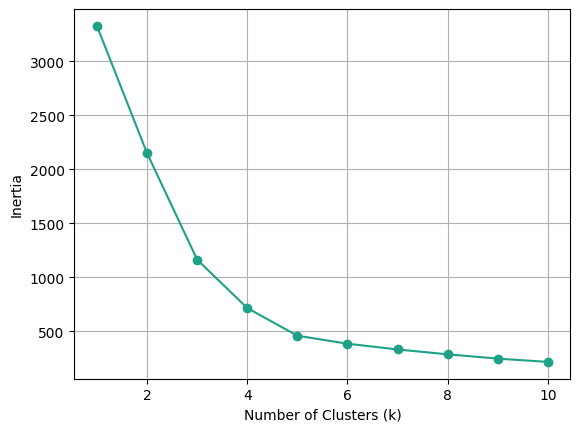

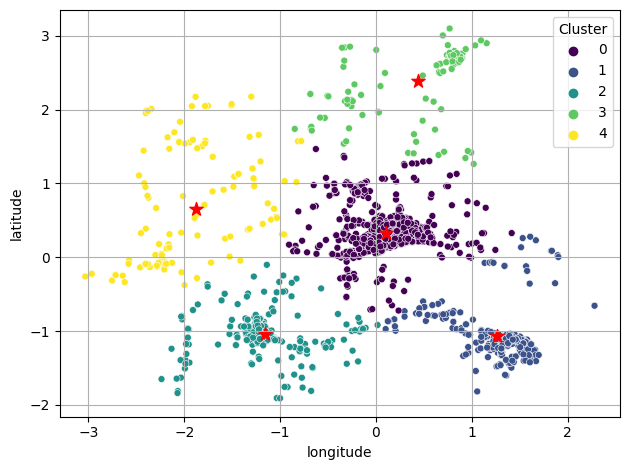

In [189]:
#Apply execute_kmeans_clustering function to humberside_long_lat_features
kmeans_humberside = execute_kmeans_clustering(humberside_long_lat_features, ['Longitude', 'Latitude'])

#Extract the figures and axes from the tuple
fig1, ax1, fig2, ax2 = kmeans_humberside

#Save the figures to PNG files
fig1.savefig('kmeans_humberside_elbow.png')
fig2.savefig('kmeans_humberside.png')

K-means as a baseline model, has identified 5 clusters as optimal (identifed using the elbow method), with a Silhouette and Davies_boulding score of 0.6473 and 0.5727, respectively.

*Agglomerative hierarchical clustering*

Evaluating complete, average and single linkage. Determining optimal k using Silhouette score and Davies_Bouldin index.

Scikit learn (n. d.) Comparing different hierarchical linkage methods on toy datasets. Available online: https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html [Accessed 13/03/2024].

In [190]:
#from sklearn.cluster import AgglomerativeClustering
#Code function for agg clustering to determine optimal k over k_range and then apply dataset and feature names
def calc_optimal_k_agglomerative(data, k_range, linkage):
    """
    Calculate silhouette scores and Davies-Bouldin scores for different numbers of clusters (k) in Agglomerative Clustering.

    Parameters:
    data (pd.DataFrame): The input data containing features.
    k_range (range): Range of values for the number of clusters (k).
    linkage (str): The linkage criterion to use in the Agglomerative Clustering model.

    Returns:
    s_scores (list): Silhouette scores for each value of k.
    db_scores (list): Davies-Bouldin scores for each value of k.
    linkage_values (list): Cluster labels for each value of k.
    """
    s_scores = []
    db_scores = []
    linkage_values = []

    for k in k_range:
        #Create prediction model using desired linkage
        agg_model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        cluster_labels = agg_model.fit_predict(data)
        
        #Determine evaluation metric scores
        silhouette = silhouette_score(data, cluster_labels)
        davies_bouldin = davies_bouldin_score(data, cluster_labels)
        
        #Add to lists
        s_scores.append(silhouette)
        db_scores.append(davies_bouldin)
        linkage_values.append(agg_model.labels_)

    return s_scores, db_scores, linkage_values

def execute_agglomerative_clustering(data, feature_names, linkage='complete', k_range=range(2, 7)):
    """
    Execute Agglomerative Clustering on the given data using specified linkage and determine the optimal number of clusters.

    Parameters:
    data (pd.DataFrame): The input data containing features.
    feature_names (list): Names of the features to be used for clustering.
    linkage (str, optional): The linkage criterion to use in the Agglomerative Clustering model. Default is 'complete'.
    k_range: Range of k values for iterative optmisation of k. Default is range(2,7).

    Returns:
    fig1, ax1 (matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot): Figure and axes for the Silhouette Score plot.
    fig2, ax2 (matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot): Figure and axes for the Davies-Bouldin Score plot.
    fig3, ax3 (matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot): Figure and axes for the final scatter plot.
    """
    #Scale the data
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data)

    #Define a range of k values
    k_range=k_range

    #Find the optimal k using the silhouette Score and Davies-Bouldin Score
    s_scores, db_scores, linkage_values = calc_optimal_k_agglomerative(x_scaled, k_range, linkage)

    #Plot silhouette_scores
    fig1, ax1 = plt.subplots()
    ax1.plot(k_range, s_scores, marker='o')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Silhouette Score')
    
    #Plot davies_bouldin_scores
    fig2, ax2 = plt.subplots()
    ax2.plot(k_range, db_scores, marker='o')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Davies-Bouldin Score')

    #Find the optimal number of clusters based on Silhouette Score
    optimal_k_s = k_range[np.argmax(s_scores)]
    print(f"Optimal number of clusters based on Silhouette Score: {optimal_k_s}")
    
    #Find the optimal number of clusters based on Davies-Bouldin Score
    optimal_k_db = k_range[np.argmin(db_scores)]
    print(f"Optimal number of clusters based on Davies-Bouldin Score: {optimal_k_db}")
    
    #Print optimal Silhouette and Davies-Bouldin Score as well
    print(f"Optimal Silhouette Score: {max(s_scores):.4f} for k={optimal_k_s}")
    print(f"Optimal Davies-Bouldin Score: {min(db_scores):.4f} for k={optimal_k_db}")

    #Create the final Agglomerative Hierarchical Clustering model with the optimal number of clusters using optimal_k_s
    final_agg_model = AgglomerativeClustering(n_clusters=optimal_k_s, linkage=linkage)
    final_agg_model.fit(x_scaled)

    #Predict cluster labels
    cluster_labels_pred = final_agg_model.labels_
    
    #Determine centroids
    centroids = np.zeros((optimal_k_s, x_scaled.shape[1]))
    for i in range(optimal_k_s):
        cluster_points = x_scaled[cluster_labels_pred == i]
        centroids[i] = cluster_points.mean(axis=0)

    #Print scatter plot
    data_with_clusters = pd.DataFrame(data=x_scaled, columns=feature_names)
    data_with_clusters['Cluster'] = cluster_labels_pred

    fig3, ax3 = plt.subplots()
    sns.scatterplot(data=data_with_clusters, x=feature_names[1], y=feature_names[0], hue='Cluster', palette='viridis', s=25, ax=ax3)
    #Plot centroids
    ax3.scatter(centroids[:, 1], centroids[:, 0], marker='*', c='red', s=50)  
    plt.grid(True)
    plt.tight_layout()
    
    return fig1, ax1, fig2, ax2, fig3, ax3

Optimal number of clusters based on Silhouette Score: 5
Optimal number of clusters based on Davies-Bouldin Score: 5
Optimal Silhouette Score: 0.4783 for k=5
Optimal Davies-Bouldin Score: 0.6561 for k=5


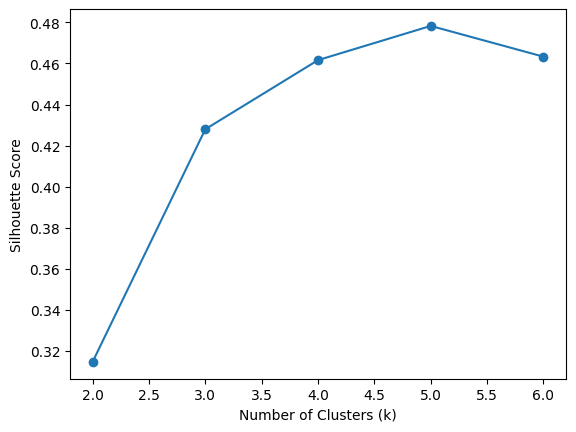

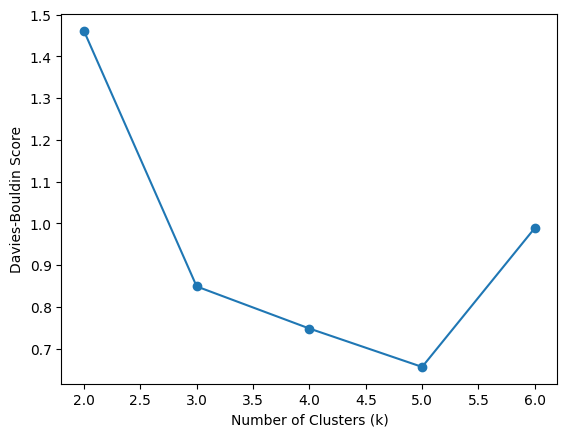

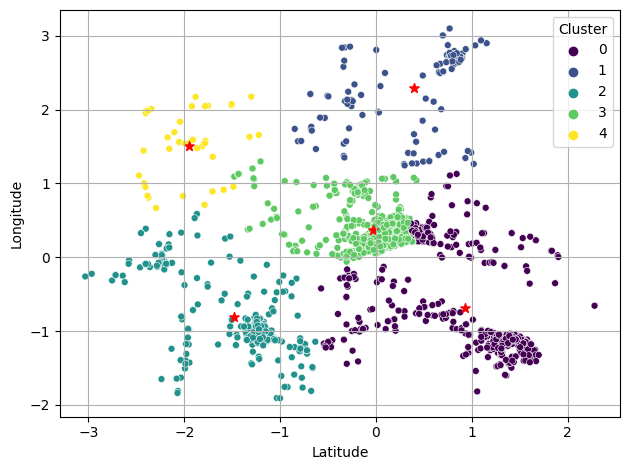

In [191]:
#Run for year of manufacture and mileage with complete linkage
agg_clustering_humberside_complink = execute_agglomerative_clustering(humberside_long_lat_features, ['Longitude', 'Latitude'])

fig1, ax1, fig2, ax2, fig3, ax3 = agg_clustering_humberside_complink
fig1.savefig('agg_clustering_humberside_complink_sscore.png')
fig2.savefig('agg_clustering_humberside_complink_dbindex.png')
fig3.savefig('agg_clustering_humberside_complink.png')

Optimal k for Agg clustering with complete linkage is 5.

Also going to run with average and single linkage to see if can improve evaluation metrics (silhouette score and davies-bouldin index).

Silhouette Score: This metric measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). A silhouette score ranges from -1 to 1. A high silhouette score indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters. Therefore, higher silhouette scores are desirable.

Davies-Bouldin Score: This metric computes the average similarity between each cluster and its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. The Davies-Bouldin score ranges from 0 to positive infinity. The closer to zero the Davies-Bouldin score, the better the clustering. Lower Davies-Bouldin scores indicate better clustering.

The higher the s_score and lower db_score the better the clustering.

Scikit learn (n. d.) sklearn.metrics.davies_bouldin_score. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html [Accessed 13/03/2024].

Scikit learn (n. d.) sklearn.metrics.silhouette_score. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html [Accessed 13/03/2024].

Optimal number of clusters based on Silhouette Score: 6
Optimal number of clusters based on Davies-Bouldin Score: 7
Optimal Silhouette Score: 0.6208 for k=6
Optimal Davies-Bouldin Score: 0.5013 for k=7


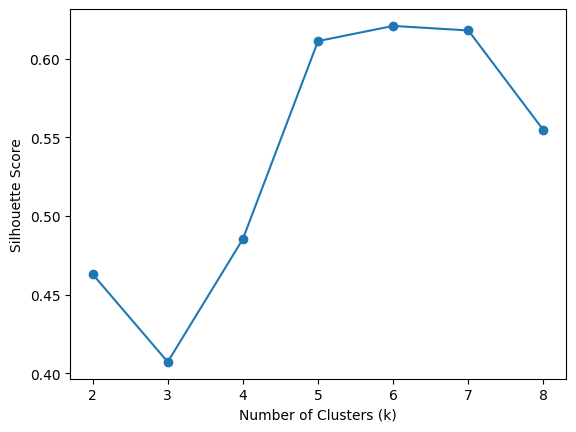

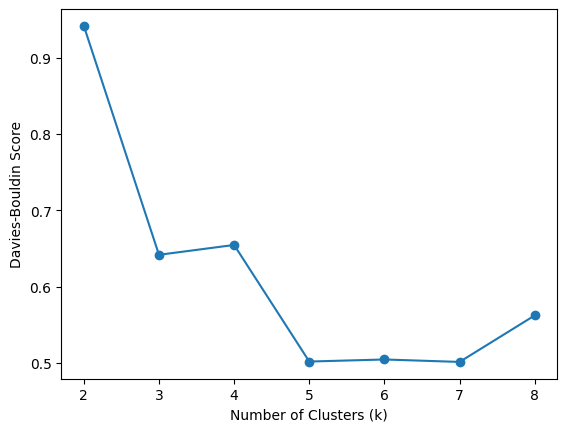

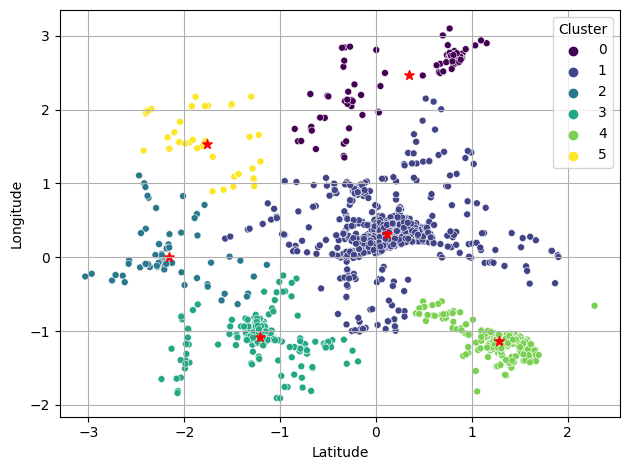

In [192]:
#Run for average linkage
agg_clustering_humberside_avelink = execute_agglomerative_clustering(humberside_long_lat_features, ['Longitude', 'Latitude'], linkage='average', k_range=range(2, 9))

fig1, ax1, fig2, ax2, fig3, ax3 = agg_clustering_humberside_avelink
fig1.savefig('agg_clustering_humberside_avelink_sscore.png')
fig2.savefig('agg_clustering_humberside_avelink_dbindex.png')
fig3.savefig('agg_clustering_humberside_avelink.png')

Clustering is better (indicated by better s_score and db_score) for average linkage compared to complete linkage. Optimal k is one additional cluster. 

According to the evaluation metrics, average linkage agg clustering  performed slightly below that of k-means (euclidean distance).

Optimal Silhouette Score: 0.6208 for k=6
#Optimal Davies-Bouldin Score: 0.50138 for k=7

For k-means:
Silhouette Score: 0.6473
Davies-Bouldin Score: 0.5727

Optimal number of clusters based on Silhouette Score: 2
Optimal number of clusters based on Davies-Bouldin Score: 2
Optimal Silhouette Score: 0.2722 for k=2
Optimal Davies-Bouldin Score: 0.4931 for k=2


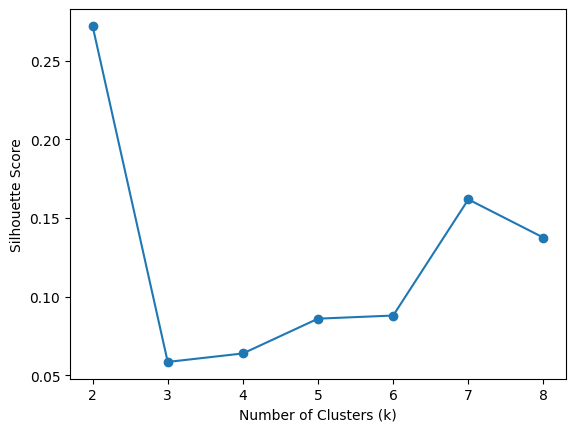

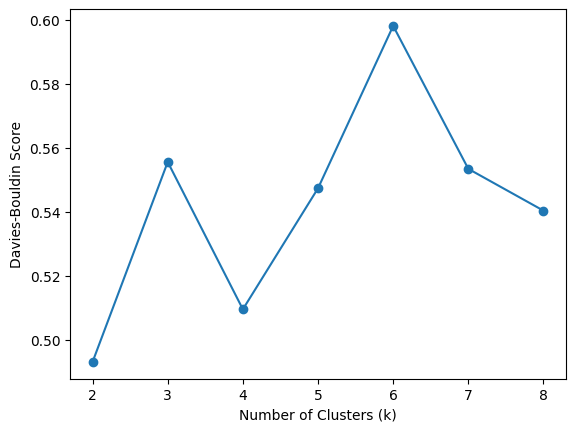

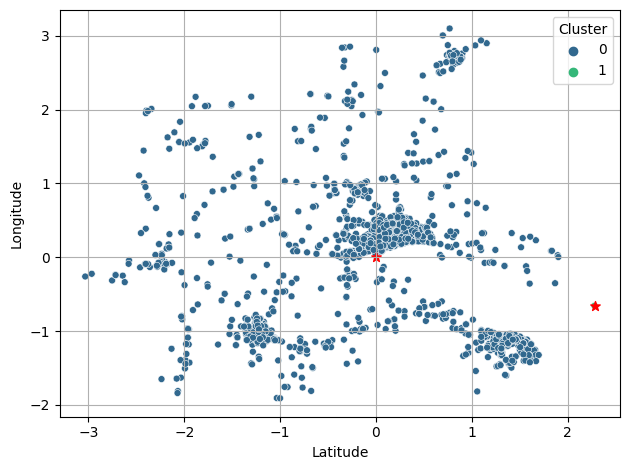

In [193]:
#Run for single linkage
agg_clustering_humberside_singlink = execute_agglomerative_clustering(humberside_long_lat_features, ['Longitude', 'Latitude'], linkage='single', k_range=range(2, 9))

fig1, ax1, fig2, ax2, fig3, ax3 = agg_clustering_humberside_singlink
fig1.savefig('agg_clustering_humberside_singlink_sscore.png')
fig2.savefig('agg_clustering_humberside_singlink_dbindex.png')
fig3.savefig('agg_clustering_humberside_singlink.png')

Single linkage performed poorly compared to average and complete linkage.

*K-medoids*

pip install scikit-learn-extra

Scikit learn extra (n. d.) sklearn_extra.cluster.KMedoids. Available online: https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html [Accessed 14/03/2024].

Determining optimal k using Silhouette score and Davies_Bouldin index.

K-medoids clustering, unlike K-means, does not directly use inertia as a metric for evaluating cluster quality because it relies on medoids (data points with the smallest sum of dissimilarities to all other points in the cluster) rather than centroids. Therefore, the concept of inertia, which measures the sum of squared distances between data points and their assigned centroid, doesn't directly apply to k-medoids.

In [194]:
#from sklearn_extra.cluster import KMedoids
#Function for k-medoids clustering
def calc_optimal_k_kmedoids(data, k_range):
    """
    Calculate silhouette scores and Davies-Bouldin scores for different numbers of clusters (k) in KMedoids Clustering.

    Parameters:
    data (pd.DataFrame): The input data containing features.
    k_range (range): Range of values for the number of clusters (k).

    Returns:
    s_scores (list): Silhouette scores for each value of k.
    db_scores (list): Davies-Bouldin scores for each value of k.
    """
    s_scores = []
    db_scores = []

    for k in k_range:
        kmedoids_model = KMedoids(n_clusters=k, random_state=42)
        cluster_labels = kmedoids_model.fit_predict(data)
        silhouette = silhouette_score(data, cluster_labels)
        davies_bouldin = davies_bouldin_score(data, cluster_labels)
        s_scores.append(silhouette)
        db_scores.append(davies_bouldin)

    return s_scores, db_scores

def execute_kmedoids_clustering(data, feature_names, k_range=range(2, 11)):
    """
    Execute KMedoids Clustering on the given data and determine the optimal number of clusters.

    Parameters:
    data (pd.DataFrame): The input data containing features.
    feature_names (list): Names of the features to be used for clustering.
    k_range: Range of k values for iterative optmisation of k. Default is range(2, 11).

    Returns:
    fig1, ax1 (matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot): Figure and axes for the Silhouette Score plot.
    fig2, ax2 (matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot): Figure and axes for the Davies-Bouldin Score plot.
    fig3, ax3 (matplotlib.figure.Figure, matplotlib.axes._subplots.AxesSubplot): Figure and axes for the final scatter plot.
    """
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data)
    k_range=k_range 

    s_scores, db_scores = calc_optimal_k_kmedoids(x_scaled, k_range)

    fig1, ax1 = plt.subplots()
    ax1.plot(k_range, s_scores, marker='o')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Silhouette Score')

    fig2, ax2 = plt.subplots()
    ax2.plot(k_range, db_scores, marker='o')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Davies-Bouldin Score')

    optimal_k_s = k_range[np.argmax(s_scores)]
    optimal_k_db = k_range[np.argmin(db_scores)]
    print(f"Optimal number of clusters based on Silhouette Score: {optimal_k_s}")
    print(f"Optimal number of clusters based on Davies-Bouldin Score: {optimal_k_db}")
    print(f"Optimal Silhouette Score: {max(s_scores):.4f} for k={optimal_k_s}")
    print(f"Optimal Davies-Bouldin Score: {min(db_scores):.4f} for k={optimal_k_db}")

    final_kmedoids_model = KMedoids(n_clusters=optimal_k_s, random_state=42)
    final_kmedoids_model.fit(x_scaled)
    cluster_labels_pred = final_kmedoids_model.labels_

    centroids = final_kmedoids_model.cluster_centers_

    data_with_clusters = pd.DataFrame(data=x_scaled, columns=feature_names)
    data_with_clusters['Cluster'] = cluster_labels_pred

    fig3, ax3 = plt.subplots()
    sns.scatterplot(data=data_with_clusters, x=feature_names[1], y=feature_names[0], hue='Cluster', palette='viridis', s=25, ax=ax3)
    ax3.scatter(centroids[:, 1], centroids[:, 0], marker='*', c='red', s=50)  # Plot centroids
    ax3.grid(True)

    plt.tight_layout()
    
    return fig1, ax1, fig2, ax2, fig3, ax3

Optimal number of clusters based on Silhouette Score: 4
Optimal number of clusters based on Davies-Bouldin Score: 3
Optimal Silhouette Score: 0.5737 for k=4
Optimal Davies-Bouldin Score: 0.6395 for k=3


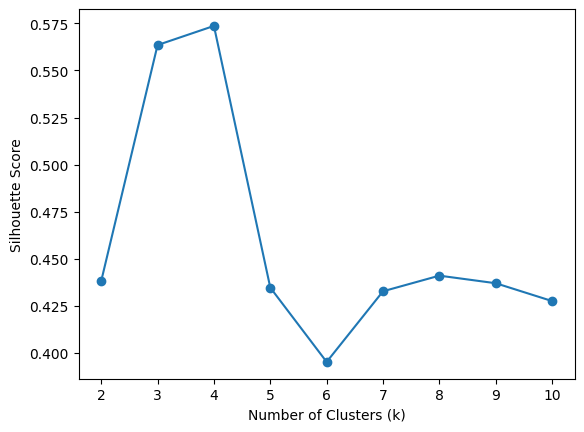

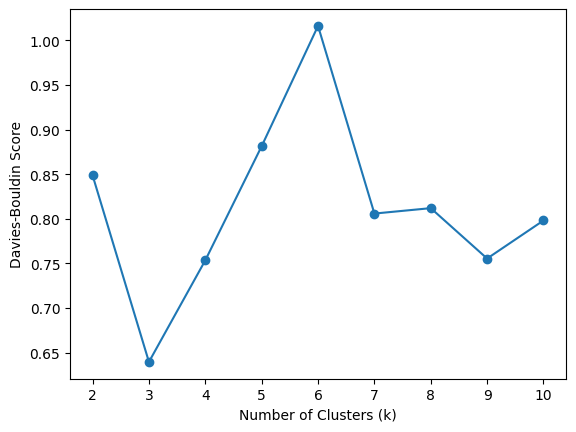

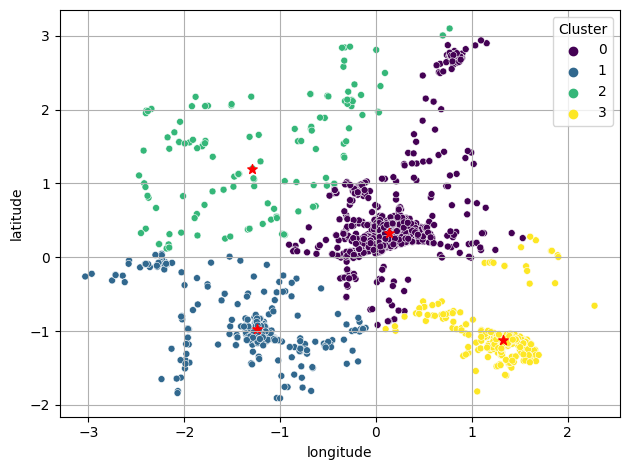

In [195]:
kmediods_humberside = execute_kmedoids_clustering(humberside_long_lat_features, ['latitude', 'longitude'])

fig1, ax1, fig2, ax2, fig3, ax3 = kmediods_humberside
fig1.savefig('kmediods_humberside_sscore.png')
fig2.savefig('kmediods_humberside_dbindex.png')
fig3.savefig('kmediods_humberside.png')

*Summary of clustering models*

K-means is still the superior clustering model with best evaluation metrics:

Silhouette Score: 0.6473 Davies-Bouldin Score: 0.5727 with k=5.

Average linkage agglomerative clustering also performed well (Silhouette Score: 0.6208 for k=6).

*Folium map plot showing key density hotspots*

In [196]:
def plot_clusters_and_centroids(df, zoom_start=9):
    """
    Plots cluster data points and centroids on a Folium map.

    Parameters:
        data_with_clusters (DataFrame): DataFrame containing data points with cluster assignments.
        centroids (list): List of tuples containing centroid coordinates (latitude, longitude).
        map_center (list, optional): Center coordinates of the map. Default is Humberside center.
        zoom_start (int, optional): Initial zoom level of the map. Default is 10.

    Returns:
        map (folium.Map): Folium map object.
    """
    #Create a base map centered around the mean of accident coordinates
    base_map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=zoom_start)

    #Plot cluster data points
    for _, row in df.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=2.5,
            color=None,
            fill=True,
            fill_color='black',
            fill_opacity=0.4,
        ).add_to(base_map)

    return base_map

humberside_map = plot_clusters_and_centroids(humberside_long_lat_features)
humberside_map

In [197]:
humberside_map.save("humberside_map.png")

What do these clusters reveal about the distribution of accidents in our region? 

Accidents cluster geographically around major cities in the Humberside region, like Hull, Scunthorpe, Grimsby and Bridlington. 

*Clusters showing the effect of speed limit and weather conditions on accident occurrence*

Will run for entire dataset (accident_df) and humberside region (humberside_accident_df)

In [198]:
#Create features to input into K-means
#Speed_limit and weather_conditions for all data in accident_df
speedlimit_weather_features = accident_df[['speed_limit', 'weather_conditions']]
#Speed_limit and weather_conditions for humberside_accident_df
humberside_speedlimit_weather_features = humber_accident_df[['speed_limit', 'weather_conditions']]

In [199]:
#Run model with 6 clusters (pre-defined based on number of speed limit categories (6))
def perform_clustering_defined_k(features_df, k):
    """
    Perform KMeans clustering on the specified features DataFrame with the given number of clusters (k).

    Parameters:
    features_df (DataFrame): DataFrame containing the features to be clustered.
    k (int): Number of clusters for KMeans clustering.

    Returns:
    kmeans (model): Kmeans model
    cluster_df (DataFrame): DataFrame containing the features along with the cluster labels.
    """

    #Initialize KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')

    #Fit the model to the data
    kmeans.fit(features_df)

    #Get cluster labels
    cluster_labels = kmeans.labels_

    #Create a new df with cluster results and features columns
    cluster_df = pd.DataFrame(features_df)
    cluster_df['cluster'] = cluster_labels

    return kmeans, cluster_df

In [200]:
#Run perform_clustering_defined_k with k=6
kmeans, cluster_df = perform_clustering_defined_k(speedlimit_weather_features, k=6)

In [201]:
def plot_cluster_distance(data, k):
    """
    Plot data points colored by cluster and sized based on their distance to the centroids.

    Parameters:
        data (pd.DataFrame): DataFrame containing data points with cluster assignments.
        k (int): Number of clusters.

    Returns:
        fig (matplotlib.figure.Figure): Matplotlib figure object.
    """
    #Calculate centroids
    centroids = data.groupby('cluster').mean()

    #Calculate distances of each point from centroids
    distances = np.linalg.norm(data[['weather_conditions', 'speed_limit']].values - centroids.values[:, np.newaxis], axis=2)

    #Get minimum distance for each point
    min_distances = np.min(distances, axis=0)

    #Plot figure
    fig, ax = plt.subplots(figsize=(8, 6))
    for cluster_label in range(k):
        cluster_data = data[data['cluster'] == cluster_label]
        cluster_distances = distances[cluster_label]
        plt.scatter(cluster_data['weather_conditions'], cluster_data['speed_limit'],
                    s=1,
                    alpha=1 - (cluster_distances / np.max(cluster_distances)), 
                    label=f'Cluster {cluster_label}')

    #Plot centroids
    plt.scatter(centroids['weather_conditions'], centroids['speed_limit'], marker='*', color='red', label='Centroids')

    plt.xlabel('Weather Conditions')
    plt.ylabel('Speed Limit (mph)')

    plt.tight_layout()
    
    return fig

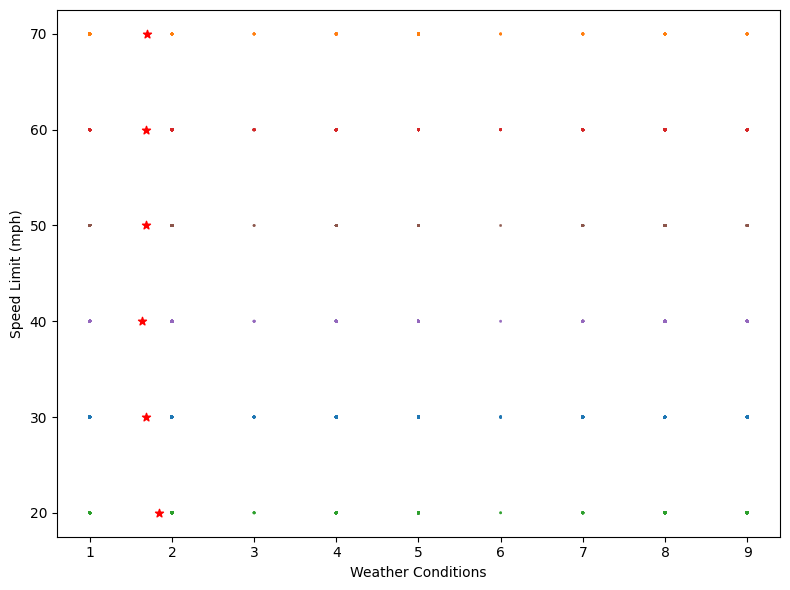

In [202]:
#Visualise using function
all_weather_speed_limit = plot_cluster_distance(cluster_df, k=6)

Clustering speed limits and weather conditions (k=6) highlighted cluster centroids for all speed limits under weather condition 2 (Raining without high winds) fo all data in accident_df.

In [203]:
#Run perform_clustering_defined_k with k=6 for humberside data
kmeans_2, cluster_df_2 = perform_clustering_defined_k(humberside_speedlimit_weather_features, k=6)

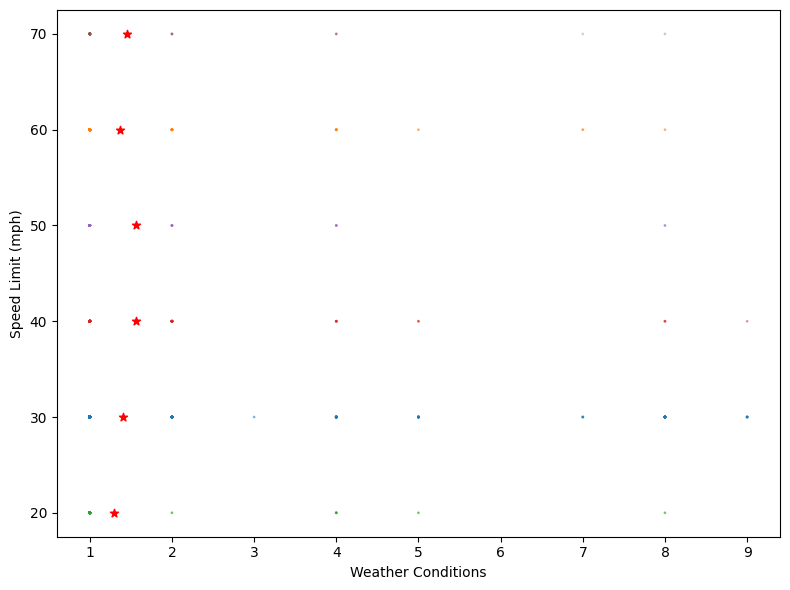

In [204]:
#Visualise using function
humberside_weather_speed_limit = plot_cluster_distance(cluster_df_2, k=6)

Clustering speed limits and weather conditions (k=6) for the humberside region only highlighted a couple of centroids under weather condition 2 (Raining without high winds) with a few closer to 1 (Fine without high winds) for both lower and higher speed_limits.

Determine if fog and mist are big factors at certain speed limits by increasing clusters to 12.

In [205]:
#Run perform_clustering_defined_k with k=12 for all data in accident_df
kmeans_3, cluster_df_3 = perform_clustering_defined_k(speedlimit_weather_features, k=12)

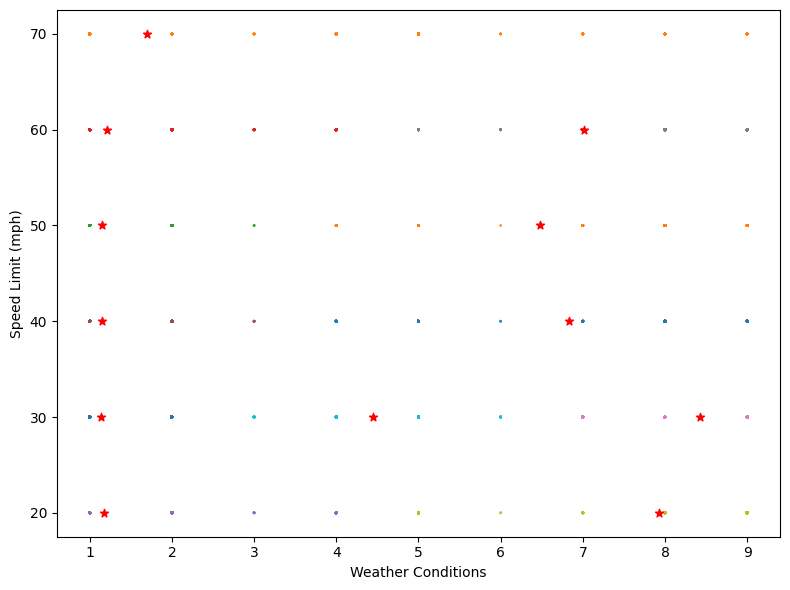

In [206]:
#Visualise using function
all_weather_speed_limit_12clusters = plot_cluster_distance(cluster_df_3, k=12)

Fog or mist is category 7 in weather_conditions. There is a centroid for cluster at 60mph for fog/mist and very near for 40 mph too.

In [207]:
#Run perform_clustering_defined_k with k=12 for humberside
kmeans_4, cluster_df_4 = perform_clustering_defined_k(humberside_speedlimit_weather_features, k=12)

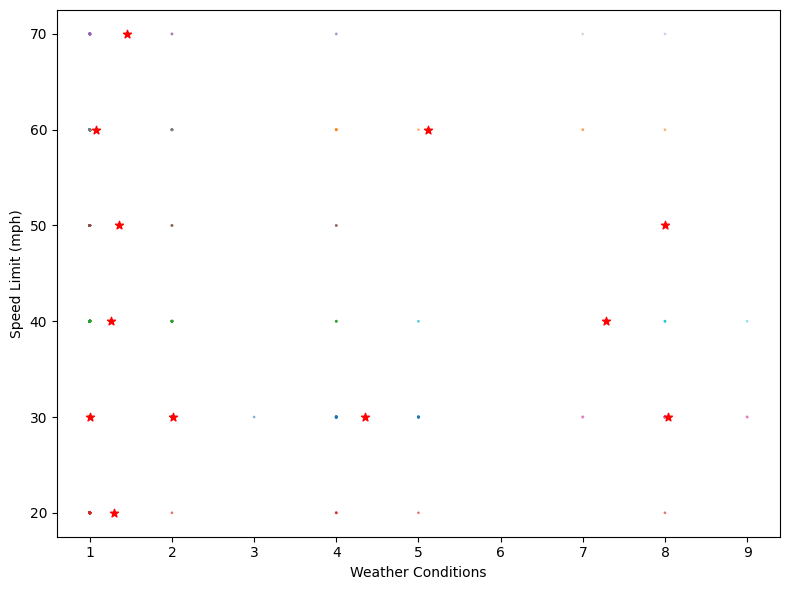

In [208]:
#Visualise using function
humberside_weather_speed_limit_12clusters = plot_cluster_distance(cluster_df_4, k=12)

For accidents at 60mph in humberside weather conditions are raining with high winds (5), in contrast to the national picture of fog/mist a 60mph.

*6. Outlier Detection*

Using outlier detection methods, identify unusual entries in your data set. Should you keep these entries in your data? 

Analysis undertaken in this section:

1. IQR and Grubb's test on numerical columns age_of_vehicle and age_of_driver in vehicle_df and age_of_casualty in casualty_df
2. Isolation Forest, Local Outlier Factor and DBSCAN for multivariate location (coordinate) data for all data and humberside
3. Optmising for n_neighbours for LOF
4. Folium map of best outlier detection method for humberside

*Numerical series/column outlier detection*

*IQR*

Geeks for geeks (n. d.) Interquartile range and quartile deviation using NumPy and SciPy. Available online: https://www.geeksforgeeks.org/interquartile-range-and-quartile-deviation-using-numpy-and-scipy/ [Accessed 17/03/2024].

Implement a function which returns the upper quartile + 1.5*IQR and lower quartile – 1.5*IQR of age_of_vehicle and age_of_driver in vehicle_df and age_of_casualty in casualty_df. 

In [209]:
#Function to calculate outlier bounds using 1.5*IQR
def get_outlier_bounds(data):
    """
    Calculate upper and lower bounds for outliers using quartiles and IQR.

    Parameters:
    data (Pandas Series or array-like): Input data.

    Returns:
    tuple: Lower bound and upper bound for outliers.
    """
    #Calculate quartiles
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    #Calculate IQR
    IQR = Q3 - Q1
    
    #Calculate lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return lower_bound, upper_bound

In [210]:
#Run function on age of driver in vehicle_df
lower_bound_age_driver, upper_bound_age_driver = get_outlier_bounds(vehicle_df['age_of_driver'])
print("Lower Bound for Age of Driver:", lower_bound_age_driver)
print("Upper Bound for Age of Driver:", upper_bound_age_driver)

Lower Bound for Age of Driver: 1.5
Upper Bound for Age of Driver: 77.5


The upper bound for age_of_driver is not high enough based on 1.5xIQR. It is feasible that drivers involved in accidents would be older than 77.5 years.

In [211]:
#Run function on age of vehicle in vehicle_df
lower_bound_age_vehicle, upper_bound_age_vehicle = get_outlier_bounds(vehicle_df['age_of_vehicle'])
print("Lower Bound for Age of Vehicle:", lower_bound_age_vehicle)
print("Upper Bound for Age of Vehicle:", upper_bound_age_vehicle)

Lower Bound for Age of Vehicle: -4.0
Upper Bound for Age of Vehicle: 20.0


The upper bound for age_of_vehicle is also not high enough based on 1.5xIQR as there is the possibility that vehicles older than 20 years could be involved in accidents.

In [212]:
#Run function on age of casualty in casualty_df
lower_bound_age_casualty, upper_bound_age_casualty = get_outlier_bounds(casualty_df['age_of_casualty'])
print("Lower Bound for Age of Casualty:", lower_bound_age_casualty)
print("Upper Bound for Age of Casualty:", upper_bound_age_casualty)

Lower Bound for Age of Casualty: -15.0
Upper Bound for Age of Casualty: 89.0


In [213]:
#Filter vehicle_df for values outside the outlier bounds
outliers_age_vehicle = vehicle_df[(vehicle_df['age_of_vehicle'] < lower_bound_age_vehicle) | (vehicle_df['age_of_vehicle'] > upper_bound_age_vehicle)]
outliers_age_driver = vehicle_df[(vehicle_df['age_of_driver'] < lower_bound_age_driver) | (vehicle_df['age_of_driver'] > upper_bound_age_driver)]
outliers_age_casualty = casualty_df[(casualty_df['age_of_casualty'] < lower_bound_age_casualty) | (casualty_df['age_of_casualty'] > upper_bound_age_casualty)]

print("Outliers in 'age_of_vehicle' column:")
display(outliers_age_vehicle)
print("\nOutliers in 'age_of_driver' column:")
display(outliers_age_driver)
print("\nOutliers in 'age_of_casualty' column:")
display(outliers_age_casualty)

Outliers in 'age_of_vehicle' column:


vehicle_index accident_index  accident_year accident_reference  \
97             681813  2020010228250           2020          010228250   
683            682399  2020010229391           2020          010229391   
709            682425  2020010229450           2020          010229450   
803            682519  2020010229602           2020          010229602   
847            682563  2020010229701           2020          010229701   
...               ...            ...            ...                ...   
166704         848420  2020991002465           2020          991002465   
166718         848434  2020991002805           2020          991002805   
166826         848542  2020991004522           2020          991004522   
166939         848655  2020991006355           2020          991006355   
167336         849052  2020991015016           2020          991015016   

        vehicle_reference  vehicle_type  towing_and_articulation  \
97                      2             9                      0.0   
683                     2             9                      0.0   
709                     2             9                      0.0   
803                     2             9                      0.0   
847                     1             9                      0.0   
...                   ...           ...                      ...   
166704                  2            90                      0.0   
166718                  2             9                      0.0   
166826                  1             9                      0.0   
166939                  1             9                      0.0   
167336                  1             9                      0.0   

        vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
97                    5.0                     5.0                   1.0  ...   
683                  18.0                     7.0                   3.0  ...   
709                   3.0                     7.0                   3.0  ...   
803                   4.0                     5.0                   1.0  ...   
847                  99.0                     9.0                   9.0  ...   
...                   ...                     ...                   ...  ...   
166704               18.0                     5.0                   1.0  ...   
166718               10.0                     3.0                   8.0  ...   
166826                9.0                     3.0                   1.0  ...   
166939               16.0                     4.0                   7.0  ...   
167336               18.0                     1.0                   5.0  ...   

        sex_of_driver  age_of_driver  age_band_of_driver  engine_capacity_cc  \
97                1.0           34.0                 6.0               973.0   
683               1.0           64.0                 9.0              2962.0   
709               1.0           31.0                 6.0              1242.0   
803               3.0           38.0                 NaN              1360.0   
847               1.0           45.0                 7.0              1108.0   
...               ...            ...                 ...                 ...   
166704            1.0           53.0                 8.0              1952.0   
166718            2.0           36.0                 7.0              1896.0   
166826            2.0           89.0                11.0              1124.0   
166939            1.0           19.0                 4.0              1199.0   
167336            1.0           19.0                 4.0              2500.0   

        propulsion_code  age_of_vehicle   generic_make_model  \
97                  1.0            22.0       VAUXHALL CORSA   
683                 1.0            28.0                  NaN   
709                 1.0            21.0          FORD FIESTA   
803                 1.0            28.0                  NaN   
847                 1.0            32.0                  NaN


Outliers in 'age_of_driver' column:


vehicle_index accident_index  accident_year accident_reference  \
40             681756  2020010228110           2020          010228110   
64             681780  2020010228164           2020          010228164   
111            681827  2020010228276           2020          010228276   
182            681898  2020010228395           2020          010228395   
294            682010  2020010228588           2020          010228588   
...               ...            ...            ...                ...   
167062         848778  2020991008391           2020          991008391   
167079         848795  2020991008551           2020          991008551   
167255         848971  2020991010939           2020          991010939   
167305         849021  2020991012356           2020          991012356   
167343         849059  2020991016435           2020          991016435   

        vehicle_reference  vehicle_type  towing_and_articulation  \
40                      2             9                      0.0   
64                      1             9                      0.0   
111                     1             9                      0.0   
182                     1             9                      0.0   
294                     1             9                      0.0   
...                   ...           ...                      ...   
167062                  1             9                      0.0   
167079                  1             1                      0.0   
167255                  1             9                      0.0   
167305                  1             9                      0.0   
167343                  1             9                      0.0   

        vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
40                   18.0                     1.0                   5.0  ...   
64                   99.0                     9.0                   9.0  ...   
111                  18.0                     1.0                   5.0  ...   
182                  14.0                     1.0                   5.0  ...   
294                   4.0                     2.0                   6.0  ...   
...                   ...                     ...                   ...  ...   
167062               18.0                     5.0                   2.0  ...   
167079                5.0                     2.0                   6.0  ...   
167255               18.0                     5.0                   1.0  ...   
167305                9.0                     6.0                   4.0  ...   
167343                9.0                     7.0                   6.0  ...   

        sex_of_driver  age_of_driver  age_band_of_driver  engine_capacity_cc  \
40                2.0           79.0                11.0              1386.0   
64                2.0           81.0                11.0              1388.0   
111               1.0           88.0                11.0              1388.0   
182               1.0           80.0                11.0              1596.0   
294               1.0           85.0                11.0              1591.0   
...               ...            ...                 ...                 ...   
167062            2.0           78.0                11.0              1200.0   
167079            1.0           83.0                11.0              1596.0   
167255            1.0           86.0                11.0              1332.0   
167305            1.0           83.0                11.0               898.0   
167343            1.0           87.0                11.0               998.0   

        propulsion_code  age_of_vehicle  generic_make_model  \
40                  1.0             9.0         NISSAN NOTE   
64                  1.0             8.0         FORD FIESTA   
111                 1.0            15.0         FORD FIESTA   
182                 1.0            14.0        BMW 1 SERIES   
294                 1.0             6.0         HYUNDAI I30   
..


Outliers in 'age_of_casualty' column:


casualty_index accident_index  accident_year accident_reference  \
492             485240  2020010229497           2020          010229497   
657             485405  2020010229955           2020          010229955   
1136            485884  2020010231303           2020          010231303   
1629            486377  2020010232619           2020          010232619   
3039            487787  2020010236161           2020          010236161   
...                ...            ...            ...                ...   
113469          598217  2020990972908           2020          990972908   
113704          598452  2020990976734           2020          990976734   
114841          599589  2020990998622           2020          990998622   
115160          599908  2020991004453           2020          991004453   
115372          600120  2020991009022           2020          991009022   

        vehicle_reference  casualty_reference  casualty_class  \
492                     1                   1               3   
657                     1                   1               3   
1136                    1                   1               2   
1629                    1                   1               1   
3039                    2                   1               1   
...                   ...                 ...             ...   
113469                  1                   2               2   
113704                  2                   1               2   
114841                  1                   1               3   
115160                  1                   1               3   
115372                  1                   1               2   

        sex_of_casualty  age_of_casualty  age_band_of_casualty  \
492                 2.0             91.0                  11.0   
657                 1.0             92.0                  11.0   
1136                1.0             94.0                  11.0   
1629                1.0             90.0                  11.0   
3039                1.0             90.0                  11.0   
...                 ...              ...                   ...   
113469              2.0             94.0                  11.0   
113704              2.0             90.0                  11.0   
114841              1.0             90.0                  11.0   
115160              2.0             91.0                  11.0   
115372              2.0             92.0                  11.0   

        casualty_severity  pedestrian_location  pedestrian_movement  \
492                     2                  4.0                  1.0   
657                     2                  5.0                  3.0   
1136                    3                  0.0                  0.0   
1629                    3                  0.0                  0.0   
3039                    3                  0.0                  0.0   
...                   ...                  ...                  ...   
113469                  3                  0.0                  0.0   
113704                  3                  0.0                  0.0   
114841                  1                  1.0                  1.0   
115160                  2                  4.0                  1.0   
115372                  3                  0.0                  0.0   

        car_passenger  bus_or_coach_passenger  \
492               0.0                     0.0   
657               0.0                     0.0   
1136              0.0                     3.0   
1629              0.0                     0.0   
3039              0.0                     0.0   
...               ...                     ...   
113469            1.0                     0.0   
113704            1.0                     0.0   
114841            0.0                     0.0   
115160            0.0                     0.0   
115372            0.0                     3.0   

        pedestrian_road_maintenance_worker  casualty_type  \
492                           

In [214]:
#Filter outliers_age_vehicle for age_of_vehicle greater than 60 years
outliers_age_vehicle_gt_60 = outliers_age_vehicle[outliers_age_vehicle['age_of_vehicle'] > 60]
display(outliers_age_vehicle_gt_60)

vehicle_index accident_index  accident_year accident_reference  \
17199          698915  2020010255926           2020          010255926   
42144          723860  2020040971403           2020          040971403   
52983          734699  2020070369975           2020          070369975   
53684          735400  2020070570120           2020          070570120   
64149          745865  20201379K1053           2020          1379K1053   
71464          753180  2020160983383           2020          160983383   
88096          769812  2020302000837           2020          302000837   
94450          776166  2020320565329           2020          320565329   
97872          779588  2020340N02292           2020          340N02292   
98387          780103  2020340S05342           2020          340S05342   
108173         789889  2020410958551           2020          410958551   
122650         804366  2020440284524           2020          440284524   
130714         812430  2020460936761           2020          460936761   
139672         821388  2020470977558           2020          470977558   
140671         822387  2020470990781           2020          470990781   
143617         825333  2020500954946           2020          500954946   
144710         826426  2020500979312           2020          500979312   
144821         826537  2020500981918           2020          500981918   
145115         826831  2020500988344           2020          500988344   
160538         842254  202063D032220           2020          63D032220   
160606         842322  202063D044220           2020          63D044220   
165209         846925  2020990980802           2020          990980802   
165289         847005  2020990982344           2020          990982344   

        vehicle_reference  vehicle_type  towing_and_articulation  \
17199                   2             3                      0.0   
42144                   1             5                      0.0   
52983                   1             9                      0.0   
53684                   1             5                      0.0   
64149                   2             9                      0.0   
71464                   1             9                      0.0   
88096                   1             4                      0.0   
94450                   1             4                      0.0   
97872                   2             9                      0.0   
98387                   1             9                      0.0   
108173                  1             9                      0.0   
122650                  1             4                      0.0   
130714                  2             3                      0.0   
139672                  1             9                      0.0   
140671                  2             5                      0.0   
143617                  1             9                      0.0   
144710                  2             9                      4.0   
144821                  1             9                      0.0   
145115                  1             9                      0.0   
160538                  1            17                      4.0   
160606                  1             4                      0.0   
165209                  1             5                      5.0   
165289                  2             5                      0.0   

        vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
17199                99.0                     9.0                   9.0  ...   
42144                18.0                     8.0                   4.0  ...   
52983                18.0                     6.0                   2.0  ...   
53684                18.0                     8.0                   4.0  ...   
64149                18.0                     4.0                   8.0  ...   
71464                13.0                     3.0                   7.0  ...   
88096                18.0             

Vehicles older than 40 years of age are considered classic vehicles for tax purposes.

GOV.UK (n. d.) Historic (classic) vehicles: MOT and vehicle tax. Available online: https://www.gov.uk/historic-vehicles/vehicles-exempt-from-vehicle-tax [Accessed 17/03/2024].

Not much information in make/model column to determine if vehciles are older makes, 1 instance of Lambretta and 3 Triumph which correlates with older vehicles. 

While a 96-year-old vehicle is technically possible, it is unlikely.

Vehicle types are a mix of cars, 1 van, motorcycles and an 86 year old pedal cycle (possible but unlikely).

While it's conceivable that a well-maintained vintage bicycle could survive for several decades, it would be extremely rare for a pedal cycle to remain in operational condition after 86 years. 

Fluxsposure (2023) When does a car become a classic? Available online: https://www.adrianflux.co.uk/blog/2023/02/when-car-become-classic/ [Accessed 17/03/2024].

Impossible to determine from data in vehicle_df if the older vehicles are outliers due to error so keeping them in.

In [215]:
#Filter outliers_age_driver for age_of_driver greater than 95 years
outliers_age_driver_gt_95 = outliers_age_driver[outliers_age_driver['age_of_driver'] > 95]
display(outliers_age_driver_gt_95)

vehicle_index accident_index  accident_year accident_reference  \
23056          704772  2020010264159           2020          010264159   
43348          725064  2020040996792           2020          040996792   
59658          741374  2020122000903           2020          122000903   
65353          747069  2020137CE0758           2020          137CE0758   
67465          749181  2020140966046           2020          140966046   
75790          757506  2020200951453           2020          200951453   
86523          768239  2020230996604           2020          230996604   
89737          771453  202031A079120           2020          31A079120   
92216          773932  202031D105320           2020          31D105320   
92487          774203  202031D181520           2020          31D181520   
99939          781655  2020350972931           2020          350972931   
109650         791366  2020411009619           2020          411009619   
110607         792323  2020420931003           2020          420931003   
123471         805187  2020440357259           2020          440357259   
130837         812553  2020460939007           2020          460939007   
132494         814210  2020460965242           2020          460965242   
137368         819084  2020470940023           2020          470940023   
164561         846277  2020990972908           2020          990972908   

        vehicle_reference  vehicle_type  towing_and_articulation  \
23056                   1             9                      0.0   
43348                   2             9                      0.0   
59658                   1             9                      0.0   
65353                   1             9                      0.0   
67465                   1             9                      0.0   
75790                   2             9                      0.0   
86523                   1            22                      0.0   
89737                   1             9                      0.0   
92216                   2             9                      0.0   
92487                   1             9                      0.0   
99939                   1             9                      0.0   
109650                  1             9                      0.0   
110607                  1             9                      0.0   
123471                  2            22                      0.0   
130837                  2             9                      0.0   
132494                  1             9                      0.0   
137368                  1             9                      0.0   
164561                  1             9                      0.0   

        vehicle_manoeuvre  vehicle_direction_from  vehicle_direction_to  ...  \
23056                 5.0                     1.0                   5.0  ...   
43348                18.0                     7.0                   3.0  ...   
59658                 5.0                     1.0                   5.0  ...   
65353                 7.0                     1.0                   3.0  ...   
67465                15.0                     5.0                   1.0  ...   
75790                18.0                     5.0                   1.0  ...   
86523                18.0                     7.0                   3.0  ...   
89737                18.0                     4.0                   8.0  ...   
92216                18.0                     1.0                   5.0  ...   
92487                18.0                     5.0                   1.0  ...   
99939                18.0                     5.0                   1.0  ...   
109650               18.0                     6.0                   2.0  ...   
110607               18.0                     4.0                   8.0  ...   
123471                5.0                     8.0                   4.0  ...   
130837               18.0                     3.0                   7.0  ...   
132494               18.0   

There are no drivers over age 100 so this seems feasible. There is also no legislation implementing an upper age limit on driving legally in the UK. No outliers removed.

In [216]:
#Filter outliers_age_casualty for age_of_casualty greater than 90 years
outliers_age_casualty_gt_90 = outliers_age_casualty[outliers_age_casualty['age_of_casualty'] > 90]
display(outliers_age_casualty_gt_90)

casualty_index accident_index  accident_year accident_reference  \
492             485240  2020010229497           2020          010229497   
657             485405  2020010229955           2020          010229955   
1136            485884  2020010231303           2020          010231303   
3105            487853  2020010236342           2020          010236342   
3950            488698  2020010238470           2020          010238470   
...                ...            ...            ...                ...   
113130          597878  2020990967610           2020          990967610   
113468          598216  2020990972908           2020          990972908   
113469          598217  2020990972908           2020          990972908   
115160          599908  2020991004453           2020          991004453   
115372          600120  2020991009022           2020          991009022   

        vehicle_reference  casualty_reference  casualty_class  \
492                     1                   1               3   
657                     1                   1               3   
1136                    1                   1               2   
3105                    1                   1               2   
3950                    2                   1               1   
...                   ...                 ...             ...   
113130                  1                   1               2   
113468                  1                   1               1   
113469                  1                   2               2   
115160                  1                   1               3   
115372                  1                   1               2   

        sex_of_casualty  age_of_casualty  age_band_of_casualty  \
492                 2.0             91.0                  11.0   
657                 1.0             92.0                  11.0   
1136                1.0             94.0                  11.0   
3105                1.0             93.0                  11.0   
3950                1.0             94.0                  11.0   
...                 ...              ...                   ...   
113130              2.0             91.0                  11.0   
113468              1.0             96.0                  11.0   
113469              2.0             94.0                  11.0   
115160              2.0             91.0                  11.0   
115372              2.0             92.0                  11.0   

        casualty_severity  pedestrian_location  pedestrian_movement  \
492                     2                  4.0                  1.0   
657                     2                  5.0                  3.0   
1136                    3                  0.0                  0.0   
3105                    2                  0.0                  0.0   
3950                    2                  0.0                  0.0   
...                   ...                  ...                  ...   
113130                  3                  0.0                  0.0   
113468                  2                  0.0                  0.0   
113469                  3                  0.0                  0.0   
115160                  2                  4.0                  1.0   
115372                  3                  0.0                  0.0   

        car_passenger  bus_or_coach_passenger  \
492               0.0                     0.0   
657               0.0                     0.0   
1136              0.0                     3.0   
3105              0.0                     3.0   
3950              0.0                     0.0   
...               ...                     ...   
113130            0.0                     3.0   
113468            0.0                     0.0   
113469            1.0                     0.0   
115160            0.0                     0.0   
115372            0.0                     3.0   

        pedestrian_road_maintenance_worker  casualty_type  \
492                           

Also feasible to have casualties over 90 years old.

*Limitations of IQR outlier method*

While the IQR outlier method is a useful technique for identifying potential outliers in a dataset, it also has some limitations that should be considered including it assumes symmetric distribution so if the data is highly skewed this can cause incorrect identification of outliers. Sensitive to small to sample size leading to false positives or negatives, doesn't consider context (as shown above for this data) and the IQR multiplier is arbitrary based on subjectivity.

*Grubb's test*

Define a function for Grubb's test. Some of the code was adapted from the Big Data and Data mining lecture slides.

Statistics How To (2024) Grubbs’ test for outliers (maximum normed residual test). Available online: https://www.statisticshowto.com/grubbs-test/ [Accessed 17/03/2024].

Going to perform this for age_of_vehicle and age_of_driver in vehicle_df as most variable numerical data.

In [217]:
#Define a function to calculate G value and return index of row with maximum G
def grubbs_test(data):
    """
    Compute Grubbs' test statistic G and return the index of the row with the maximum G value.

    Parameters:
    data (array-like): Input data.

    Returns:
    int: Index of the row with the maximum G value.
    """
    #Compute sample mean and standard deviation
    mean = np.mean(data)
    std_dev = np.std(data)
    
    #Compute absolute deviations from the mean
    deviations = np.abs(data - mean)
    
    #Compute Grubbs' test statistic
    grubbs = np.max(deviations) / std_dev
    
    #Return index of the row with the maximum G value
    return grubbs, np.argmax(deviations)

In [218]:
#Determine for age_of_vehicle column in vehicle_df
g_value, max_g_index= grubbs_test(vehicle_df['age_of_vehicle'])
print("Grubbs and index of the row with the maximum G value for the specified column:", g_value, max_g_index)

Grubbs and index of the row with the maximum G value for the specified column: 17.897835992986483 143617


The index of the row with the maximum G value for the age_of_vehicl' column in vehicle_df is 141049. This suggests that the data point at this index may be a potential outlier according to Grubbs' test applied to the age_of_vehicle column. 

In [219]:
#Determine for age_of_driver column in vehicle_df
g_value_2, max_g_index_2= grubbs_test(vehicle_df['age_of_driver'])
print("Grubbs and index of the row with the maximum G value for the specified column:", g_value_2, max_g_index_2)

Grubbs and index of the row with the maximum G value for the specified column: 4.042708427643095 67465


In [220]:
#Function for the critical G value to run on vehicle_df
#Set signifincae level of 0.05
def critical_g_value(alpha, n):
    """
    Compute the critical G value for Grubbs' test at a given significance level.

    Parameters:
    alpha (float): Significance level (between 0 and 1).
    n (int): Number of observations in the dataset.

    Returns:
    float: Critical G value.
    """
    tdist = stats.t.ppf(1 - alpha / (2 * n), n - 2)

    numerator = (n - 1) * np.sqrt(np.square(tdist))
    denominator = np.sqrt(n) * np.sqrt(n - 2 + np.square(tdist))
    
    critical_value = numerator / denominator

    print("Grubbs critical value: {}".format(critical_value))
    return critical_value

alpha = 0.05  #Significance level (set at 0.05 for 5% significance)
n = len(vehicle_df)  #Number of observations in the dataset
crit_g = critical_g_value(alpha, n)

Grubbs critical value: 5.124052908584172


Code above adapted from Week 6 big data powerpoint lecture slides.

This means that in the context of Grubbs' test, if the computed G value for a data point exceeds 5.124, then that data point can be considered as an outlier at a significance level of 0.05.

In [221]:
#Does calculated Grubbs stat for age_of_vehicle  exceed the critical value
if g_value > crit_g:
    print("The calculated Grubbs' test statistic exceeds the critical value.")
else:
    print("The calculated Grubbs' test statistic does not exceed the critical value.")

The calculated Grubbs' test statistic exceeds the critical value.


The calculated Grubbs' test statistic exceeds the critical value, it suggests that there is at least one outlier present in the age_of_vehicle column, as determined by Grubbs' test. This outlier has a statistically significant deviation from the mean compared to the rest of the data points in the column.

Grubbs Test eliminates outliers one at a time.

It is necessary to repeat the Grubb’s test until convergence until accept the null hypothesis.

In [222]:
#Does calculated grubbs stat for age_of_driver column exceed the critical value
if g_value_2 > crit_g:
    print("The calculated Grubbs' test statistic exceeds the critical value.")
else:
    print("The calculated Grubbs' test statistic does not exceed the critical value.")

The calculated Grubbs' test statistic does not exceed the critical value.


No outliers are flagged using the Grubb's test on the age_of_driver column. No further action required, accepting the null hypothesis.

Need to take a look at age_of_vehicle outlier at index 143617 and determine if going to keep.

In [223]:
#Print the entire row corresponding to index 143617
print(vehicle_df.iloc[143617])

vehicle_index                              825333
accident_index                      2020500954946
accident_year                                2020
accident_reference                      500954946
vehicle_reference                               1
vehicle_type                                    9
towing_and_articulation                       0.0
vehicle_manoeuvre                            18.0
vehicle_direction_from                        3.0
vehicle_direction_to                          7.0
vehicle_location_restricted_lane              0.0
junction_location                             0.0
skidding_and_overturning                      0.0
hit_object_in_carriageway                     0.0
vehicle_leaving_carriageway                   0.0
hit_object_off_carriageway                    0.0
first_point_of_impact                         4.0
vehicle_left_hand_drive                       1.0
journey_purpose_of_driver                     5.0
sex_of_driver                                 1.0


70 year old driver in a car. It's a very old car (96 years). No information about make/model. 'Other' reason for journey purpose of driver.

Given that the age of the vehicle is 96 years, it's plausible that this entry represents a vintage or classic car, although very unlikely. The presence of a 70-year-old driver suggests that the vehicle might be maintained by a collector or enthusiast rather than being actively used for regular transportation.

I can't exclude it because it is possible, so I'm leaving it in the dataset.

If i wanted to exclude it- i would drop the row, and rerun the updated df through the grubbs test again until convergence.

*Multivariate data outlier detection*

Isolation Forest, Local Outlier Factor and DBSCAN

I want to identify outliers in the accident_df based on the location/geospatial data (longitude and latitude) for entire dataset  (UK) and the humberside region.

*Local Outlier Factor*

Considers a point an outlier based on its “local neighbourhood”. Computes the local density deviation of a given data point with  respect to its neighbours. Outliers have a significantly lower density than their neighbours. Performs best when the density is not the same throughout the dataset.

Choice of n_neighbors should reflect the local density of data. If data is densely packed, might want to use a higher value for n_neighbors.

Scikit learn (n. d.) sklearn.neighbors.LocalOutlierFactor. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html [Accessed 13/03/2024].

In [224]:
long_lat_features = accident_df[['latitude', 'longitude']]

In [225]:
#from sklearn.neighbors import LocalOutlierFactor
#Function to run local outlier factor on accident_df location data
#Need to determine optimal n_neighbours, set initally at 40
#Not considering contamination (% number of anticipated outliers)
def lof_and_plot(df, features=['latitude', 'longitude'], n_neighbors=40, figsize=(8,12)):  
    """
    Runs Local Outlier Factor (LOF) algorithm and plots the results.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    features (list): A list of features to be used for analysis. Defaults to ['latitude', 'longitude'].
    n_neighbors (int): The number of neighbors to consider for calculating the LOF score. Defaults to 40.
    figsize (tuple): A tuple specifying the size of the figure. Defaults to (8, 12).

    Returns:
    fig: The figure object of the plot.
    """

    #Initialize and fit the Local Outlier Factor model
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    outlier_scores = lof.fit_predict(df)
    lof_anomalies = df[outlier_scores == -1]
    
    #Define labels for the legend
    legend_labels = {-1: 'Outliers', 1: 'Inliers'}
    
    #Plot the outlier scores
    fig = plt.figure(figsize=figsize)
    plt.scatter(df[features[1]], df[features[0]], c='black', label='Inliers', s=5)
    plt.scatter(lof_anomalies[features[1]], lof_anomalies[features[0]], c='red', label='Outliers', s=5)
    
    plt.legend()
    plt.xlabel(features[1])
    plt.ylabel(features[0])
    plt.tight_layout()
    
    return fig

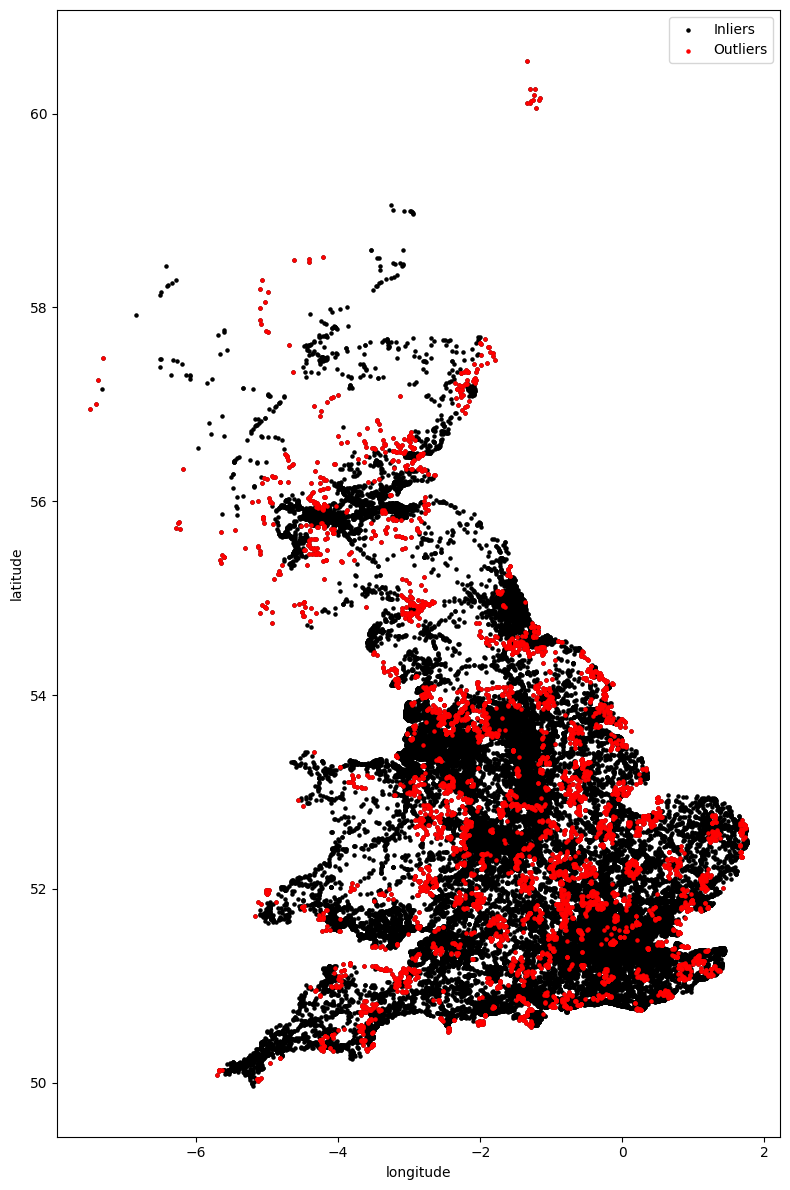

In [226]:
accident_location_outlier_lof_n40 = lof_and_plot(long_lat_features)

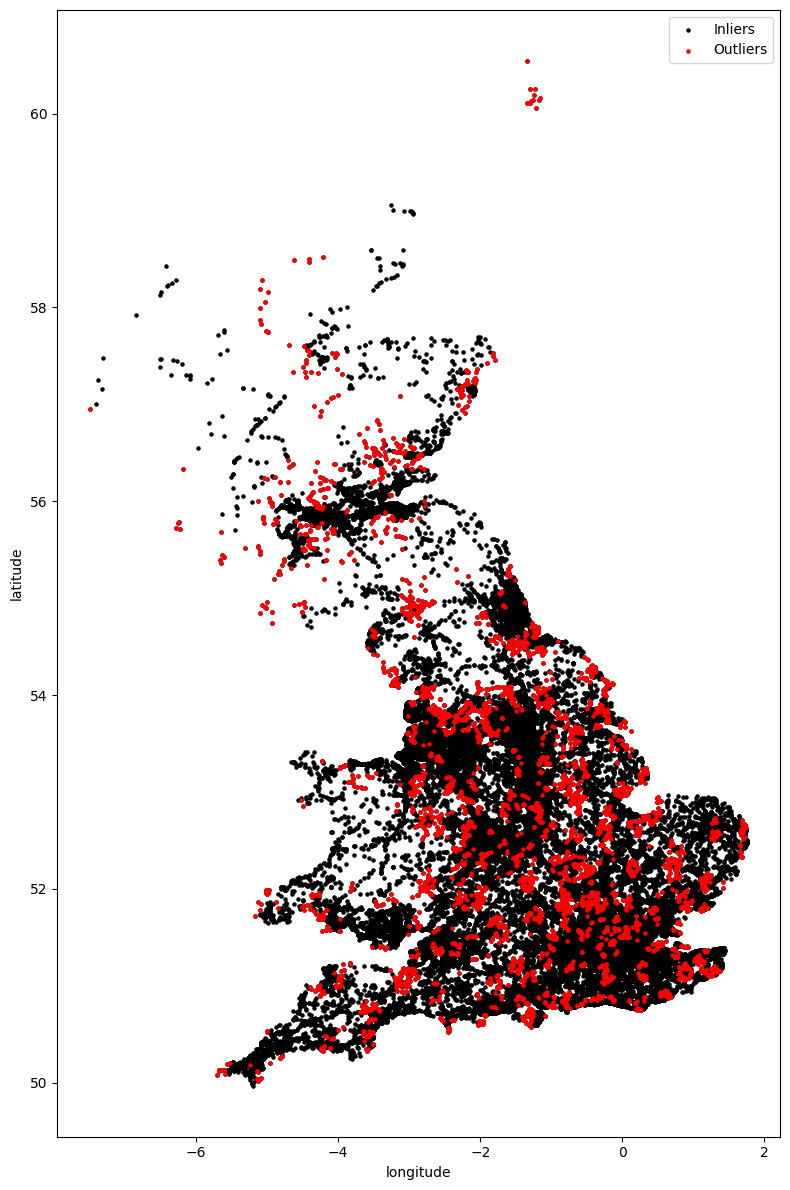

In [227]:
#Run with 30 n_neighbours
accident_location_outlier_lof_n30 = lof_and_plot(long_lat_features, n_neighbors=30)

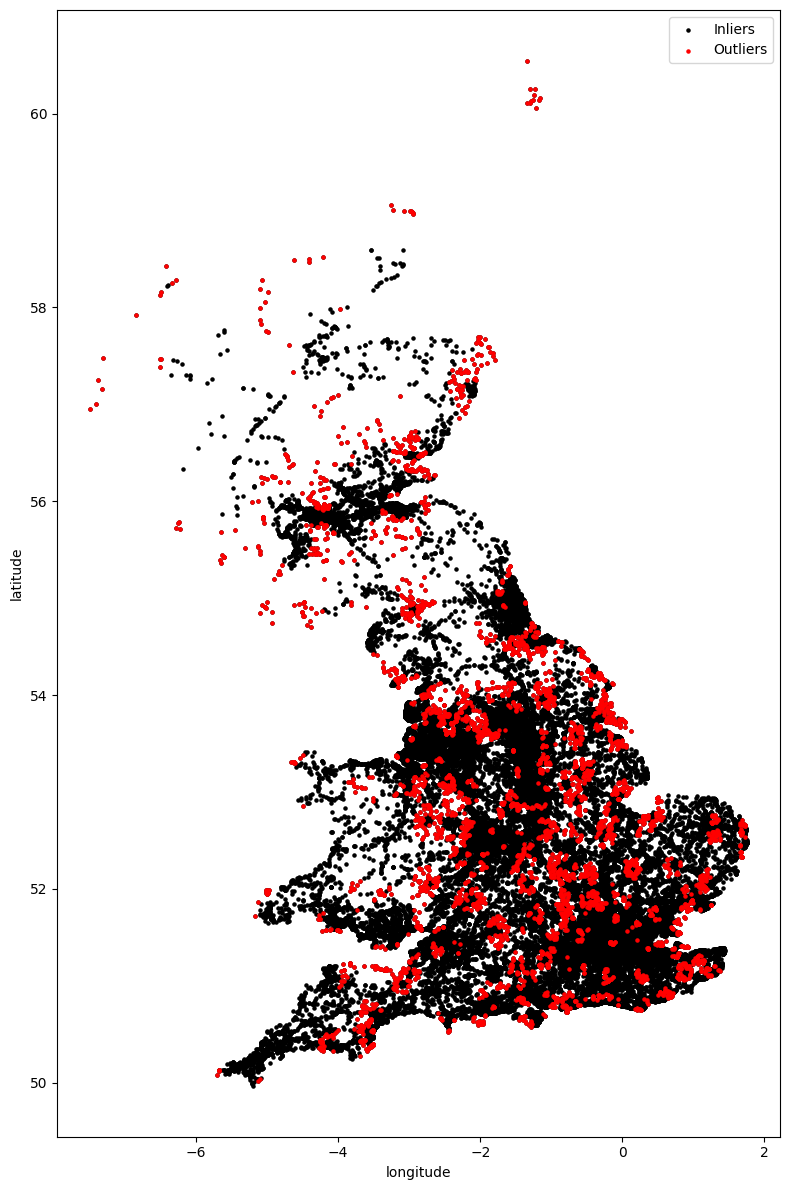

In [228]:
#Run with 50 n_neighbours
accident_location_outlier_lof_n50 = lof_and_plot(long_lat_features, n_neighbors=50)

Outliers were distributed across the data using LOF. 50 n_neighbours seem to do a good job.

*Isolation Forest*

Scikit learn (n. d.) sklearn.ensemble.IsolationForest. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html [Accessed 13/03/2024].

Isolation Forest is an ensemble method that isolates outliers by randomly selecting features and partitioning the data. It can effectively handle spatially clustered data by identifying anomalies as data points that are easily separated from the rest of the data.

In [229]:
#from sklearn.ensemble import IsolationForest
#Function to run isolation forest on accident_df location data
#max_samples determines the number of samples drawn to train each base estimator (individual decision trees) in the forest
def isolation_forest_and_plot(df, features, max_samples=10, contamination=0.05, random_state=None, bootstrap=True, n_estimators=100, figsize=(8,12)):
    """
    Runs Isolation Forest algorithm and plots the results.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    features (list): A list of two features to be used for analysis.
    max_samples (int, optional): The number of samples to draw from df to train each base estimator. Defaults to 10.
    contamination (float, optional): The expected proportion of outliers in the data. Defaults to 0.05.
    random_state (int or RandomState, optional): Controls the random seed for reproducibility. Defaults to None.
    bootstrap (bool, optional): If True, individual trees are fit on random subsets of the training data sampled with replacement. If False, sampling without replacement is used. Defaults to True.
    n_estimators (int, optional): The number of base estimators in the ensemble. Defaults to 100.
    figsize (tuple): A tuple specifying the size of the figure. Defaults to (8, 12).

    Returns:
    fig: The figure object of the plot.
    """
    
    # Initialize and fit the Isolation Forest model
    model = IsolationForest(max_samples=max_samples, contamination=contamination, random_state=random_state,
                            bootstrap=bootstrap, n_estimators=n_estimators)
    model.fit_predict(df)
    if_scores = model.decision_function(df)
    if_anomalies = model.predict(df)
    
    # Extract anomalies identified by Isolation Forest
    if_anomalies = df[if_anomalies == -1]
    
    # Plot the data points
    fig = plt.figure(figsize=figsize)
    plt.scatter(df[features[0]], df[features[1]], c='black', label='Inliers', s=5)
    plt.scatter(if_anomalies[features[0]], if_anomalies[features[1]], c='red', label='Outliers', s=5)
    
    plt.legend()
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.tight_layout()
    
    return fig

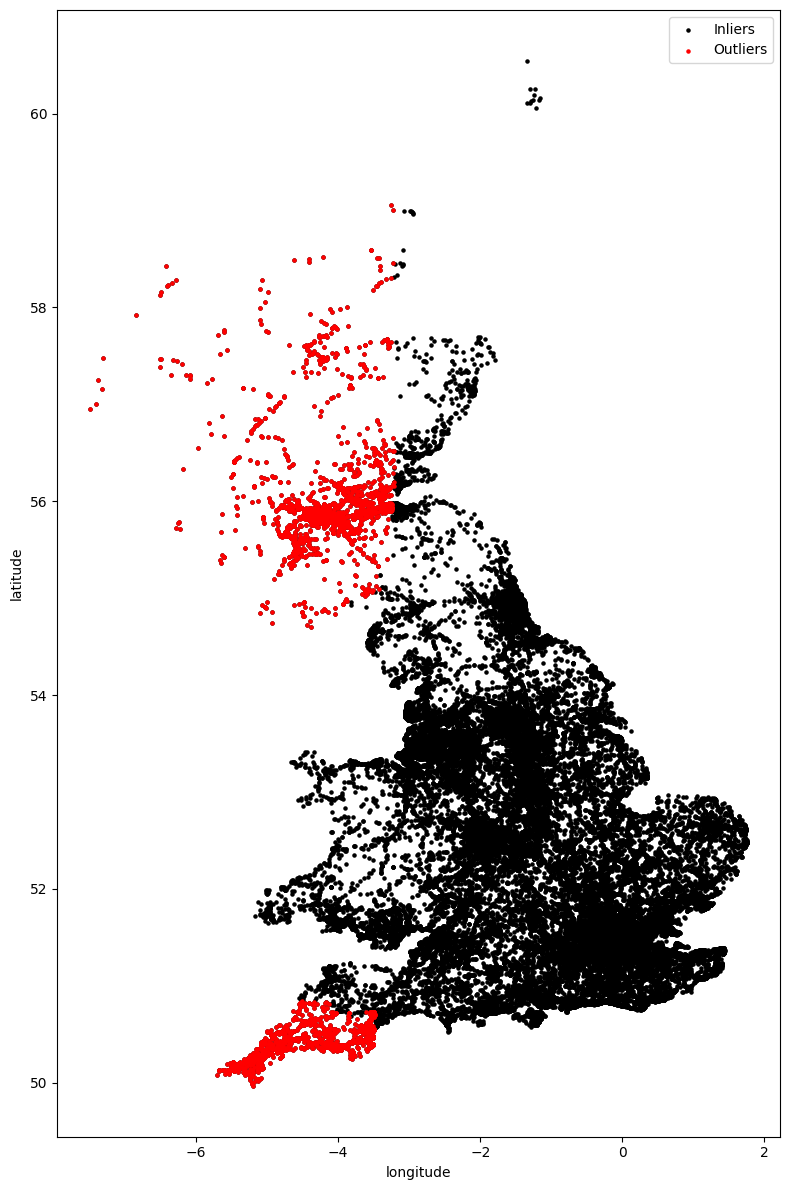

In [230]:
#Run on long_lat_features for accident_df
accident_location_outlier_if = isolation_forest_and_plot(long_lat_features, features = ['longitude', 'latitude'], random_state=42)

Isolation forest not doing a great job of clustering because it is not isolating around dense clusters in the centre of the plot.

*DBSCAN*

Scikit learn (n. d.) sklearn.cluster.DBSCAN. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html [Accessed 10/03/2024].

Not using grid search to optimise for eps and min_samples on entire coordinate dataset due to computational time.

eps of 0.03 and min_samples of 7 chosen as best parameters to visualise outliers for entire dataset long_lat_features.

In [231]:
def dbscan(df, features, eps=0.1, min_samples=5, figsize=(8, 12)):
    """
    Run DBSCAN clustering on two features (coordinates).

    Parameters:
    df (DataFrame): DataFrame containing two features.
    eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other. Defaults to 0.1.
    min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point. Defaults to 5.
    figsize (tuple): A tuple specifying the size of the figure. Defaults to (8, 12).
    
    Returns:
    fig: The figure object of the plot.
    """
    #Define X
    X = df.values

    #Initialize DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    #Fit the model and predict clusters
    clusters = dbscan.fit_predict(X)

    #Get indices of outliers (points labeled as -1)
    outlier_indices = np.where(clusters == -1)[0]

    #Plot the clusters and outliers
    fig = plt.figure(figsize=figsize)
    plt.scatter(X[:, 1], X[:, 0], c=clusters, cmap='viridis', s=5)
    plt.scatter(X[outlier_indices, 1], X[outlier_indices, 0], c='red', label='Outliers', s=3)
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    
    return fig

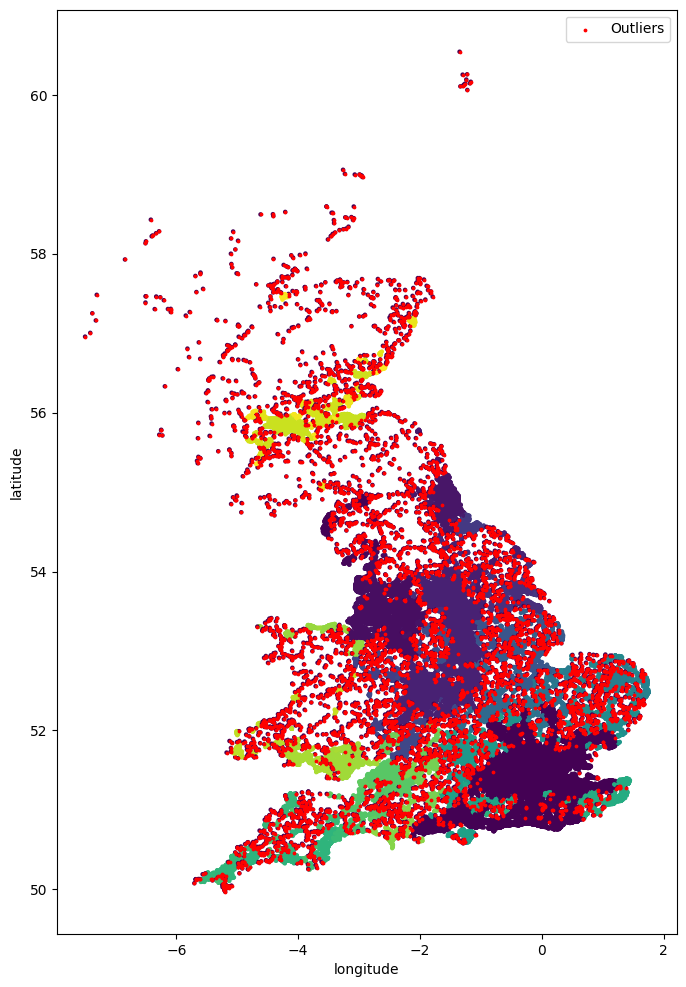

In [232]:
#Run dbscan function on long_lat_features
#eps is 0.03 and min_samples is 7
#Did not run grid search for hyperparameter optmising due to dataset size
accident_location_outlier_dbscan = dbscan(long_lat_features, features = ['longitude', 'latitude'], eps=0.03, min_samples=7)

DBSCAN identifies clusters in the location data (typically around built up urban areas like cities) and identifying outliers around them based on defined hyperparameters.

The outliers are highlighted around major cities and built-up urban areas which you might expect from previous data analysis where accidents in urban areas is 76%.

Can't exclude any data points based on this analysis.

*Multivariate detection methods on humberside*

Use IF, LOF and DBSCAN on humberside region.

humberside_long_lat_features

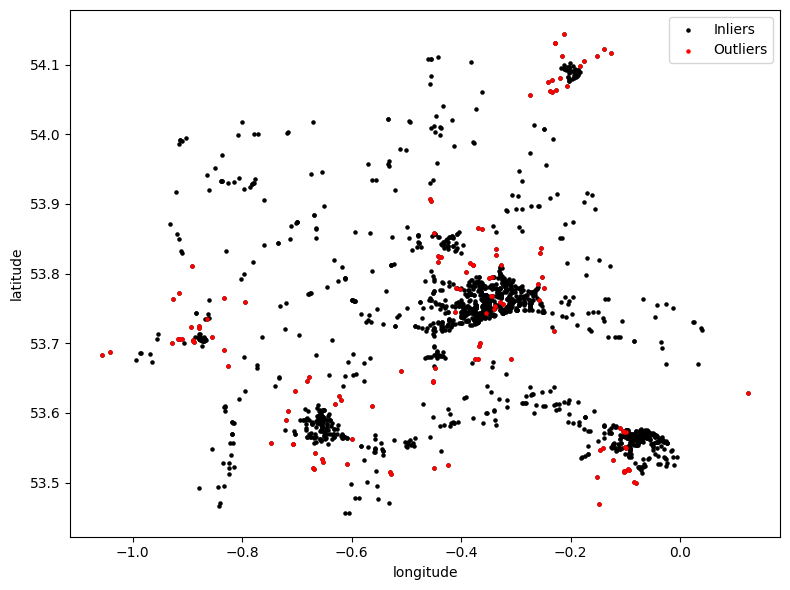

In [233]:
#Run LOF with 10 n_neighbours on humberside_long_lat_features
humberside_accident_location_outlier_lof_n10 = lof_and_plot(humberside_long_lat_features, n_neighbors=10, figsize=(8,6))

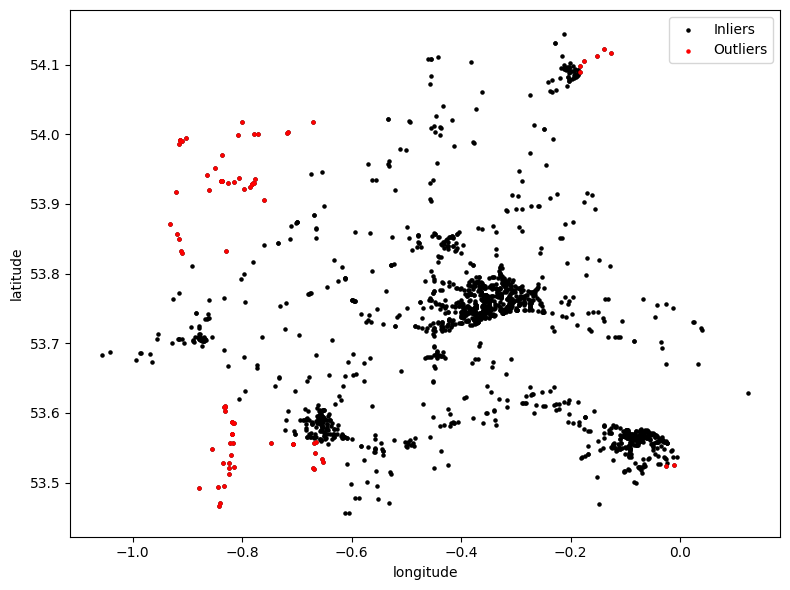

In [234]:
#Run IF on humberside_long_lat_features
humberside_accident_location_outlier_if = isolation_forest_and_plot(humberside_long_lat_features, features = ['longitude', 'latitude'], random_state=42, figsize=(8,6))

In [295]:
#DBSCAN function with hyperparameter (eps and min_sample) optmisation
#search through min_sample and eps range and pick optimal based on silhouette score
def dbscan_hyperparameter_opt(df, features, eps_range=(0.01, 0.05), min_samples_range=(3, 10), figsize=(8,12)):
    """
    Run DBSCAN clustering on two features (coordinates) and optimize hyperparameters using silhouette score.

    Parameters:
    df (DataFrame): DataFrame containing the data.
    features (list): A list of two features to be used for analysis.
    eps_range (tuple): Range of epsilon values for grid search. Defaults to (0.1, 0.5).
    min_samples_range (tuple): Range of min_samples values for grid search. Defaults to (5, 20).
    figsize (tuple): A tuple specifying the size of the figure. Defaults to (8, 12).
    
    Returns:
    fig: The figure object of the plot.
    outlier_indices: Indices of the outliers detected.
    """
    #Define X
    X = df.values

    best_score = -1
    best_params = None

    #Perform search over parameter ranges
    for eps in np.linspace(eps_range[0], eps_range[1], 10):
        for min_samples in range(min_samples_range[0], min_samples_range[1] + 1):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(X)
            if -1 in clusters:  #Only calculate silhouette score if outliers are detected
                score = silhouette_score(X, clusters)
                if score > best_score:
                    best_score = score
                    best_params = {'eps': eps, 'min_samples': min_samples}
    
    #Print the best parameters
    print("Best Parameters:")
    print(best_params)

    #Fit the model with the best parameters and predict clusters
    best_dbscan = DBSCAN(**best_params)
    clusters = best_dbscan.fit_predict(X)

    #Get indices of outliers (points labeled as -1)
    outlier_indices = np.where(clusters == -1)[0]

    #Plot the clusters and outliers
    fig = plt.figure(figsize=figsize)
    plt.scatter(X[:, 1], X[:, 0], c=clusters, cmap='viridis', s=5)
    plt.scatter(X[outlier_indices, 1], X[outlier_indices, 0], c='red', label='Outliers', s=3)
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    
    return fig, outlier_indices

Best Parameters:
{'eps': 0.03666666666666667, 'min_samples': 10}


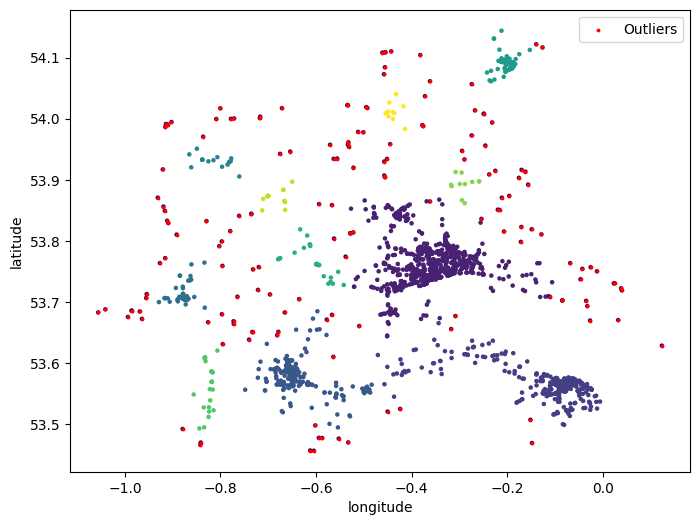

In [296]:
#Run DBSCAN function on humberside_long_lat_features
#eps and min_samples are optimised in function
humberside_accident_location_outlier_dbscan, outlier_indices = dbscan_hyperparameter_opt(humberside_long_lat_features, features = ['longitude', 'latitude'], figsize=(8,6))

In [237]:
#Display outliers from DBSCAN on folium map
def plot_outliers_on_folium_map(df, outlier_indices):
    """
    Plot outliers on a Folium map.

    Parameters:
    df (DataFrame): DataFrame containing latitude and longitude coordinates.
    outlier_indices (array-like): Indices of outliers in the DataFrame.

    Returns:
    base_map: Folium map object with outliers plotted.
    """
    #Create a base map centered around the mean of accident coordinates
    base_map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=9)

    #Add markers for each outlier
    for index in outlier_indices:
        lat = df.iloc[index]['latitude']
        lon = df.iloc[index]['longitude']
        folium.CircleMarker(location=[lat, lon], radius=5, color='red', fill=True, fill_color='red').add_to(base_map)

    return base_map

humberside_accident_map = plot_outliers_on_folium_map(humberside_long_lat_features, outlier_indices)
humberside_accident_map

In [238]:
humberside_accident_map.save("humberside_accident_map.png")

Localised outlier detection using LOF, IF and DBSCAN to the humberside region shows that outliers are not extreme values, likely not data entry errors or coordinate inaccuracies. Instead, they might represent unique or uncommon situations that occurred within Humberside but outside built up urban areas, so not excluding these data points.

**7. Classification model to predict fatal injuries**

Can you develop a classification model using the provided data that accurately predicts fatal injuries sustained in road traffic accidents, with the aim of informing and improving road safety measures?

Predict whether an accident is fatal given the conditions it happened under.

Analysis undertaken in this section:

1. Scaling
2. Class balance (under-/over-sampling (SMOTE and ADASYN)
3. Feature selection using Random Forest selecting top features (10 vs 15) from unbalanced and balanced dataset
2. Classification model hyperparameter tuning and evaluation (RF, DT, GB and SVM) 
5. Effects of cross-validation (grid search for hyperparameters and independent cross-validation of training data)
6. Stacking

*Data preparation*

In [239]:
# Define the columns to keep in the updated DataFrame
columns_to_keep = ['accident_severity', 'age_of_casualty', 'speed_limit', 'number_of_casualties', 'engine_capacity_cc', 'age_of_driver',
                  'number_of_vehicles', 'age_of_vehicle', 'urban_or_rural_area', 'casualty_type', 'light_conditions',
                  'road_type', 'vehicle_type', 'weather_conditions', 'sex_of_casualty', 'sex_of_driver', 
                  'pedestrian_crossing_physical_facilities', 'road_surface_conditions', 'casualty_class', 'pedestrian_movement',
                  'pedestrian_location', 'junction_control', 'pedestrian_crossing_human_control'] 
#Filter merged_df to include only the specified columns
merged_df_updated = merged_df[columns_to_keep].copy()
merged_df_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220435 entries, 0 to 220434
Data columns (total 23 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   accident_severity                        220435 non-null  int64  
 1   age_of_casualty                          220435 non-null  float64
 2   speed_limit                              220435 non-null  float64
 3   number_of_casualties                     220435 non-null  int64  
 4   engine_capacity_cc                       220435 non-null  float64
 5   age_of_driver                            220435 non-null  float64
 6   number_of_vehicles                       220435 non-null  int64  
 7   age_of_vehicle                           220435 non-null  float64
 8   urban_or_rural_area                      220435 non-null  int64  
 9   casualty_type                            220435 non-null  int64  
 10  light_conditions                

In [240]:
#Convert all columns to int64 type
merged_df_updated = merged_df_updated.astype('int64')
merged_df_updated.head()

accident_severity  age_of_casualty  speed_limit  number_of_casualties  \
0                  3               31           20                     1   
1                  3                2           20                     2   
2                  3                4           20                     2   
3                  3               23           30                     1   
4                  2               47           30                     1   

   engine_capacity_cc  age_of_driver  number_of_vehicles  age_of_vehicle  \
0                1968             32                   1               6   
1                1395             45                   1               2   
2                1395             45                   1               2   
3                1596             38                   1               7   
4                1798             44                   1               8   

   urban_or_rural_area  casualty_type  ...  weather_conditions  \
0                    1              0  ...                   9   
1                    1              0  ...                   1   
2                    1              0  ...                   1   
3                    1              0  ...                   1   
4                    1              0  ...                   1   

   sex_of_casualty  sex_of_driver  pedestrian_crossing_physical_facilities  \
0                1              2                                        9   
1                2              1                                        4   
2                2              1                                        4   
3                1              3                                        0   
4                1              1                                        4   

   road_surface_conditions  casualty_class  pedestrian_movement  \
0                        9               3                    5   
1                        1               3                    1   
2                        1               3                    1   
3                        2               3                    9   
4                        1               3                    1   

   pedestrian_location  junction_control  pedestrian_crossing_human_control  
0                    9                 4                                  9  
1                    1                 2                                  0  
2                    1                 2                                  0  
3                    5                 1                                  0  
4                    4                 4                                  0  

[5 rows x 23 columns]

*Scaling numerical features*

Need to scale numerical features prior to feature selection and classification. Not needed for Random Forest, but want to perform SVM classifier later on so numerical features need scaling. SVMs utilize distances between data points to find the optimal decision boundary.

Scikit learn (n. d.) sklearn.preprocessing.StandardScaler. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html [Accessed 13/03/2024].

In [241]:
#from sklearn.preprocessing import StandardScaler
#Put the numerical features to be scaled into list
numerical_features = ['age_of_vehicle', 'age_of_driver', 'age_of_casualty', 'engine_capacity_cc']

#Instantiate StandardScaler
scaler = StandardScaler()

#Fit and transform the selected numerical features
merged_df_updated[numerical_features] = scaler.fit_transform(merged_df_updated[numerical_features])

In [242]:
#Separate features and target variable
X = merged_df_updated.drop(columns=['accident_severity'])  #Features minus accident_severity
y = merged_df_updated['accident_severity'] == 1  #Target variable (True for fatal, False for non-fatal)

*Class balance*

In [243]:
#Count the occurrences of each class in the target variable
class_counts = y.value_counts()

#Calculate the proportion of each class
class_proportions = class_counts / len(y)

print("Class Counts:")
print(class_counts)
print("\nClass Proportions:")
print(class_proportions)

Class Counts:
accident_severity
False    216204
True       4231
Name: count, dtype: int64

Class Proportions:
accident_severity
False    0.980806
True     0.019194
Name: count, dtype: float64


The dataset is highly imbalanced. The majority class (non-fatal accidents) accounts for approximately 98.1% of the dataset, while the minority class (fatal accidents) accounts for only about 1.9%.

This imbalance will effect both feature selection and model training, so will determine effect of unbalanced and balanced data on feature seletion and for running any classifiers.

Techniques I can try are:

Oversampling: Increase the number of instances in the minority class by randomly replicating them, or using SMOTE or ADASYN.

Downsampling: Decrease the number of instances in the majority class by randomly removing instances.

The problem with down-sampling is that I will be significantly decreasing the dataset size which will reduce the amount available for training which could decrease performance.

Going to try down-sampling and over-sampling using SMOTE or ADASYN.

*Downsampling*

In [244]:
#Function to downsample X and y based on target_coloum, accident_severity
def downsample_majority_class(X, y, target_column):
    """
    Downsample the majority class in a binary classification dataset to match the number of instances
    in the minority class.

    Parameters:
    X (Dataframe): The feature matrix of shape (n_samples, n_features).
    y (pd.Series): The target variable with binary labels.
    target_column (str): The name of the target column in y.

    Returns:
    X_downsampled (Dataframe): The downsampled feature matrix.
    y_downsampled (pd.Series): The downsampled target variable.
    """
    #Concatenate X with y to form a df
    df = pd.concat([X, y], axis=1)

    #Separate majority and minority classes
    majority_class = df[df[target_column] == False]  # False represents the majority class (non-fatal)
    minority_class = df[df[target_column] == True]   # True represents the minority class (fatal)

    #Randomly sample instances from the majority class to match the number of instances in the minority class
    majority_class_downsampled = majority_class.sample(len(minority_class), random_state=42)

    #Concatenate the downsampled majority class features with the original minority class features
    df_downsampled = pd.concat([majority_class_downsampled, minority_class])

    #Shuffle df to randomize the order of instances
    df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

    #Separate features and target variable from the downsampled df
    X_downsampled = df_downsampled.drop(columns=[target_column])
    y_downsampled = df_downsampled[target_column]

    return X_downsampled, y_downsampled
     
X_downsampled, y_downsampled = downsample_majority_class(X, y, 'accident_severity')

print("Shape of X_downsampled:", X_downsampled.shape)
print("Shape of y_downsampled:", y_downsampled.shape)

Shape of X_downsampled: (8462, 22)
Shape of y_downsampled: (8462,)


*Over-sampling*

*SMOTE*

Imbalanced learn (n. d.) SMOTE. Available online: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html [Accessed 13/03/2024].

SMOTE (Synthetic Minority Over-sampling Technique) addresses class imbalance in datasets, particularly in classification tasks where one class is significantly under-represented compared to another. 

SMOTE first identifies instances belonging to the minority class (fatal accidents). SMOTE then generates synthetic samples by selecting one or more of its nearest neighbors in the feature space and creating new instances along the line segments joining the instance to its neighbors. The number of synthetic samples created for each minority class instance is determined by the specified oversampling ratio. This effectively balances the class distribution, making the number of instances in the minority class equal to that of the majority class.

In [245]:
#from imblearn.over_sampling import SMOTE
#Instantiate SMOTE
smote = SMOTE(random_state=42)

#Resample the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

#Check the class distribution after resampling
print("Class Counts after SMOTE:")
print(pd.Series(y_resampled).value_counts())

Class Counts after SMOTE:
accident_severity
False    216204
True     216204
Name: count, dtype: int64


*ADASYN*

Imbalanced learn (n. d.) ADASYN. Available online: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN [Accessed 13/03/2024].

An alternative to SMOTE for addressing class imbalance is the Adaptive Synthetic Sampling (ADASYN) technique. ADASYN builds upon the idea of SMOTE but focuses on adaptively generating synthetic samples for the minority class based on the local density of minority instances. ADASYN first estimates the local density of minority class instances. It identifies regions where the class imbalance is more severe by considering the ratio of minority to majority class instances within a neighborhood around each minority instance.  It then generates synthetic samples for minority class instances in regions with higher class imbalance i.e. those located in regions where the density of the majority class is higher, adaptively generating synthetic samples based on local class distribution.

In [246]:
#from imblearn.over_sampling import ADASYN
#Instantiate ADASYN
adasyn = ADASYN(random_state=42)

#Resample the dataset
X_resampled_ada, y_resampled_ada = adasyn.fit_resample(X, y)

#Check the class distribution after resampling
print("Class Counts after ADASYN:")
print(pd.Series(y_resampled_ada).value_counts())

#Check the shape of the x_resampled_ada
print("Shape of X_resampled_ada:", X_resampled_ada.shape)

Class Counts after ADASYN:
accident_severity
False    216204
True     216097
Name: count, dtype: int64
Shape of X_resampled_ada: (432301, 22)


Going to use unbalanced, downsampled and ADASYN oversampled data for feature selection.

*Feature importance and selection*

Using Random Forest classifier.

Scikit learn (n. d.) Feature selection. Available online: https://scikit-learn.org/stable/modules/feature_selection.html [Accessed 11/03/2024].

Scikit learn (n. d.) sklearn.ensemble.RandomForestClassifier. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html [Accessed 13/03/2024].

Scikit learn (n. d.) sklearn.model_selection.GridSearchCV. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html [Accessed 10/03/2024].

Scikit learn (n. d.) sklearn.model_selection.train_test_split. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html [Accessed 10/03/2024].

Scikit learn (n. d.) sklearn.feature_selection.SelectFromModel. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html [Accessed 10/03/2024].

In [247]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import  RandomForestClassifier
#from sklearn.feature_selection import SelectFromModel
#Split data into training and testing sets
#using stratify=y, to maintain the same class distribution in both the training and testing sets
#Define function to dtermine feature importance using RF
def rf_feature_importance(X, y, test_size=0.2, random_state=42, param_grid=None, cv=5):
    """
    Perform Random Forest classification with feature importance analysis.

    Parameters:
    X (DataFrame): Input features.
    y (Series): Target labels.
    test_size (float): Proportion of the dataset to include in the test split (default=0.2).
    random_state (int): Controls the randomness of the dataset splitting and classifier initialization (default=42).
    param_grid (dict): Grid of hyperparameters to search over (default=None).
    cv (int): Number of cross-validation folds.

    Returns:
    rf_classifier (RandomForestClassifier): Trained Random Forest classifier.
    sorted_features (array): Names of features sorted by their importance.
    fig (Figure): Matplotlib figure object displaying feature importance.
    """
    #Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    #Set default parameter grid if not provided
    if param_grid is None:
        param_grid = {
            'n_estimators': [300],
            'criterion': ['gini'],
            'max_depth': [15],
            'min_samples_split': [2]
        }
    
    #Initialize Random Forest classifier
    rf_classifier = RandomForestClassifier(random_state=random_state)
    
    #Perform Grid Search for hyperparameter optimization
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=cv)
    grid_search.fit(X_train, y_train)
    
    #Get the best estimator from grid search
    rf_classifier = grid_search.best_estimator_
    
    #Print best parameters
    print("Best parameters found during grid search:")
    print(grid_search.best_params_)
    
    #Fit the Random Forest classifier to the training data
    rf_classifier.fit(X_train, y_train)
    
    #Perform feature selection
    feature_selector = SelectFromModel(rf_classifier)
    feature_selector.fit(X_train, y_train)
    
    #Get selected feature indices and names
    selected_feature_indices = feature_selector.get_support(indices=True)
    selected_features = X_train.columns[selected_feature_indices]
    
    #Visualize feature importance
    feature_importances = rf_classifier.feature_importances_
    sorted_indices = feature_importances.argsort()[::-1]
    sorted_features = X.columns[sorted_indices]
    sorted_importances = feature_importances[sorted_indices]
    
    fig = plt.figure(figsize=(10, 10))
    plt.barh(range(len(sorted_importances)), sorted_importances[::-1], tick_label=sorted_features[::-1], color=sns.color_palette('viridis')[4])
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    
    return rf_classifier, sorted_features, fig

In [248]:
#Define parameter grid for RF
rf_param_grid = {'n_estimators': [100, 200, 300], 
              'criterion': ['gini', 'entropy'], 
              'max_depth': [None, 10, 15, 20], 
              'min_samples_split': [2, 5, 10]
             }

Best parameters found during grid search:
{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 300}


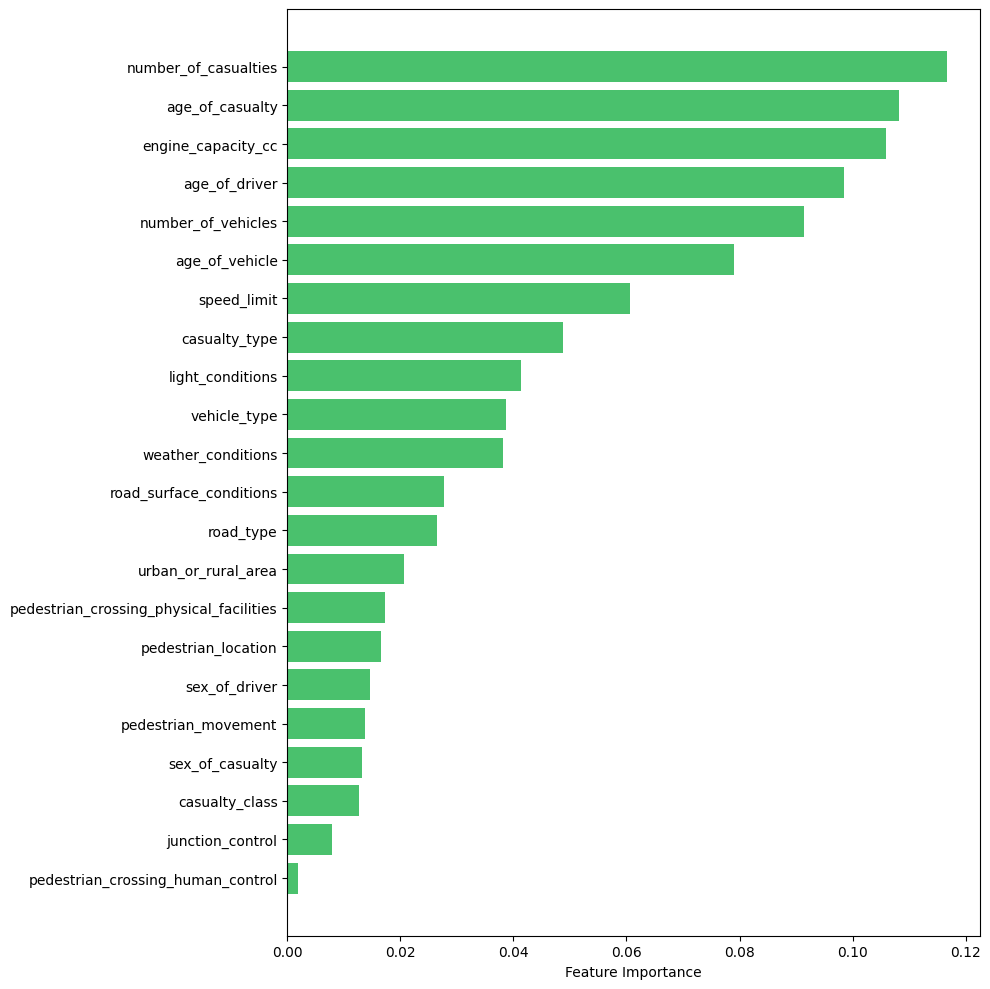

In [249]:
#Run function on X and y without down/over-sampling without optimising hyperparameters due to computational time
feature_importance, sorted_features, unbalanced_fig = rf_feature_importance(X, y)

In [250]:
#Select top 10 and 15 features directly from sorted_features for unbalanced data
top_10_features_unbalanced = sorted_features[:10]
top_15_features_unbalanced = sorted_features[:15]

Best parameters found during grid search:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


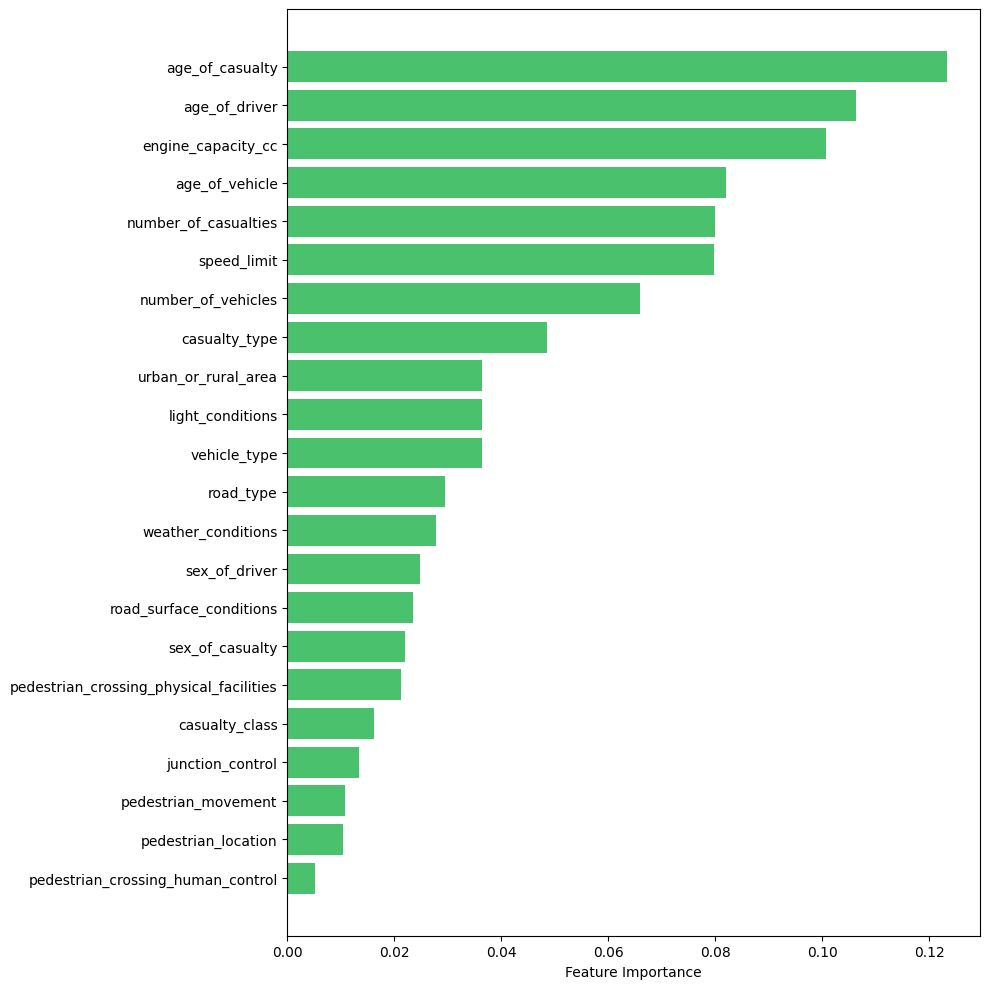

In [251]:
#Run function on downsampled data
downsampled_feature_importance, sorted_features_2, downsampled_fig = rf_feature_importance(X_downsampled, y_downsampled, param_grid=rf_param_grid)

In [252]:
#Select top 10 and 15 features directly from sorted_features_2 for downsampled data
top_10_features_downsampled = sorted_features_2[:10]
top_15_features_downsampled = sorted_features_2[:15]

Best parameters found during grid search:
{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 300}


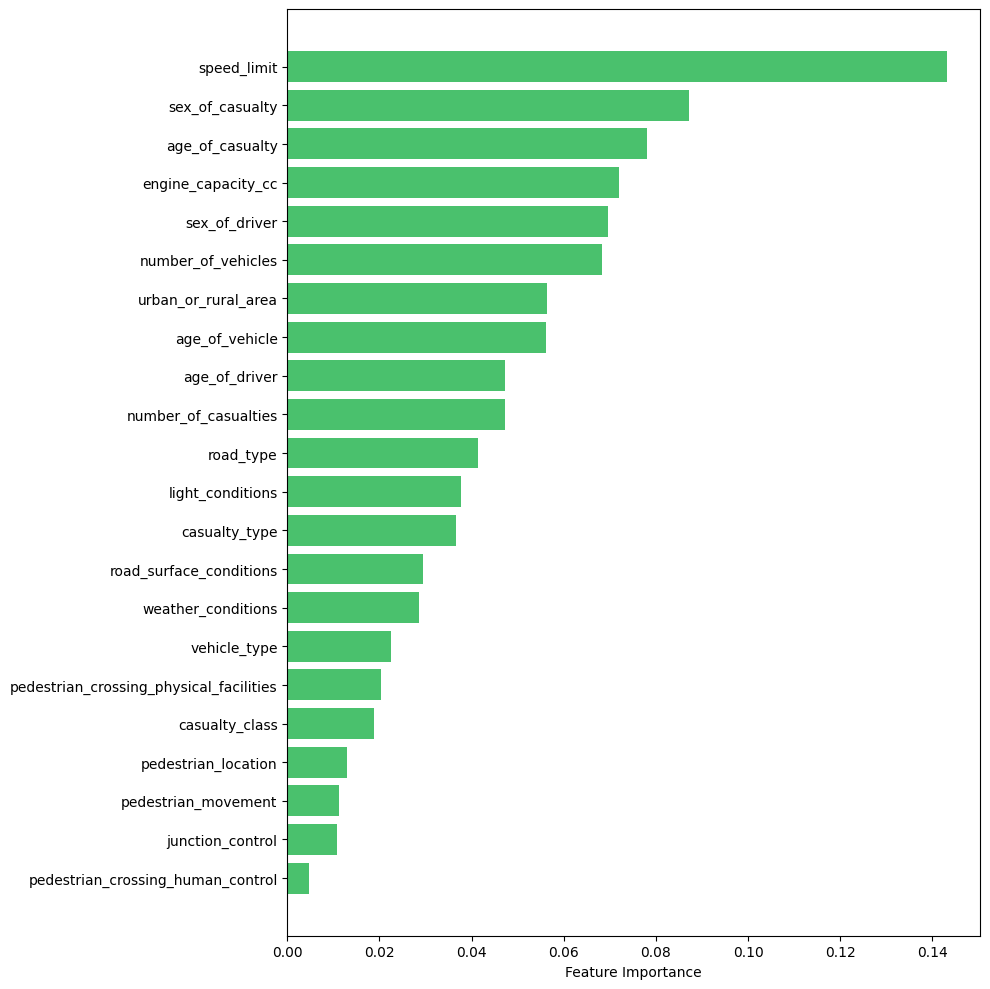

In [253]:
#Run on oversampled data but not doing parameter grid search due to computational time
oversampled_feature_importance, sorted_features_3, oversampled_fig = rf_feature_importance(X_resampled_ada, y_resampled_ada)

In [254]:
#Select top 10 and 15 features directly from sorted_features_3 for oversampled data
top_10_features_oversampled = sorted_features_3[:10]
top_15_features_oversampled = sorted_features_3[:15]

In [255]:
#Subset X with top 10 and 15 features
X_unbalanced_10 = X[top_10_features_unbalanced]
X_unbalanced_15 = X[top_15_features_unbalanced]

#Check the shape of the X feature matrix for 10 and 15 features
print("Shape of X_unbalanced_10:", X_unbalanced_10.shape)
print("Shape of X_unbalanced_15:", X_unbalanced_15.shape)

Shape of X_unbalanced_10: (220435, 10)
Shape of X_unbalanced_15: (220435, 15)


In [256]:
#Subset X_downsampled with top 10 and 15 features
X_downsampled_10 = X_downsampled[top_10_features_downsampled]
X_downsampled_15 = X_downsampled[top_15_features_downsampled]

#Check the shape of the X_downsampled feature matrix for 10 and 15 features
print("Shape of X_downsampled_10:", X_downsampled_10.shape)
print("Shape of X_downsampled_15:", X_downsampled_15.shape)

Shape of X_downsampled_10: (8462, 10)
Shape of X_downsampled_15: (8462, 15)


In [257]:
#Subset X_oversampled with top 10 and 15 features
X_oversampled_10 = X_resampled_ada[top_10_features_oversampled]
X_oversampled_15 = X_resampled_ada[top_15_features_oversampled]

#Check the shape of the X_oversampled feature matrix for 10 and 15 features
print("Shape of X_oversampled_10:", X_oversampled_10.shape)
print("Shape of X_oversampled_15:", X_oversampled_15.shape)

Shape of X_oversampled_10: (432301, 10)
Shape of X_oversampled_15: (432301, 15)


*Classification*

Models I will try:

Random forest (ensemble)

Decision Tree

SVM

Gradient Boost (ensemble)

Optimise hyperparameters for each model.

Try stacking to improve classification performance.

RFs already use bagging (bootstrapping), combining deep trees to achieve lower variance.

Will run first model, RF, with unbalanced and 10 and 15 downsampled and 10 ovesamples features to determine performance. Dimensionality may be too large with 15 features, leading to overfitting and computational complexity. There is also the potential for feature redundancy with higher number of features too.

*Random forest with hyperparameter tuning*

Scikit learn (n. d.) sklearn.ensemble.RandomForestClassifier. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html [Accessed 13/03/2024].

First going to run RF on unbalanced class data X_unbalanced_10 and y, calculating balanced accuracy score to determine the performance of the model without using the balanced datasets.

This will then be compared to the balanced datasets to determing the effect of balancing classes on model performance.

Scikit learn (n. d.-j) sklearn.model_selection.RandomizedSearchCV. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html [Accessed 10/03/2024].

Using random search for “fit” and a “score” method to reduce computation required for gridsearch on the unbalanced dataset (due to its size).

In [258]:
#Function to run random forest with hyperparameter tuning using random search on unbalanced dataset with Fatal as rare class
#with option to perform hyperparameter cross-validation
#calculating balanced accuracy score
#from sklearn.metrics import balanced_accuracy_score
#from sklearn.model_selection import RandomizedSearchCV
def rf_classifier_randomsearch(X, y, test_size=0.2, random_state=42, param_distributions=None, cv=None):
    """
    Train a Random Forest classifier, make predictions, and evaluate the model using classification report, confusion matrix, and ROC curve.

    Parameters:
    X (DataFrame or array-like): The feature data.
    y (array-like): The corresponding labels.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): Controls the randomness of the training and testing splits.
    param_distributions (dict): The distributions of hyperparameters to search over.
    cv (int): Number of cross-validation folds.

    Returns:
    rf_classifier (RandomForestClassifier): The trained Random Forest classifier.
    fig_cm (Figure): Matplotlib figure object containing confusion matrix.
    fig_roc (Figure): Matplotlib figure object containing ROC curve.
    """

    #Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    #Initialize Random Forest classifier
    rf_classifier = RandomForestClassifier(random_state=random_state)
    
    #Set default parameter distributions if not provided
    if param_distributions is None:
        param_distributions = {
            'n_estimators': [100, 200, 300, 400],
            'criterion': ['gini'],
            'max_depth': [None, 10, 15, 20, 30],
            'min_samples_split': [2, 5, 10, 20]
        }

    #Perform Randomized Search for hyperparameter optimization with/without cross-validation
    randomized_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_distributions, cv=cv)
    randomized_search.fit(X_train, y_train)
    
    #Get the best estimator from random search
    rf_classifier = randomized_search.best_estimator_
    
    #Print best parameters
    print("Best parameters found during random search:")
    print(randomized_search.best_params_)

    #Fit the Random Forest classifier to the training data
    rf_classifier.fit(X_train, y_train)

    #Make predictions
    y_pred = rf_classifier.predict(X_test)

    #Calculate probabilities for ROC curve
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    
    #Compute balanced accuracy score
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print("Balanced Accuracy Score:", balanced_acc)
    
    #Replace class labels with meaningful names
    y_test_labels = ['Fatal' if label else 'Non-Fatal' for label in y_test]
    y_pred_labels = ['Fatal' if label else 'Non-Fatal' for label in y_pred]

    #Evaluate the model
    print("Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels))

    #Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    #Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    #Plot confusion matrix
    fig_cm = plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    
    #Replace tick labels
    tick_labels = ['Non-Fatal', 'Fatal']
    plt.xticks(ticks=[0.5, 1.5], labels=tick_labels)
    plt.yticks(ticks=[0.5, 1.5], labels=tick_labels)

    #Plot ROC curve
    fig_roc = plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color=sns.color_palette('viridis')[1], lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color=sns.color_palette('viridis')[4], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    return rf_classifier, fig_cm, fig_roc

In [259]:
#Define param_distributions for randomized search
param_distributions = {
            'n_estimators': [100, 200, 300],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 15, 20],
            'min_samples_split': [2, 5, 10]
        }

Best parameters found during random search:
{'n_estimators': 100, 'min_samples_split': 5, 'max_depth': None, 'criterion': 'gini'}
Balanced Accuracy Score: 0.6116443121603955
Classification Report:
              precision    recall  f1-score   support

       Fatal       0.97      0.22      0.36       846
   Non-Fatal       0.99      1.00      0.99     43241

    accuracy                           0.98     44087
   macro avg       0.98      0.61      0.68     44087
weighted avg       0.98      0.98      0.98     44087



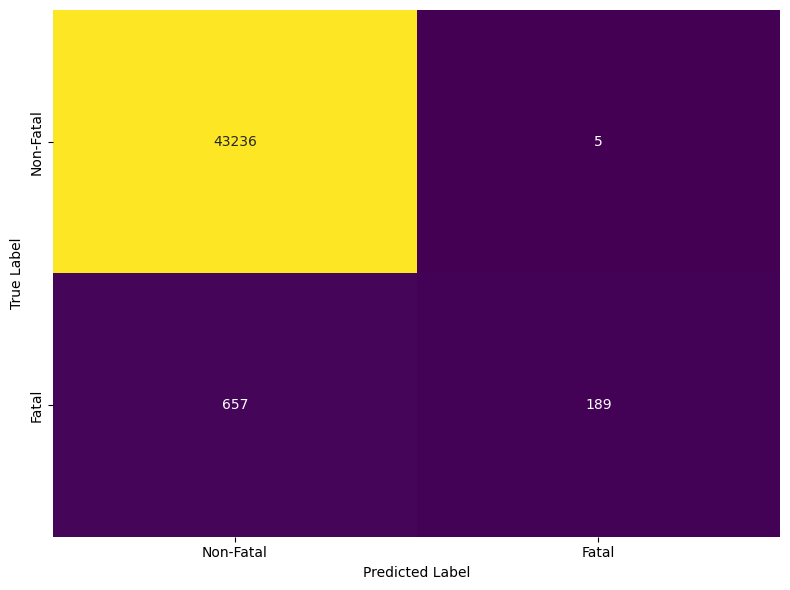

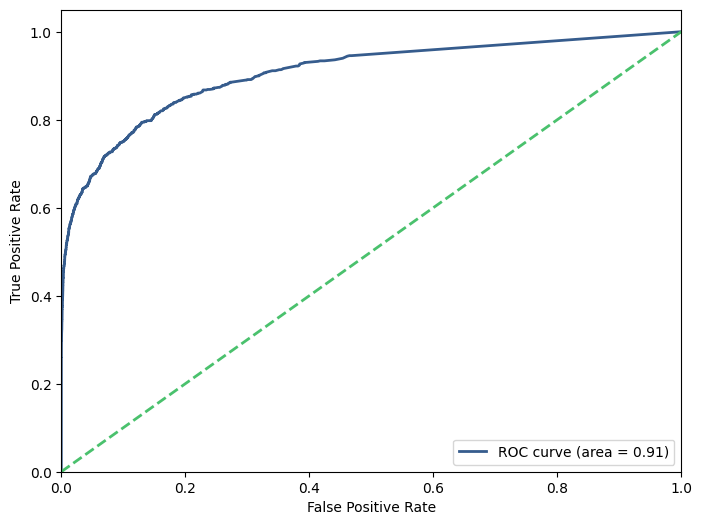

In [260]:
#Call the rf_classifier_unbalanced_dataset function on X (unbalanced data)
#Running without hyperparameter cross-validation in randomized search
trained_rf_classifier_unbalanced, fig_rf_cm_unbalanced, fig_rf_roc_unbalanced = rf_classifier_randomsearch(X_unbalanced_10, y, param_distributions=param_distributions)

RF run on the original unbalanced dataset does a pretty poor job of classifying fatal accidents as indicated by the confusion matrix. The weighted accuracy score accounts for the massive class imbalance, where fatal accidents are quite rare. Weighted accuracy is 61% which can probably be improved upon by running RF again with a balanced dataset which I will try next on the down-sampled 10 and 15 and oversampled 10 feature data to compare performance.

Precision of 0.96 indicates that when the classifier predicts a positive case (Fatal), it is correct 96% of the time, but a recall of 0.22 means that the classifier only captures 22% of the actual positive cases, with f1 score reflecting this trade-off between precision and recall with a score of 0.35.

AUC ROC is a metric used to evaluate the performance of a binary classification model. It provides a single scalar value that represents the overall performance of the model across all possible classification thresholds and can be used to compare the performance of different models. The model with a higher AUC ROC value is generally considered to be better at discriminating between the classes. A random classifier would have an AUC ROC value of around 0.5, indicating no discriminative power. A perfect classifier would have an AUC ROC value of 1.0, indicating perfect discrimination between the classes.

A value of 0.91 indicates the model exhibits very good discriminative power.

In [261]:
#Function to run random forest with hyperparameter tuning using grid search on balanced data sets
#Removed balanced accuracy score metric
#with option to perform hyperparameter cross-validation
def rf_classifier(X, y, test_size=0.2, random_state=42, param_grid=None, cv=None):
    """
    Train a Random Forest classifier, make predictions, and evaluate the model using classification report, confusion matrix, and ROC curve.

    Parameters:
    X (DataFrame or array-like): The feature data.
    y (array-like): The corresponding labels.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): Controls the randomness of the training and testing splits.
    param_grid (dict): The grid of hyperparameters to search over.
    cv (int): Number of cross-validation folds.

    Returns:
    rf_classifier (RandomForestClassifier): The trained Random Forest classifier.
    fig_cm (Figure): Matplotlib figure object containing confusion matrix.
    fig_roc (Figure): Matplotlib figure object containing ROC curve.
    """

    #Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    #Initialize Random Forest classifier
    rf_classifier = RandomForestClassifier(random_state=random_state)
    
    #Set default parameter grid if not provided
    if param_grid is None:
        param_grid = {
            'n_estimators': [300],
            'criterion': ['gini'],
            'max_depth': [15],
            'min_samples_split': [2]
        }

    #Perform Grid Search for hyperparameter optimization with/without cross-validation
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=cv)
    grid_search.fit(X_train, y_train)
    
    #Get the best estimator from grid search
    rf_classifier = grid_search.best_estimator_
    
    #Print best parameters
    print("Best parameters found during grid search:")
    print(grid_search.best_params_)

    #Fit the Random Forest classifier to the training data
    rf_classifier.fit(X_train, y_train)

    #Make predictions
    y_pred = rf_classifier.predict(X_test)

    #Calculate probabilities for ROC curve
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    
    #Replace class labels with meaningful names
    y_test_labels = ['Fatal' if label else 'Non-Fatal' for label in y_test]
    y_pred_labels = ['Fatal' if label else 'Non-Fatal' for label in y_pred]

    #Evaluate the model
    print("Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels))

    #Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    #Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    #Plot confusion matrix
    fig_cm = plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    
    #Replace tick labels
    tick_labels = ['Non-Fatal', 'Fatal']
    plt.xticks(ticks=[0.5, 1.5], labels=tick_labels)
    plt.yticks(ticks=[0.5, 1.5], labels=tick_labels)

    #Plot ROC curve
    fig_roc = plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color=sns.color_palette('viridis')[1], lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color=sns.color_palette('viridis')[4], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    return rf_classifier, fig_cm, fig_roc

*Run for downsampled data with 10 and 15 features*

Running first for 10 features downsampled data, with and without cross-validation in hyperparameter search.

Best parameters found during grid search:
{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

       Fatal       0.82      0.85      0.83       846
   Non-Fatal       0.85      0.81      0.83       847

    accuracy                           0.83      1693
   macro avg       0.83      0.83      0.83      1693
weighted avg       0.83      0.83      0.83      1693



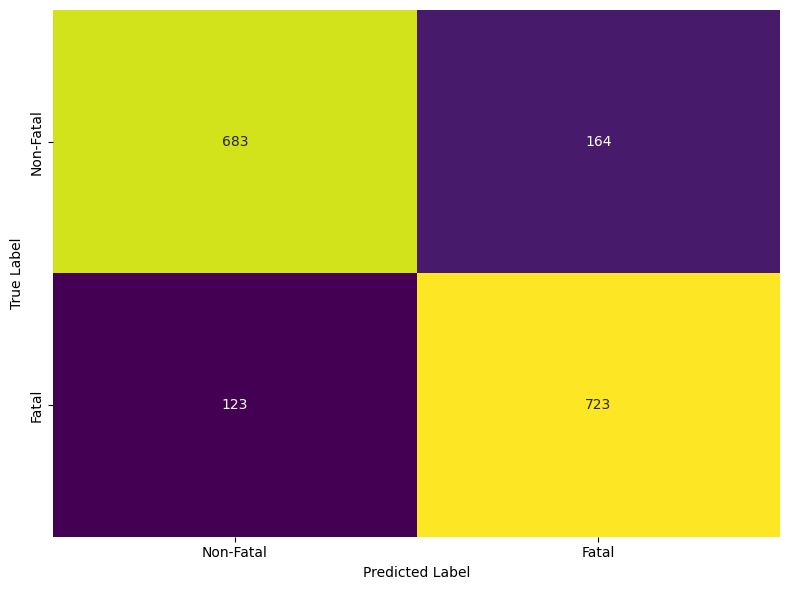

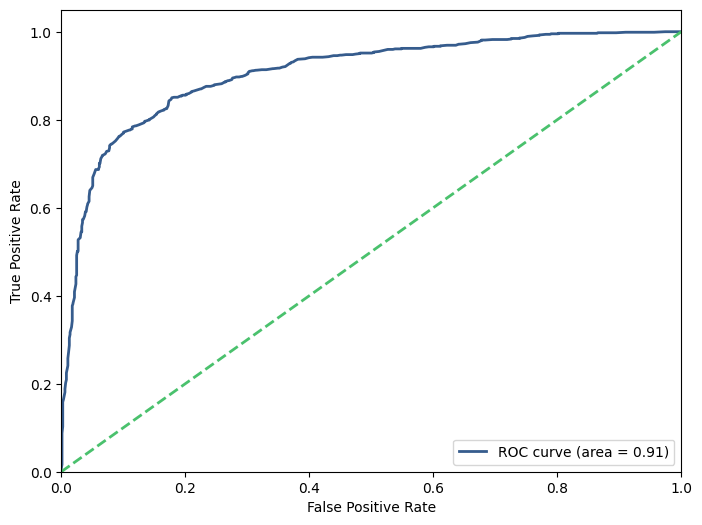

In [262]:
#Call the rf_classifier function on X_downsampled_10
#Running first without hyperparameter cross-validation in grid search
trained_rf_classifier_down_10features, fig_rf_cm_down_10features, fig_rf_roc_down_10features = rf_classifier(X_downsampled_10, y_downsampled, param_grid=rf_param_grid)

Accuracy of model with 10 features from downsampled data is 83%. This is a pretty good performance given the dataset size. Importantly the classes are balanced, so no need to consider weightings when training the model. Precision is slightly improved for Non-Fatal class and recall slightly better for Fatal class.

Best parameters found during grid search:
{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

       Fatal       0.82      0.85      0.83       846
   Non-Fatal       0.85      0.81      0.83       847

    accuracy                           0.83      1693
   macro avg       0.83      0.83      0.83      1693
weighted avg       0.83      0.83      0.83      1693



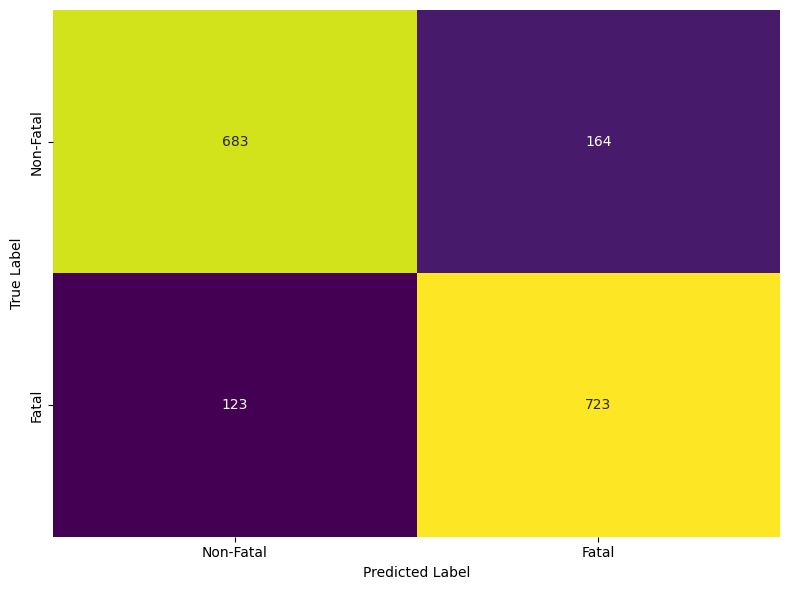

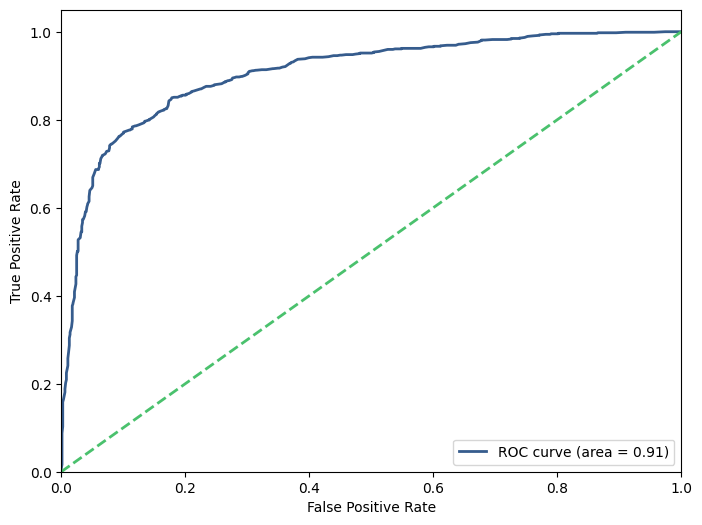

In [263]:
#Call the rf_classifier function on X_downsampled_10
#Running with hyperparameter cross-validation in grid search, cv=5
trained_rf_classifier_down_10features_crossval, fig_rf_cm_down_10features_crossval, fig_rf_roc_down_10features_crossval = rf_classifier(X_downsampled_10, y_downsampled, param_grid=rf_param_grid, cv=5)

No improvement in performance with cross-validation in grid search for hyperparameter tuning so won't use this in future for additional model optimisation.

Best parameters found during grid search:
{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Classification Report:
              precision    recall  f1-score   support

       Fatal       0.81      0.86      0.84       846
   Non-Fatal       0.85      0.80      0.83       847

    accuracy                           0.83      1693
   macro avg       0.83      0.83      0.83      1693
weighted avg       0.83      0.83      0.83      1693



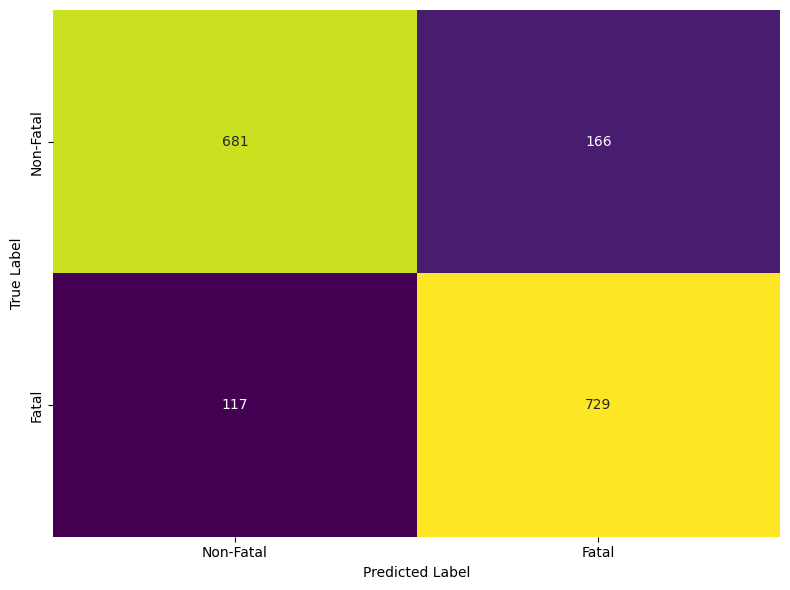

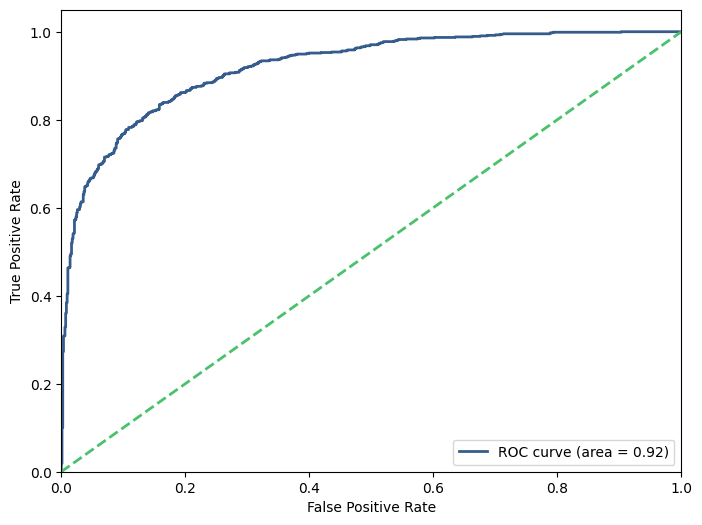

In [264]:
#Call the rf_classifier function on X_downsampled_15 as comparator
trained_rf_classifier_down_15features, fig_rf_cm_down_15features, fig_rf_roc_down_15features = rf_classifier(X_downsampled_15, y_downsampled, param_grid=rf_param_grid)

No real improvement seen with downsampled 15 features compared to 10 with regards to accuracy, precision, recall and f1 score so will stick with 10 features.

*Run for oversampled data with 10 features*

This could provide better classification compared to downsampling because the dataset is larger. However, the model will take signifantly longer to run, performing randomised search for optimal hyperparameters.

Best parameters found during random search:
{'n_estimators': 300, 'min_samples_split': 2, 'max_depth': None, 'criterion': 'gini'}
Balanced Accuracy Score: 0.9805347071658611
Classification Report:
              precision    recall  f1-score   support

       Fatal       0.98      0.98      0.98     43220
   Non-Fatal       0.98      0.98      0.98     43241

    accuracy                           0.98     86461
   macro avg       0.98      0.98      0.98     86461
weighted avg       0.98      0.98      0.98     86461



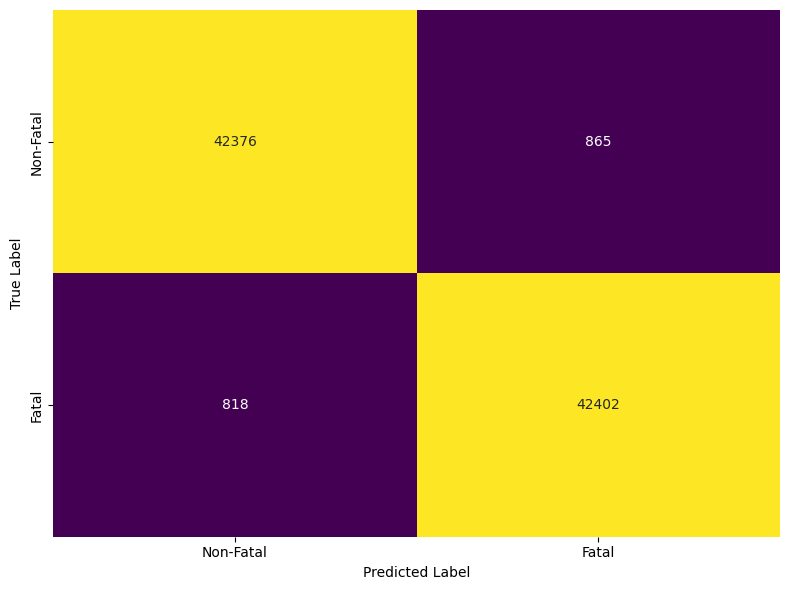

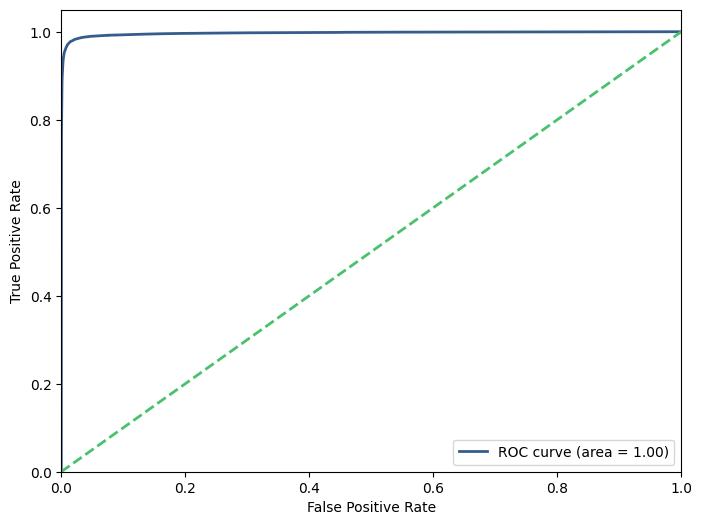

In [265]:
#Call the rf_classifier_randomsearch function on X_oversampled_10 using randomised search for hyperparameter optmisation
trained_rf_classifier_oversampled, fig_rf_cm_oversampled, fig_rf_roc_oversampled = rf_classifier_randomsearch(X_oversampled_10, y_resampled_ada, param_distributions=param_distributions)

Computational time to run the oversampled data is long, however with oversampling the RF classification performance is excellent at 98%. Precision, recall and fl score are all 98% also. No cross-validation has been performed so not sure how well this model will generalise to new unseen data. Could also use an ensemble approach to combine with other models (stacking or averaging) to improve generalisation.

For the purpose of further comparison, going to use the downsampled data which has demonstrated decent performance already in random forest model and optimise various other models, using cross-validation and potentially stacking to increase performance.

*Random forest on 10 features with independent cross-validation*

Computes cross-validated scores for each fold of the training data and prints the scores along with their mean value to assess performance.

In [266]:
#from sklearn.model_selection import cross_val_score
#Function to perform independent cross-validation of rf classifier
def rf_classifier_cross_val(X, y, test_size=0.2, random_state=42, param_grid=None, cv=None):
    """
    Train a Random Forest classifier with independent cross-validation, make predictions, and evaluate the model using classification report and confusion matrix.

    Parameters:
    X (DataFrame or array-like): The feature data.
    y (array-like): The corresponding labels.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): Controls the randomness of the training and testing splits.
    param_grid (dict): The grid of hyperparameters to search over.
    cv (int): Number of cross-validation folds.

    Returns:
    rf_classifier (RandomForestClassifier): The trained Random Forest classifier.
    fig_cm (Figure): Matplotlib figure object of the confusion matrix.
    fig_roc (Figure): Matplotlib figure object of the ROC AUC plot.
    """

    #Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    #Initialize Random Forest classifier
    rf_classifier = RandomForestClassifier(random_state=random_state)
    
    #Set default parameter grid if not provided
    if param_grid is None:
        param_grid = {
            'n_estimators': [200],
            'criterion': ['gini'],
            'max_depth': [None],
            'min_samples_split': [2]
        }

    #Perform Grid Search for hyperparameter optimization
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid)
    grid_search.fit(X_train, y_train)
    
    #Get the best estimator from grid search
    rf_classifier = grid_search.best_estimator_
    
    #Print best parameters
    print("Best parameters found during grid search:")
    print(grid_search.best_params_)

    #Fit the Random Forest classifier to the entire training data
    rf_classifier.fit(X_train, y_train)

    #Perform independent cross-validation
    cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=cv)

    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean cross-validation score: {cv_scores.mean()}")

    #Make predictions
    y_pred = rf_classifier.predict(X_test)
    
    #Calculate probabilities for ROC curve
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    
    #Replace class labels with meaningful names
    y_test_labels = ['Fatal' if label else 'Non-Fatal' for label in y_test]
    y_pred_labels = ['Fatal' if label else 'Non-Fatal' for label in y_pred]

    #Evaluate the model
    print("Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels))

    #Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
    
    #Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    #Plot confusion matrix
    fig_cm = plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    
    #Replace tick labels
    tick_labels = ['Non-Fatal', 'Fatal']
    plt.xticks(ticks=[0.5, 1.5], labels=tick_labels)
    plt.yticks(ticks=[0.5, 1.5], labels=tick_labels)
    
    #Plot ROC curve
    fig_roc = plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color=sns.color_palette('viridis')[1], lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color=sns.color_palette('viridis')[4], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    return rf_classifier, fig_cm, fig_roc

Best parameters found during grid search:
{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validation scores: [0.788774   0.79468242 0.79837518 0.82127031 0.78787879]
Mean cross-validation score: 0.7981961416230249
Classification Report:
              precision    recall  f1-score   support

       Fatal       0.82      0.85      0.83       846
   Non-Fatal       0.85      0.81      0.83       847

    accuracy                           0.83      1693
   macro avg       0.83      0.83      0.83      1693
weighted avg       0.83      0.83      0.83      1693



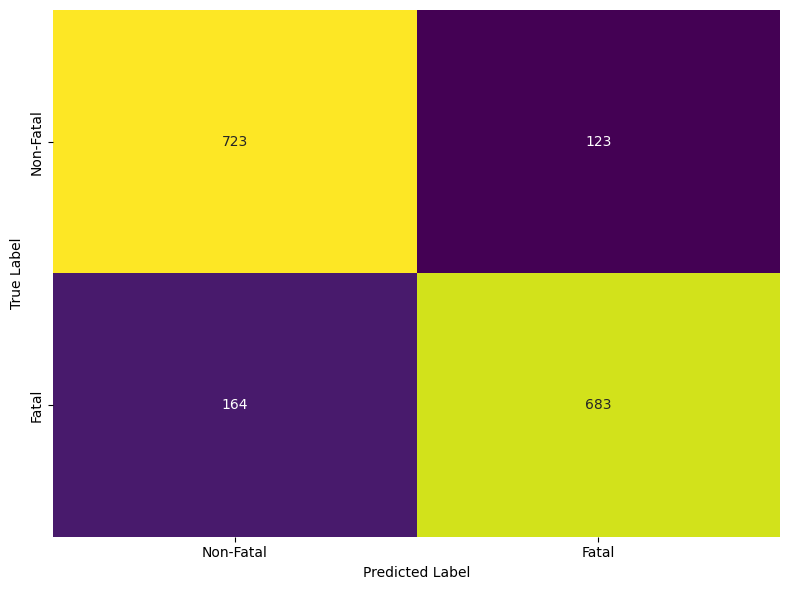

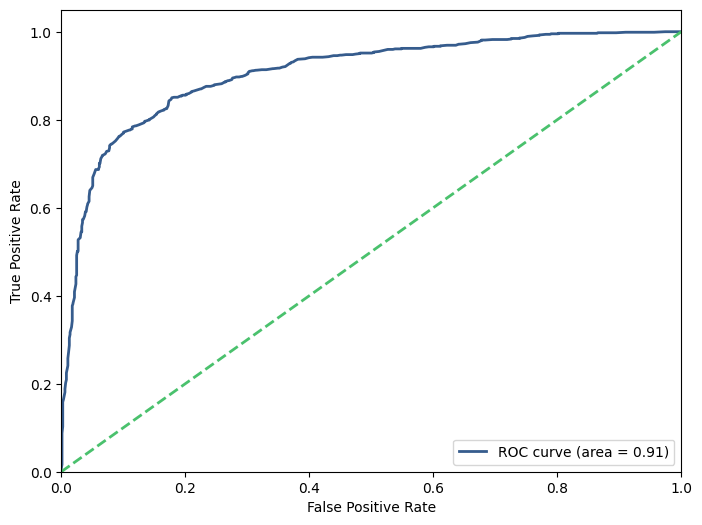

In [267]:
#Call the rf_classifier_cross_validation function on X_downsampled_10, cv=5
#Updated grid search with optimal parameters from previous run
trained_rf_classifier_down_10features_ind_crossval, fig_rf_cm_down_10features_ind_crossval, fig_rf_roc_down_10features_ind_crossval = rf_classifier_cross_val(X_downsampled_10, y_downsampled, cv=5)

No improvement in classification is observed by performing independent cross-validation. The performance metrics (such as accuracy, precision, recall, etc.) from cross-validation are consistent with the initial evaluation, it indicates that the model is robust and generalizes well across different subsets of the data.

*Decision Tree with hyperparameter tuning*

Scikit learn (n. d.) sklearn.tree.DecisionTreeClassifier. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html [Accessed 10/03/2024].

In [268]:
#from sklearn.tree import DecisionTreeClassifier
#Function to run decision tree with hyperparameter tuning using gridsearch
def dt_classifier(X, y, test_size=0.2, random_state=42, param_grid=None, cv=None):
    """
    Train a Decision Tree classifier, make predictions, and evaluate the model using classification report and confusion matrix.

    Parameters:
    X (DataFrame or array-like): The feature data.
    y (array-like): The corresponding labels.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): Controls the randomness of the training and testing splits.
    param_grid (dict): The grid of hyperparameters to search over.
    cv (int): Number of cross-validation folds.

    Returns:
    dt_classifier (DecisionTreeClassifier): The trained Decision Tree classifier.
    fig_cm (Figure): Matplotlib figure object of the confusion matrix.
    fig_roc (Figure): Matplotlib figure object of the ROC AUC plot.
    """

    #Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    #Initialize Decision Tree classifier
    dt_classifier = DecisionTreeClassifier(random_state=random_state)
    
    #Set default parameter grid if not provided
    if param_grid is None:
        param_grid = {
            'criterion': ['gini'],
            'max_depth': [None],
            'min_samples_split': [2]
        }

    #Perform Grid Search for hyperparameter optimization
    grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=cv)
    grid_search.fit(X_train, y_train)
    
    #Get the best estimator from grid search
    dt_classifier = grid_search.best_estimator_
    
    #Print best parameters
    print("Best parameters found during grid search:")
    print(grid_search.best_params_)

    #Fit the Decision Tree classifier to the training data
    dt_classifier.fit(X_train, y_train)

    #Make predictions
    y_pred = dt_classifier.predict(X_test)
    
    #Calculate probabilities for ROC curve
    y_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]
    
    #Replace class labels with meaningful names
    y_test_labels = ['Fatal' if label else 'Non-Fatal' for label in y_test]
    y_pred_labels = ['Fatal' if label else 'Non-Fatal' for label in y_pred]

    #Evaluate the model
    print("Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels))

    #Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
    
    #Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    #Plot confusion matrix
    fig_cm = plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    
    #Replace tick labels
    tick_labels = ['Non-Fatal', 'Fatal']
    plt.xticks(ticks=[0.5, 1.5], labels=tick_labels)
    plt.yticks(ticks=[0.5, 1.5], labels=tick_labels)
    
    #Plot ROC curve
    fig_roc = plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color=sns.color_palette('viridis')[1], lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color=sns.color_palette('viridis')[4], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    return dt_classifier, fig_cm, fig_roc

Best parameters found during grid search:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
Classification Report:
              precision    recall  f1-score   support

       Fatal       0.78      0.80      0.79       846
   Non-Fatal       0.80      0.77      0.79       847

    accuracy                           0.79      1693
   macro avg       0.79      0.79      0.79      1693
weighted avg       0.79      0.79      0.79      1693



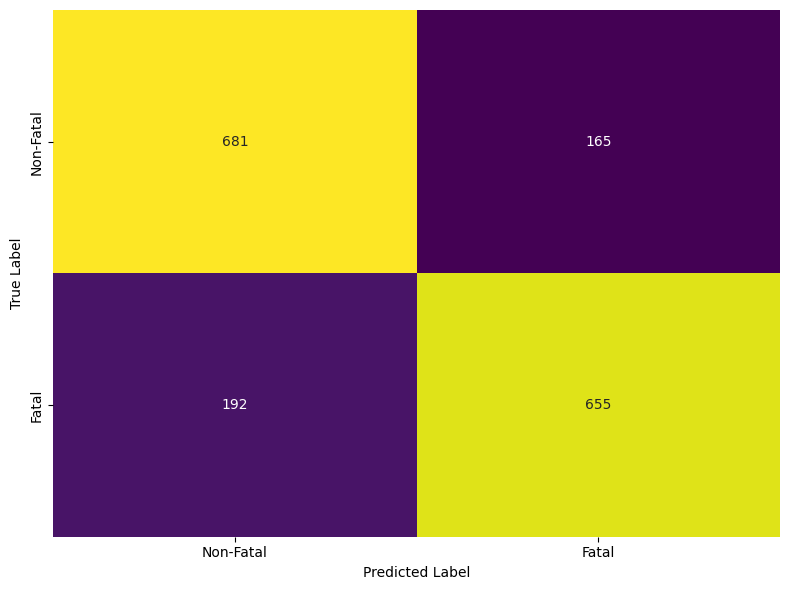

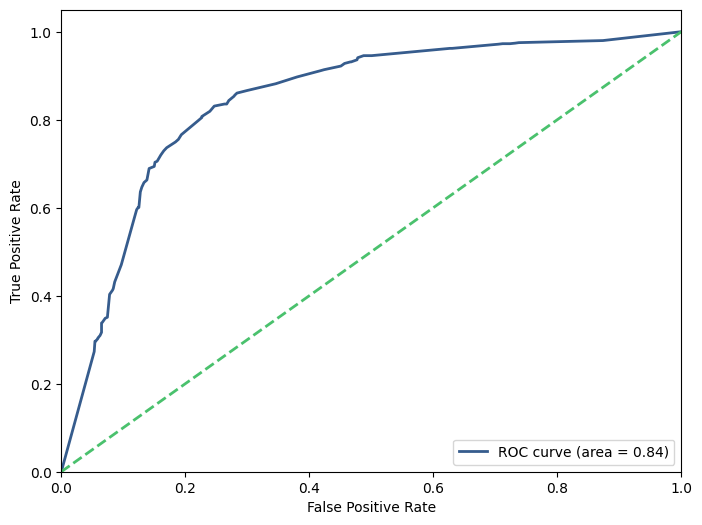

In [269]:
#Define the parameter grid for hyperparameter tuning
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

#Call the dt_classifier function on X_downsampled_10, no hyperparameter cross_validation
trained_dt_classifier_down_10features, fig_dt_cm_down_10features, fig_dt_roc_down_10features = dt_classifier(X_downsampled_10, y_downsampled, param_grid=dt_param_grid)

Accuracy is reduced to 79% for decision tree classification with hyperparamter tuning using gridsearch (no hyperparameter cross-validation). Recall is slightly lower for non-fatal class at 77%.

*SVM with hyperparameter tuning*

Scikit learn (n. d.) sklearn.svm.SVC. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html [Accessed 10/03/2024].

In [270]:
#from sklearn.svm import SVC
#Function to perform SVM with hyperparameter tuning using gridsearch
def svm_classifier(X, y, test_size=0.2, random_state=42, param_grid=None, cv=None):
    """
    Train a Support Vector Machine classifier, make predictions, and evaluate the model using classification report and confusion matrix.

    Parameters:
    X (DataFrame or array-like): The feature data.
    y (array-like): The corresponding labels.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): Controls the randomness of the training and testing splits.
    param_grid (dict): The grid of hyperparameters to search over.
    cv (int): Number of cross-validation folds.

    Returns:
    svm_classifier (SVC): The trained Support Vector Machine classifier.
    fig (Figure): Matplotlib figure object of the confusion matrix.
    """

    #Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    #Initialize Support Vector Machine classifier
    svm_classifier = SVC(random_state=random_state)
    
    #Set default parameter grid if not provided
    if param_grid is None:
        param_grid = {
            'C': [1.0],
            'kernel': ['rbf'],
            'gamma': ['scale']
        }

    #Perform Grid Search for hyperparameter optimization
    grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=cv)
    grid_search.fit(X_train, y_train)
    
    #Get the best estimator from grid search
    svm_classifier = grid_search.best_estimator_
    
    #Print best parameters
    print("Best parameters found during grid search:")
    print(grid_search.best_params_)

    #Fit the SVM classifier to the training data
    svm_classifier.fit(X_train, y_train)

    #Make predictions
    y_pred = svm_classifier.predict(X_test)
    
    #Replace class labels with meaningful names
    y_test_labels = ['Fatal' if label else 'Non-Fatal' for label in y_test]
    y_pred_labels = ['Fatal' if label else 'Non-Fatal' for label in y_pred]

    #Evaluate the model
    print("Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels))

    #Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

    #Plot confusion matrix
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    
    #Replace tick labels
    tick_labels = ['Non-Fatal', 'Fatal']
    plt.xticks(ticks=[0.5, 1.5], labels=tick_labels)
    plt.yticks(ticks=[0.5, 1.5], labels=tick_labels)

    return svm_classifier, fig

Best parameters found during grid search:
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

       Fatal       0.78      0.79      0.79       846
   Non-Fatal       0.79      0.78      0.79       847

    accuracy                           0.79      1693
   macro avg       0.79      0.79      0.79      1693
weighted avg       0.79      0.79      0.79      1693



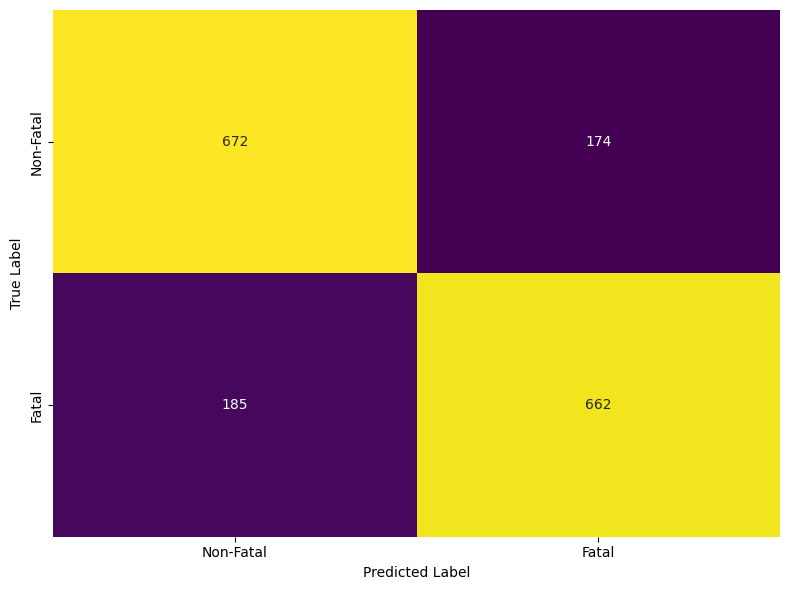

In [271]:
#Define the parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

#Call the svm_classifier function on X_downsampled_10 (no hyperparameter cross-validation)
trained_svm_classifier_down_10features, fig_svm_cm_down_10features = svm_classifier(X_downsampled_10, y_downsampled, param_grid=svm_param_grid)

SVM also not improved over DT and has lesser classification performance compared to random forest.

*Gradient Boosting with hyperparameter tuning*

Scikit learn (n. d.) sklearn.ensemble.GradientBoostingClassifier. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html [Accessed 10/03/2024].

In [272]:
#from sklearn.ensemble import GradientBoostingClassifier
#Function to perform gradient boosting with hyperparameter tuning using gridsearch
def gradient_boosting_classifier(X, y, test_size=0.2, random_state=42, param_grid=None, cv=None):
    """
    Train a Gradient Boosting classifier, make predictions, and evaluate the model using classification report and confusion matrix.

    Parameters:
    X (DataFrame or array-like): The feature data.
    y (array-like): The corresponding labels.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): Controls the randomness of the training and testing splits.
    param_grid (dict): The grid of hyperparameters to search over.
    cv (int): Number of cross-validation folds.

    Returns:
    gb_classifier (GradientBoostingClassifier): The trained Gradient Boosting classifier.
    fig (Figure): Matplotlib figure object of the confusion matrix.
    """

    #Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    #Initialize Gradient Boosting classifier
    gb_classifier = GradientBoostingClassifier(random_state=random_state)
    
    #Set default parameter grid if not provided
    if param_grid is None:
        param_grid = {
            'n_estimators': [200],
            'learning_rate': [0.1],
            'max_depth': [5]
        }

    #Perform Grid Search for hyperparameter optimization
    grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=cv)
    grid_search.fit(X_train, y_train)
    
    #Get the best estimator from grid search
    gb_classifier = grid_search.best_estimator_
    
    #Print best parameters
    print("Best parameters found during grid search:")
    print(grid_search.best_params_)

    #Fit the Gradient Boosting classifier to the training data
    gb_classifier.fit(X_train, y_train)

    #Make predictions
    y_pred = gb_classifier.predict(X_test)
    
    #Replace class labels with meaningful names
    y_test_labels = ['Fatal' if label else 'Non-Fatal' for label in y_test]
    y_pred_labels = ['Fatal' if label else 'Non-Fatal' for label in y_pred]

    #Evaluate the model
    print("Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels))

    #Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

    #Plot confusion matrix
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    
    #Replace tick labels
    tick_labels = ['Non-Fatal', 'Fatal']
    plt.xticks(ticks=[0.5, 1.5], labels=tick_labels)
    plt.yticks(ticks=[0.5, 1.5], labels=tick_labels)

    return gb_classifier, fig

Best parameters found during grid search:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Classification Report:
              precision    recall  f1-score   support

       Fatal       0.80      0.81      0.81       846
   Non-Fatal       0.81      0.80      0.80       847

    accuracy                           0.81      1693
   macro avg       0.81      0.81      0.81      1693
weighted avg       0.81      0.81      0.81      1693



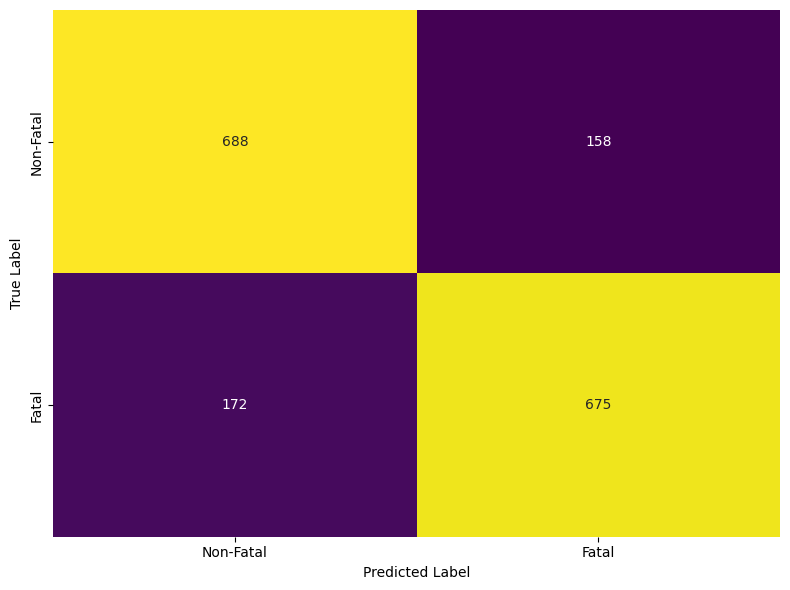

In [273]:
#Define the parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

#Call the gradient_boosting_classifier function on X_downsampled_10 (no hyperparameter cross-validation)
trained_gb_classifier_down_10features, fig_gb_cm_down_10features = gradient_boosting_classifier(X_downsampled_10, y_downsampled, param_grid=gb_param_grid)

GB classifier performed slightly better than DT or SVM with 81% accuracy, but still below the random forest model. 

*Summary of individual classifiers*

Random Forest performed the best out of RF, DT, SVM and GB classifiers. Cross-validation of hyperparameters did not improve classification of RF. Independent cross-validation of RF also did not improve performance. ADASYN oversampled dataset performed very well in RF, but difficult to determine if model overfitting and will not generalise well to new unseen data. Cross-validation and maygbe ensemble approach required as further work to optimise this model on the over-sampled training data further.

*Stacking*

Scikit learn (n. d.) sklearn.ensemble.StackingClassifier. Available online: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html [Accessed 10/03/2024].

Stacking is an ensemble learning technique that combines multiple classification via a meta-learner to improve predictive performance. The predictions of base models are used as features to train a higher-level model called the meta-learner or combiner. This meta-learner then makes the final prediction based on the outputs of the base models.

In [287]:
#from sklearn.ensemble import StackingClassifier
#Function to stack all four classifer models RF, DT, GB and SVM, grid search for RF final estimator
def stacking_classifier(X, y, test_size=0.2, random_state=42, param_grid=None, cv=None):
    """
    Train a stacking classifier with RandomForestClassifier, DecisionTreeClassifier, GradientBoostingClassifier, and SVM as base models, make predictions, and evaluate the model using classification report and confusion matrix.

    Parameters:
    X (DataFrame or array-like): The feature data.
    y (array-like): The corresponding labels.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): Controls the randomness of the training and testing splits.
    param_grid (dict): The grid of hyperparameters to search over.
    cv (int): Number of cross-validation folds.

    Returns:
    stacking_classifier (StackingClassifier): The trained stacking classifier.
    fig (Figure): Matplotlib figure object of the confusion matrix.
    """
    #Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    #Initialize stacking classifier
    estimators = [
        ('rf', trained_rf_classifier_down_10features),
        ('dt', trained_dt_classifier_down_10features),
        ('gb', trained_gb_classifier_down_10features),
        ('svm', trained_svm_classifier_down_10features)
    ]

    stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state=random_state))

    #Perform Grid Search for hyperparameter optimization for the final estimator
    if param_grid:
        grid_search = GridSearchCV(estimator=stacking_classifier.final_estimator, param_grid=param_grid, cv=cv)
        grid_search.fit(X_train, y_train)

        #Set the best parameters to the final estimator
        stacking_classifier.final_estimator.set_params(**grid_search.best_params_)
        
    #Print best parameters
    print("Best parameters found during grid search:")
    print(grid_search.best_params_)
    
    #Fit stacking classifier
    stacking_classifier.fit(X_train, y_train)

    #Make predictions
    y_pred = stacking_classifier.predict(X_test)
    
    #Replace class labels with meaningful names
    y_test_labels = ['Fatal' if label else 'Non-Fatal' for label in y_test]
    y_pred_labels = ['Fatal' if label else 'Non-Fatal' for label in y_pred]

    #Evaluate the model
    print("Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels))

    #Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

    #Plot confusion matrix
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    
    #Replace tick labels
    tick_labels = ['Non-Fatal', 'Fatal']
    plt.xticks(ticks=[0.5, 1.5], labels=tick_labels)
    plt.yticks(ticks=[0.5, 1.5], labels=tick_labels)

    return stacking_classifier, fig

In [288]:
#Use RF as final estimator in stacking classifier
final_estimator_param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

Best parameters found during grid search:
{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

       Fatal       0.83      0.81      0.82       846
   Non-Fatal       0.82      0.83      0.83       847

    accuracy                           0.82      1693
   macro avg       0.82      0.82      0.82      1693
weighted avg       0.82      0.82      0.82      1693



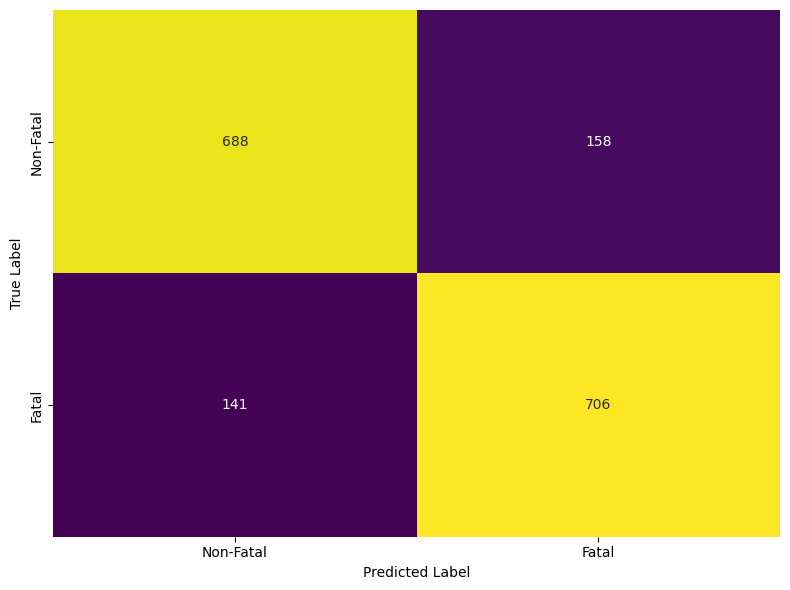

In [289]:
#Call the stacking_classifier function on X_downsampled_10
trained_stacking_classifier_down_10features, fig_stacking_cm_down_10features = stacking_classifier(X_downsampled_10, y_downsampled, param_grid=final_estimator_param_grid)

*Summary of stacking*

Stacking approach performed slightly below, 82% accuracy, the RF classifier alone.

*Further classification work*

Cross-validation of oversampled ADASYN data in RF classifier.

Deep learning coud be explored, although may be reasonably limited using down-sampled dataset, could use over-sampled dataset using ADASYN or SMOTE instead.

**Recommendations** 

What recommendations can be made to government agencies based on this data and your analysis to improve safety? Keep this to your top 4 or 5 bullet points.

1. Increase motorbike awareness/encourage safer motorikes:

Motorbike accidents are greatest for the under 125cc class (60%) with 28% occuring for over 500cc motorbikes. Besides cars, motorbikes over 500cc saw the greatest number of fatal accidents than any other vehicle type. In contrast to the other motorbike classes, 500cc bikes had the most accidents at the weekend, particularly on Sundays, suggesting these bikes are used potentially more recreationally. Increased awareness of motorbikes by other road users could be acheived through increased signage in accident hotspots and at weekends. The government could also encourage riders to swap to safer motorbikes (and electric ones) for alternative means of transport.

2. Increase pedal cycle safety and awareness:

24% of pedal cycle accidents are serious. Pedal cycles were involved in the second greatest numnber of accidents, aside from cars, wlthought <1% are fatal. The goverment could increase pedal cycle safety in schools and using campaigns to encourage cycle helments and use of lights. Dedicated cycle paths could be introduced more widely in urban areas.

3. Improve safety of pedestrian school children:

The highest number of pedestrian accidents occur at 8am and 3-6pm, coinciding with rush hour and school start and finishing times. Accidents are particularly high at 3pm, where greater than 50% of pedetsrain casualties are 18 and under, statistically significant compared to 37% at 4pm. The government could increase road safety awareness in schools, assess traffic control provision in school urban areas and increase police enforcement around accident hotspots.

4. Increase traffic control on Fridays:

There are an increased number of accidents on Fridays, particularly in early evening. Increase traffic officer presence recommemnded to ensure adherence to traffic rules and increase road safety.

5. Urban road optimisation:

Most accidents are slight, occuring in urban areas (76% on one-way streets and single-carriageways). Association rules identified high association of slight accidents with urban speed limits (30 mph).  Urban road infrastructure and safety could be improved through optimising bus lane use during busy periods to extend urban road use, and encouraging use of bypass dual-carriageways to improve road safety and journey times.

In [285]:
#Create dict of all the plots created in this notebook for use in report
figures_to_save = {}

figures_to_save["./age_of_driver_distribution.png"] = age_of_driver_distribution
figures_to_save["./male_age_driver.png"] = male_age_driver
figures_to_save["./female_age_driver.png"] = female_age_driver
figures_to_save["./unknown_gender_age_driver.png"] = unknown_gender_age_driver
figures_to_save["./percentage_gender_drivers.png"] = percentage_gender_drivers
figures_to_save["./pyramid_male_female_driver.png"] = pyramid_male_female_driver
figures_to_save["./age_of_casualty_distribution.png"] = age_of_casualty_distribution
figures_to_save["./male_age_casualty.png"] = male_age_casualty
figures_to_save["./female_age_casualty.png"] = female_age_casualty
figures_to_save["./percentage_gender_casualties.png"] = percentage_gender_casualties
figures_to_save["./pyramid_male_female_casualties.png"] = pyramid_male_female_casualties
figures_to_save["./percentage_casualty_severity.png"] = percentage_casualty_severity
figures_to_save["./casualty_severity_age_driver_rider.png"] = casualty_severity_age_driver_rider
figures_to_save["./casualty_severity_age_passenger.png"] = casualty_severity_age_passenger
figures_to_save["./casualty_severity_age_pedestrian.png"] = casualty_severity_age_pedestrian
figures_to_save["./casualty_severity_by_gender.png"] = casualty_severity_by_gender
figures_to_save["./casualty_severity_by_gender_rider_driver.png"] = casualty_severity_by_gender_rider_driver
figures_to_save["./casualty_severity_by_gender_passenger.png"] = casualty_severity_by_gender_passenger
figures_to_save["./casualty_severity_by_gender_pedestrian.png"] = casualty_severity_by_gender_pedestrian
figures_to_save["./accident_vehicle_type.png"] = accident_vehicle_type
figures_to_save["./fatal_casualties_vehicle_type.png"] = fatal_casualties_vehicle_type
figures_to_save["./percentage_casualty_severity_pedal_cycle.png"] = percentage_casualty_severity_pedal_cycle
figures_to_save["./accident_count_days_year.png"] = accident_count_days_year
figures_to_save["./age_of_vehicle_distribution.png"] = age_of_vehicle_distribution
figures_to_save["./age_of_vehicle_boxplot.png"] = age_of_vehicle_boxplot
figures_to_save["./accident_hour_day.png"] = accident_hour_day
figures_to_save["./accident_day_week.png"] = accident_day_week
figures_to_save["./percentage_casualty_severity_motorbike.png"] = percentage_casualty_severity_motorbike
figures_to_save["./accident_hour_day_motorbike_125_500.png"] = accident_hour_day_motorbike_125_500
figures_to_save["./accident_hour_day_motorbike_500_over.png"] = accident_hour_day_motorbike_500_over
figures_to_save["./accident_hour_day_all_motorbikes.png"] = accident_hour_day_all_motorbikes
figures_to_save["./motorbike_category_accident_by_day.png"] = motorbike_category_accident_by_day
figures_to_save["./accident_hour_day_pedestrians.png"] = accident_hour_day_pedestrians
figures_to_save["./accident_day_week_pedestrians.png"] = accident_day_week_pedestrians
figures_to_save["./weather_conditions.png"] = weather_conditions
figures_to_save["./light_conditions.png"] = light_conditions
figures_to_save["./all_weather_speed_limit.png"] = all_weather_speed_limit
figures_to_save["./humberside_weather_speed_limit.png"] = humberside_weather_speed_limit
figures_to_save["./all_weather_speed_limit_12clusters.png"] = all_weather_speed_limit_12clusters
figures_to_save["./humberside_weather_speed_limit_12clusters.png"] = humberside_weather_speed_limit_12clusters
figures_to_save["./accident_location_outlier_lof.png"] = accident_location_outlier_lof_n40
figures_to_save["./accident_location_outlier_lof_n30.png"] = accident_location_outlier_lof_n30
figures_to_save["./accident_location_outlier_lof_n50.png"] = accident_location_outlier_lof_n50
figures_to_save["./accident_location_outlier_if.png"] = accident_location_outlier_if
figures_to_save["./accident_location_outlier_dbscan.png"] = accident_location_outlier_dbscan
figures_to_save["./humberside_accident_location_outlier_lof_n10.png"] = humberside_accident_location_outlier_lof_n10
figures_to_save["./humberside_accident_location_outlier_if.png"] = humberside_accident_location_outlier_if
figures_to_save["./humberside_accident_location_outlier_dbscan.png"] = humberside_accident_location_outlier_dbscan
figures_to_save["./unbalanced_fig_feature_importance.png"] = unbalanced_fig
figures_to_save["./downsampled_fig_feature_importance.png"] = downsampled_fig
figures_to_save["./oversampled_fig_feature_importance.png"] = oversampled_fig
figures_to_save["./fig_rf_cm_unbalanced.png"] = fig_rf_cm_unbalanced
figures_to_save["./fig_rf_roc_unbalanced.png"] = fig_rf_roc_unbalanced
figures_to_save["./fig_rf_cm_down_10features.png"] = fig_rf_cm_down_10features
figures_to_save["./fig_rf_roc_down_10features.png"] = fig_rf_roc_down_10features
figures_to_save["./fig_rf_cm_down_10features_crossval.png"] = fig_rf_cm_down_10features_crossval
figures_to_save["./fig_rf_roc_down_10features_crossval.png"] = fig_rf_roc_down_10features_crossval
figures_to_save["./fig_rf_cm_down_15features.png"] = fig_rf_cm_down_15features
figures_to_save["./fig_rf_roc_down_15features.png"] = fig_rf_roc_down_15features
figures_to_save["./fig_rf_cm_down_10features_ind_crossval.png"] = fig_rf_cm_down_10features_ind_crossval
figures_to_save["./fig_rf_roc_down_10features_ind_crossval.png"] = fig_rf_roc_down_10features_ind_crossval
figures_to_save["./fig_rf_cm_oversampled.png"] = fig_rf_cm_oversampled
figures_to_save["./fig_rf_roc_oversampled.png"] = fig_rf_roc_oversampled
figures_to_save["./fig_dt_cm_down_10features.png"] = fig_dt_cm_down_10features
figures_to_save["./fig_dt_roc_down_10features.png"] = fig_dt_roc_down_10features
figures_to_save["./fig_svm_cm_down_10features.png"] = fig_svm_cm_down_10features
figures_to_save["./fig_gb_cm_down_10features.png"] = fig_gb_cm_down_10features
figures_to_save["./fig_stacking_cm_down_10features.png"] = fig_stacking_cm_down_10features

figures_to_save

{'./age_of_driver_distribution.png': <Figure size 640x480 with 1 Axes>,
 './male_age_driver.png': <Figure size 640x480 with 1 Axes>,
 './female_age_driver.png': <Figure size 640x480 with 1 Axes>,
 './unknown_gender_age_driver.png': <Figure size 640x480 with 1 Axes>,
 './percentage_gender_drivers.png': <Figure size 800x600 with 1 Axes>,
 './pyramid_male_female_driver.png': <Figure size 800x600 with 1 Axes>,
 './age_of_casualty_distribution.png': <Figure size 640x480 with 1 Axes>,
 './male_age_casualty.png': <Figure size 640x480 with 1 Axes>,
 './female_age_casualty.png': <Figure size 640x480 with 1 Axes>,
 './percentage_gender_casualties.png': <Figure size 800x600 with 1 Axes>,
 './pyramid_male_female_casualties.png': <Figure size 800x600 with 1 Axes>,
 './percentage_casualty_severity.png': <Figure size 800x600 with 1 Axes>,
 './casualty_severity_age_driver_rider.png': <Figure size 1000x600 with 1 Axes>,
 './casualty_severity_age_passenger.png': <Figure size 1000x600 with 1 Axes>,
 './c

In [286]:
#Function to save figures in any dictionary
def save_figures(fig_dict):
    """
    Save figures from the provided dictionary.

    Parameters:
    fig_dict (dict): Dictionary where keys are filenames and values are figure objects.

    Returns:
    None
    """
    for filename, figure in fig_dict.items():
        figure.savefig(filename)

save_figures(figures_to_save)